In [546]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
from itertools import combinations
from matplotlib_venn import venn2

def compare_2_sj_alls(df_L,df_R, l_name, r_name):
    df_L.columns, df_R.columns = colnames, colnames
    L_sjs = df_L.iloc[:, :3].apply(lambda row: '_'.join(row.values.astype(str)), axis=1).unique()
    R_sjs = df_R.iloc[:, :3].apply(lambda row: '_'.join(row.values.astype(str)), axis=1).unique()
    
    differences = pd.DataFrame(L_sjs).merge(pd.DataFrame(R_sjs), how = 'outer', indicator=True)
    df_raw_vals = differences._merge.value_counts().to_frame()
    df_raw_vals.sort_index(inplace=True, ascending=False)
    df_raw_vals.index = ['both', f'{r_name} only', f'{l_name} only']
    total_reads_both = differences['_merge'].value_counts().sum()
    total_reads_right = df_raw_vals['_merge'][0] + df_raw_vals['_merge'][1]
    total_reads_left = df_raw_vals['_merge'][0] + df_raw_vals['_merge'][2]
    df_raw_vals['totals'] = [total_reads_both, total_reads_right, total_reads_left]
    df_raw_vals['missing'] = df_raw_vals['totals'] - df_raw_vals['_merge']
    df_raw_vals.drop('totals', inplace=True, axis=1)
    df_raw_vals.columns = ['uniquely belonging to group', 'shared or misc SJs']

    df_prop = df_raw_vals.div(df_raw_vals.sum(axis=1), axis=0)
    print(df_raw_vals)
    print(df_prop)
    df_prop.plot(kind='barh', 
                        stacked=True, 
                        color=['lightseagreen', 'tomato'], 
                        figsize=(10, 6))

    plt.legend(loc="lower left", ncol=2)
    plt.xlabel("Proportion")

    for n, x in enumerate([*df_raw_vals.index.values]):
        plt.text(x=1,
                 y=n,
                 s=f'Total: {df_raw_vals.loc[x].sum()}', 
                 color="black",
                 fontsize=10,
                 fontweight = 'bold')
        
        for (proportion, count, y_loc) in zip(df_prop.loc[x],
                                              df_raw_vals.loc[x],
                                              df_prop.loc[x].cumsum()):

            plt.text(x=(y_loc - proportion) + (proportion / 2),
                     y=n - 0.1,
                     s=f'{count}\n({np.round(proportion * 100, 1)}%)', 
                     color="white",
                     fontsize=10,
                     fontweight = 'bold')
            

    plt.show()
    
    return df_raw_vals, df_prop

def plot_Sj_dist_hist(df, bins, title):
    plt.figure(figsize=(16, 9))
    max_samples = df['found_sj_in_num_samples'].max()
    values, bins, bars = plt.hist(df['found_sj_in_num_samples'], edgecolor='white', bins=bins)
    plt.xlabel("Number of samples SJ is detected")
    plt.ylabel("Number of SJs")
    plt.title(title, fontsize = 15)
    plt.bar_label(bars, fontsize=10, color='navy')
    plt.margins(x=0.01, y=0.1)
    plt.show()

def plot_venn_comparison(df_L,df_R, l_name, r_name, colnames):
    df_L.columns, df_R.columns = colnames, colnames
    df_L.drop_duplicates(colnames[:3], inplace = True)
    df_R.drop_duplicates(colnames[:3], inplace = True)
    L_sjs = df_L[colnames[:3]].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
    R_sjs = df_R[colnames[:3]].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
    
    differences = pd.DataFrame(L_sjs).merge(pd.DataFrame(R_sjs), how = 'outer', indicator=True)
    df_raw_vals = differences._merge.value_counts().to_frame()
    df_raw_vals.sort_index(inplace=True, ascending=False)
    df_raw_vals.index = ['both', f'{r_name}', f'{l_name}']
    total_reads_both = differences['_merge'].value_counts().sum()
    total_reads_right = df_raw_vals['_merge'][0] + df_raw_vals['_merge'][1]
    total_reads_left = df_raw_vals['_merge'][0] + df_raw_vals['_merge'][2]
    df_raw_vals['totals'] = [total_reads_both, total_reads_right, total_reads_left]
    df_raw_vals['missing'] = df_raw_vals['totals'] - df_raw_vals['_merge']
    df_raw_vals.drop('totals', inplace=True, axis=1)
    df_raw_vals.columns = ['uniquely belonging to group', 'shared']
    
    fig, ax = plt.subplots(1, 2,figsize=(16, 9), constrained_layout=True)

    ax[0].set_title('SJs belonging to each group')
    ax[1].set_title('All SJs between 2 groups')
    between = venn2(subsets={'11': df_raw_vals['uniquely belonging to group'][0],
                   '10': df_raw_vals['uniquely belonging to group'][1], 
               '01': df_raw_vals['uniquely belonging to group'][2]}, 
          set_labels = (df_raw_vals.index[1], df_raw_vals.index[2]),
          subset_label_formatter=lambda count: count_formatter(count, total_reads_both),
         ax = ax[0])
    
    for text in between.set_labels:
        text.set_fontsize(16)

    for text in between.subset_labels:
        text.set_fontsize(14)
    
    total = venn2(subsets = {'11':df_raw_vals.loc['both'][0], '01':df_raw_vals.loc['both'][1]}, 
          set_labels=(f'Present in {df_raw_vals.index[1]} and {df_raw_vals.index[2]}', 
                      f'Unique to either {df_raw_vals.index[1]} or {df_raw_vals.index[2]}'),
          subset_label_formatter= lambda count : count_formatter(count, df_raw_vals.loc['both'].sum()),
          ax=ax[1])
    
    for text in total.set_labels:
        text.set_fontsize(16)

    for text in total.subset_labels:
        text.set_fontsize(14)
    
    plt.show()
    return df_raw_vals


def plot_recurrence_patterns(df, n_bins, title):
    fig, ax = plt.subplots(2, 1,figsize=(16, 10), constrained_layout=True)
    values, bins, bars = ax[0].hist(data = df,
                x = 'found_sj_in_num_samples', bins = n_bins)
    ax[0].set_xlim([min(df['found_sj_in_num_samples'])-3, max(df['found_sj_in_num_samples'])+3])
    ax[0].set_title(f'SJ recurrence across all {title} samples', fontsize = 16)
    ax[0].set_xlabel('found_sj_in_num_samples')
    ax[0].set_ylabel('count')
    ax[0].bar_label(bars, fontsize=12, color='black')
    ax[0].margins(x=0.01, y=0.1)
    ax[0].ticklabel_format(style = 'plain')
    sns.ecdfplot(df['found_sj_in_num_samples'], label="CDF", ax = ax[1])
    ax[1].set_title('')
    ax[1].set_xlim([min(df['found_sj_in_num_samples'])-3, max(df['found_sj_in_num_samples'])+3])

## Developing a Splice junction filtering pipeline

The overarching goal is to generate a final filtered SJ.outs file which contains a subset of all the SJs that arise from star alignment. The subset is filtered with the given criteria:
1. If a given splice junction is detected in a large proportion of all samples we can be more confident in its validity and pertinence to our populationset. 
2. Maximising uniquely mapped reads and minimising multimapped reads will maximise accuracy and truthfulness of final RNA counts.
3. Non-canonical splice sites make up a small fraction of splice sites but may be indicative of a higher mutational rate which is apparent in cancer states. The filtering process will not aim to remove these.
4. Max spliced overhang is an indication of the highest confidence mapping for a given splice junction. Filtering out low max spliced overhang reads could be advisable, it is shown that they are associated with low unique_mapped reads.

* All following input files are generated using an .awk script that collapses all input SJ.out.tab files into an allegedly unique list of SJs and calculates an extra final column which indicates how many samples the given splice junction is detected in out of the total number of input files.

*Total number of all RNAseq samples*
| Type              | Number of Samples |
|-------------------|-------------------|
| Human NPC samples | 167               |
| Cell lines        | 162               |

Each cell line has a set number of splice junctions. Some of these are unique to the cell line and some are common between that cell line and the compared set of splice junctions. The aim is to show the amount of variability between sets of splice jucntions to inform decision making with filtering the splice junctions. Because once we know how similar or disimilar they are we can decide the level of granularity for number of separate splice junction files for alignment. So the goal is to show similarity or disimilarity through the raw numbers and proportions of splice jucntions that belong to etiher set being compared.

___
### Comparison of splice junction sites in cell line data between tissue types
*Table of cell lines and tissue types*
| Tissue type | Cell line       | Cell line code |
|-------------|-----------------|----------------|
| NPC         | C666, FADU, HK1 | C6, Fa, HK     |
| Prostate    | DU145, 22RV1    | Du, X2         |

In [259]:
colnames = ['contig','first_base','last_base','strand','intron_motif','annotated','unique_mapped','multimapped','max_spliced_overhang', 'found_sj_in_num_samples']

In [155]:
# reading in pre-compiled SJ.all files, created by awk script that combines multiple SJ.out.tab
# and combines stats.
prostate = pd.read_csv(f'./agg_sjs/cell_line/prostate_cell_line.SJ.all', sep = '\t', header=None)
npc = pd.read_csv(f'./agg_sjs/cell_line/NPC_cell_line.SJ.all', sep = '\t', header=None)

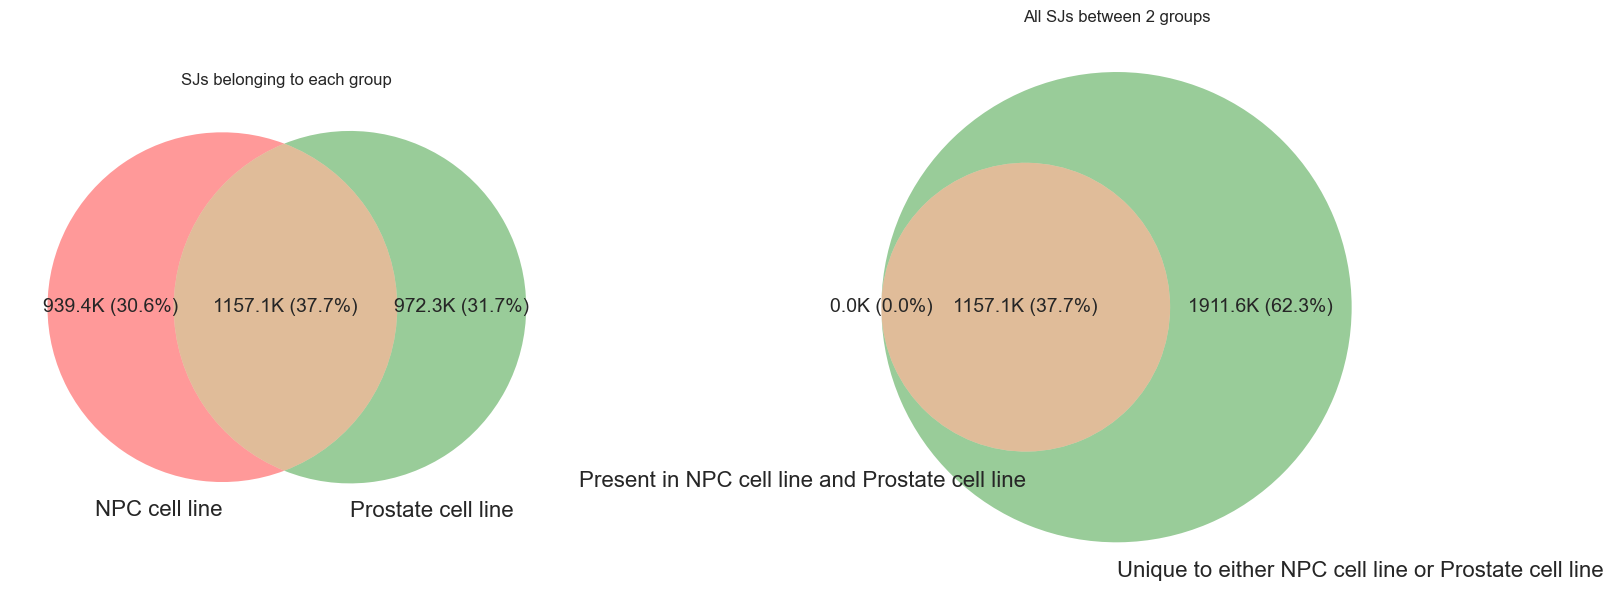

uniquely belonging to group   shared
both                                    1157125  1911647
NPC cell line                            939375  1157125
Prostate cell line                       972272  1157125

In [668]:
plot_venn_comparison(prostate, npc, l_name='Prostate cell line', r_name='NPC cell line')

##### Approximately 45% of splice junctions found are unique to either prostate samples or npc samples. Individual SJ.outs files should be used.
___

### Comparison of SJs within cell line tissue types

*Prostate cell lines*

In [256]:
X2 = pd.read_csv('agg_sjs/cell_line/X2_cell_line.SJ.all', sep = '\t', header=None)
Du = pd.read_csv('agg_sjs/cell_line/Du_cell_line.SJ.all', sep = '\t', header=None)

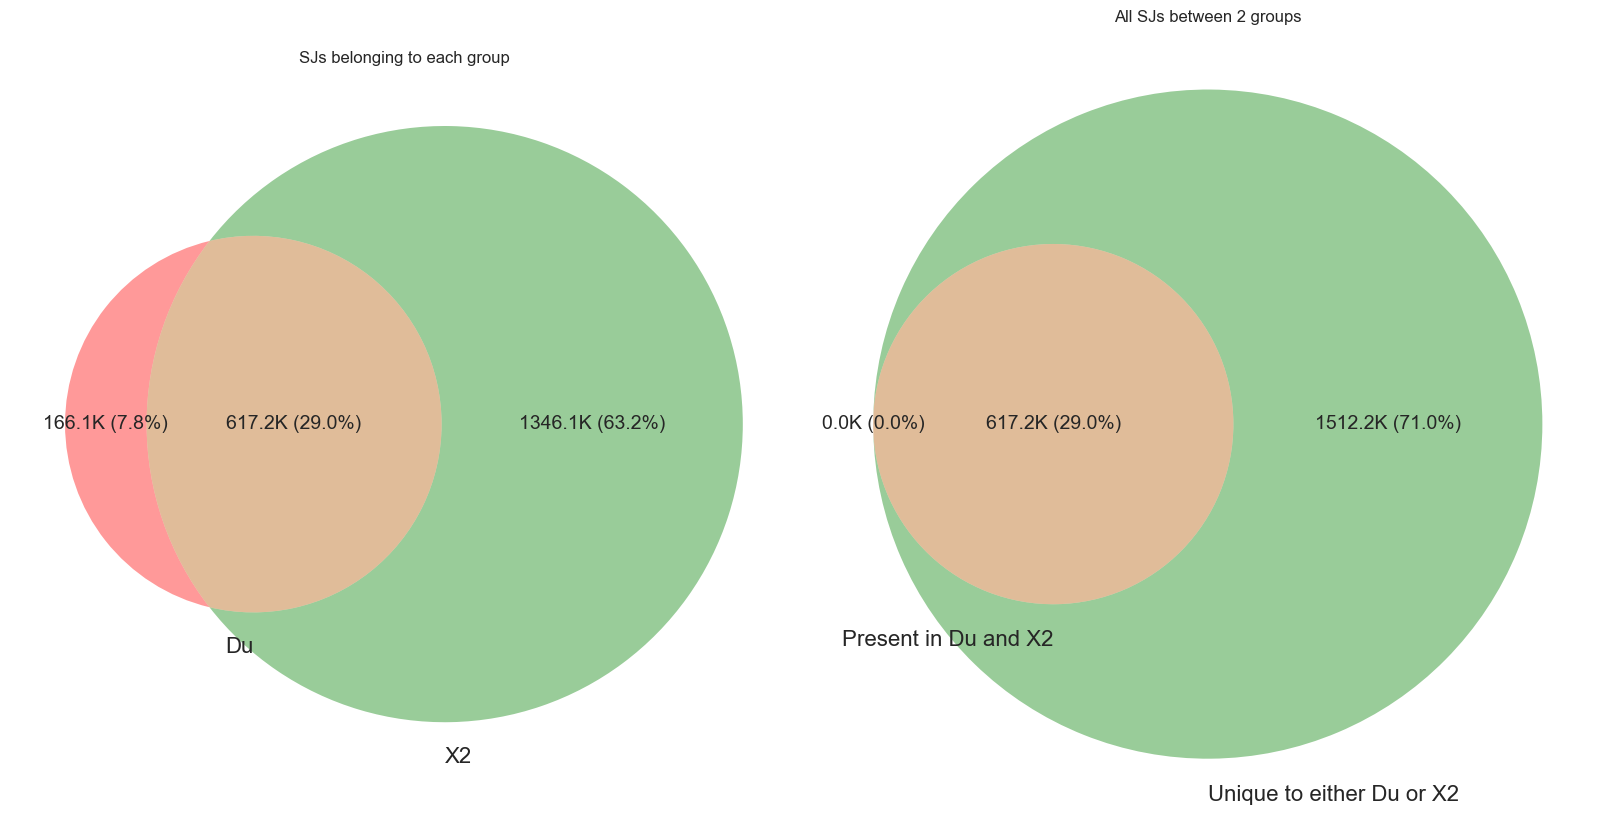

uniquely belonging to group   shared
both                       617173  1512224
Du                         166100   617173
X2                        1346124   617173

In [669]:
plot_venn_comparison(X2, Du, l_name='X2', r_name='Du')

*NPC cell lines*

In [433]:
C6 = pd.read_csv('agg_sjs/cell_line/C6_cell_line.SJ.all', sep = '\t', header=None)
Fa = pd.read_csv('agg_sjs/cell_line/Fa_cell_line.SJ.all', sep = '\t', header=None)
HK = pd.read_csv('agg_sjs/cell_line/HK_cell_line.SJ.all', sep = '\t', header=None)

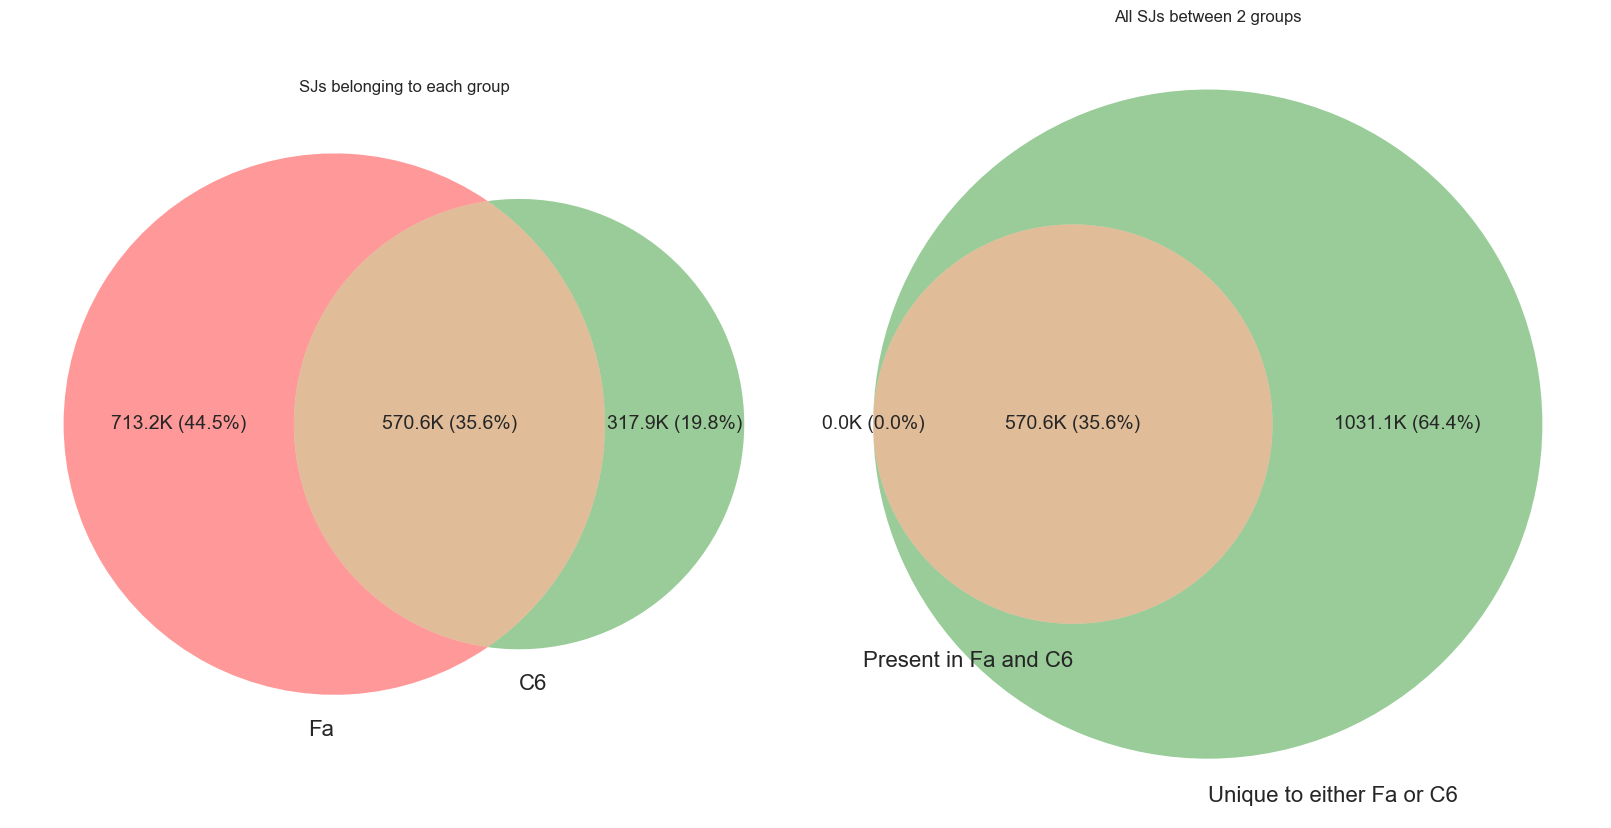

uniquely belonging to group   shared
both                       570620  1031119
Fa                         713240   570620
C6                         317879   570620

In [670]:
plot_venn_comparison(df_L=C6, df_R=Fa, l_name='C6', r_name='Fa')

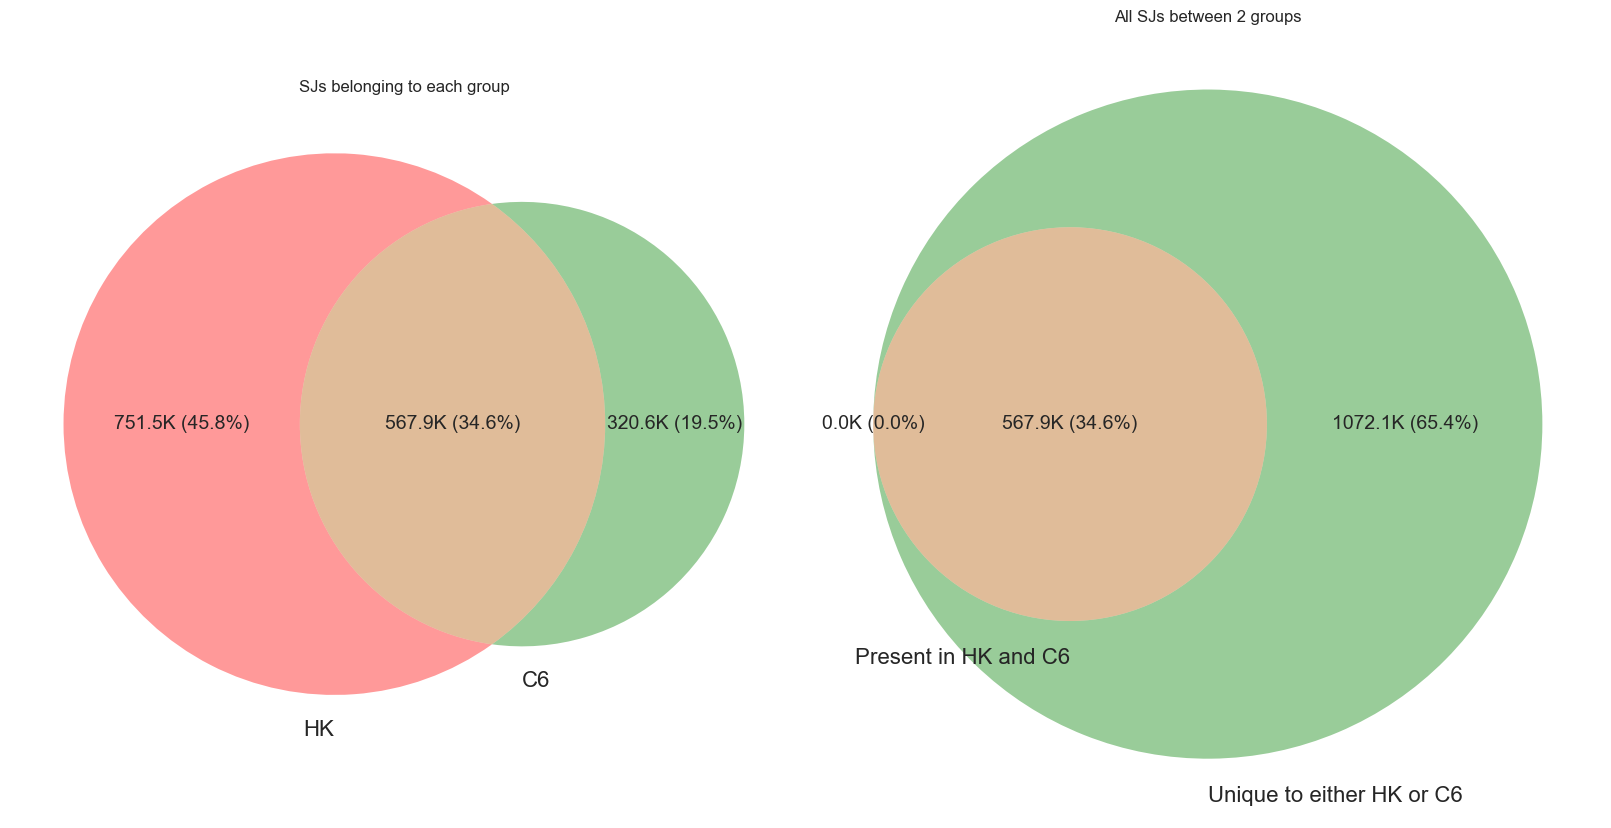

uniquely belonging to group   shared
both                       567888  1072110
HK                         751499   567888
C6                         320611   567888

In [671]:
plot_venn_comparison(df_L=C6, df_R=HK, l_name='C6', r_name='HK')

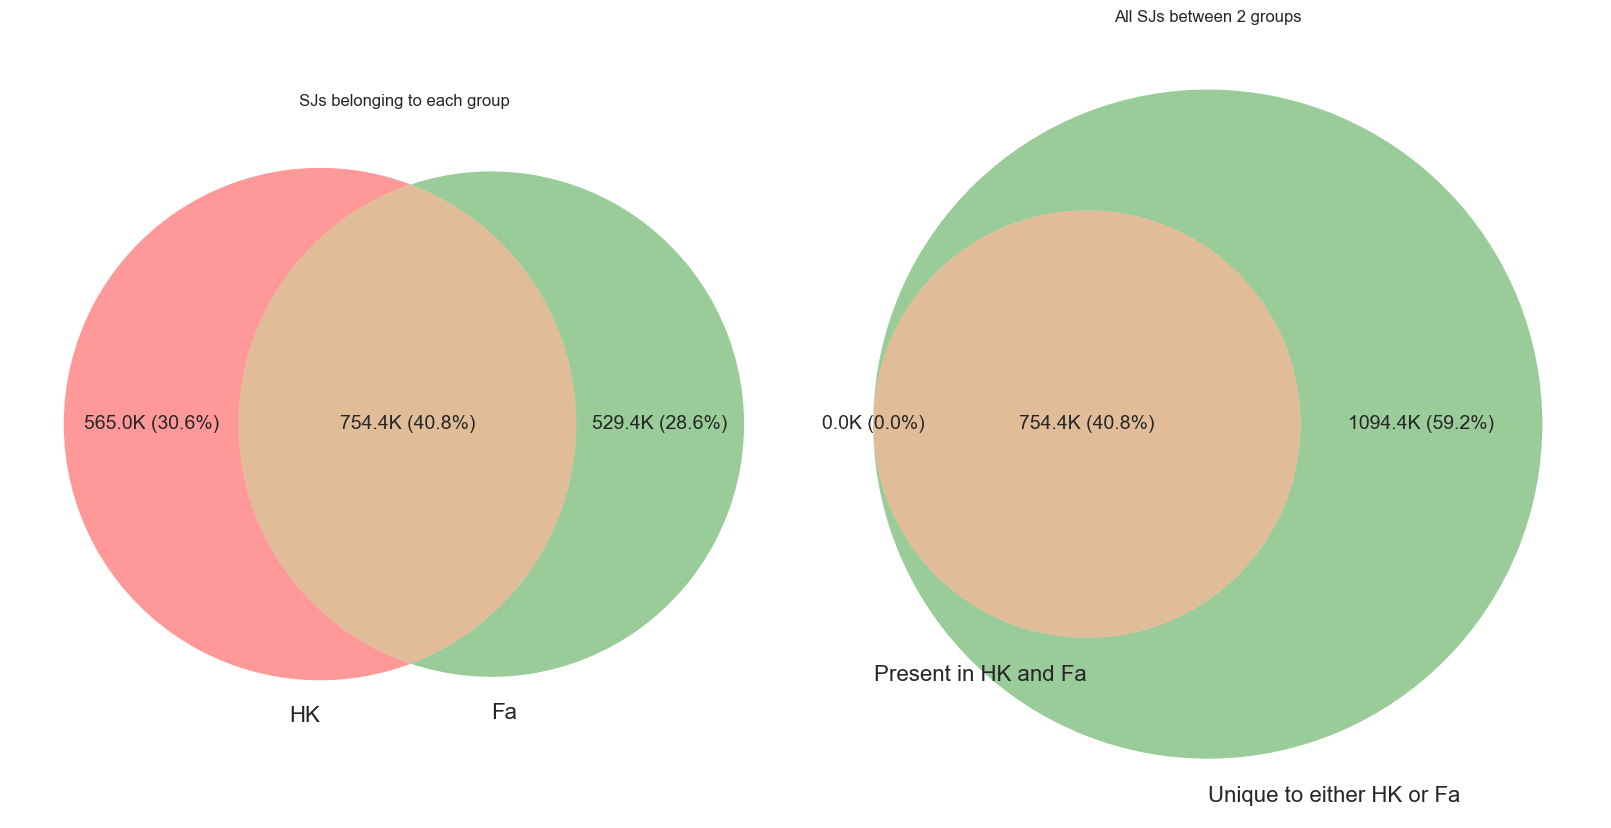

uniquely belonging to group   shared
both                       754418  1094411
HK                         564969   754418
Fa                         529442   754418

In [672]:
plot_venn_comparison(df_L=Fa, df_R=HK, l_name='Fa', r_name='HK')

### Comparison of SJs in human NPC RNAseq batches

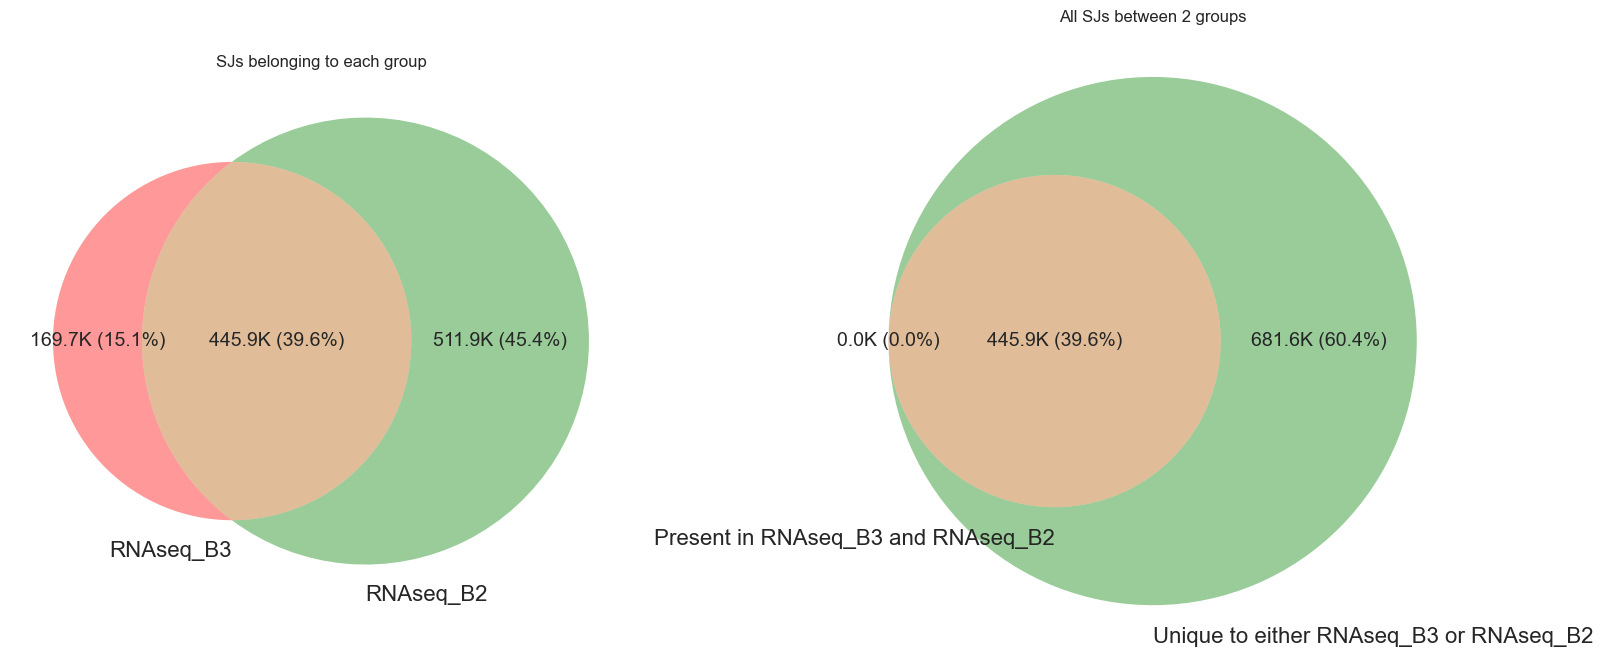

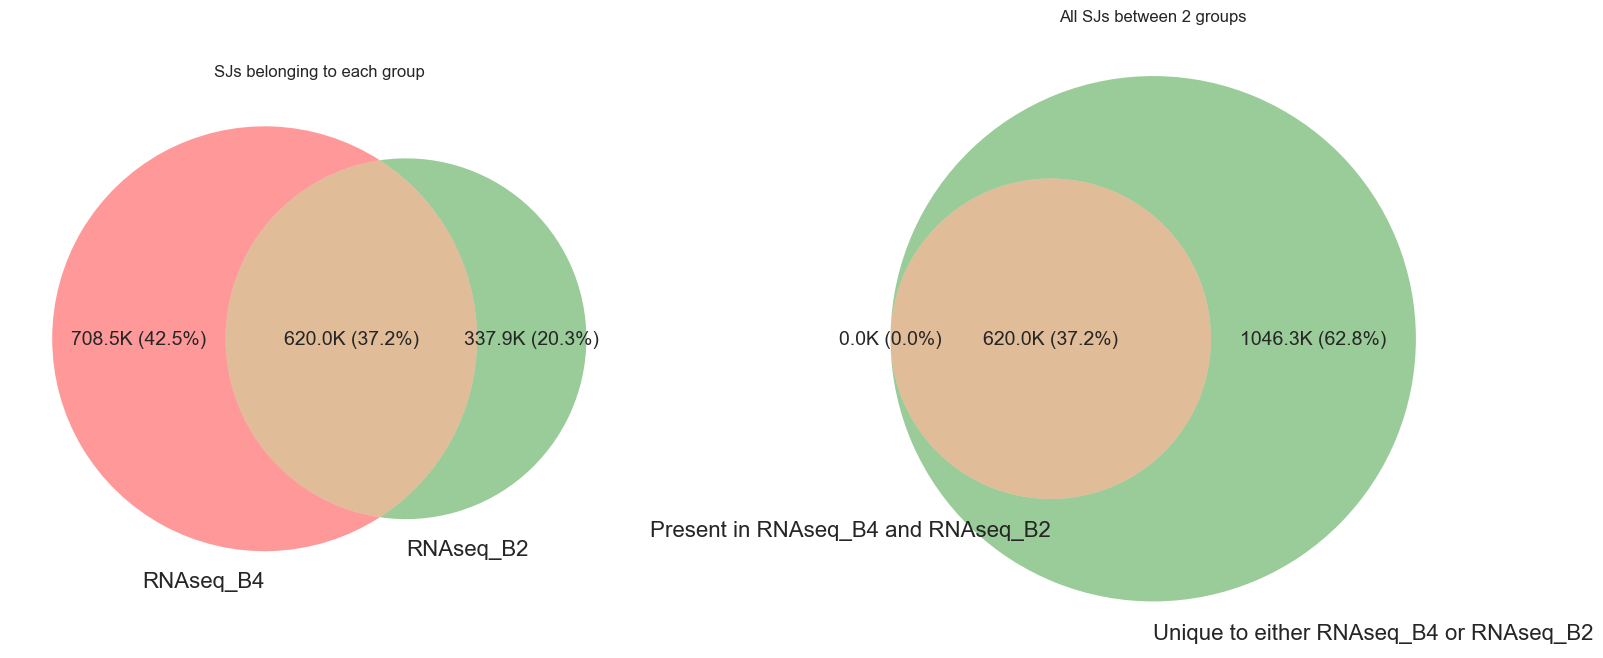

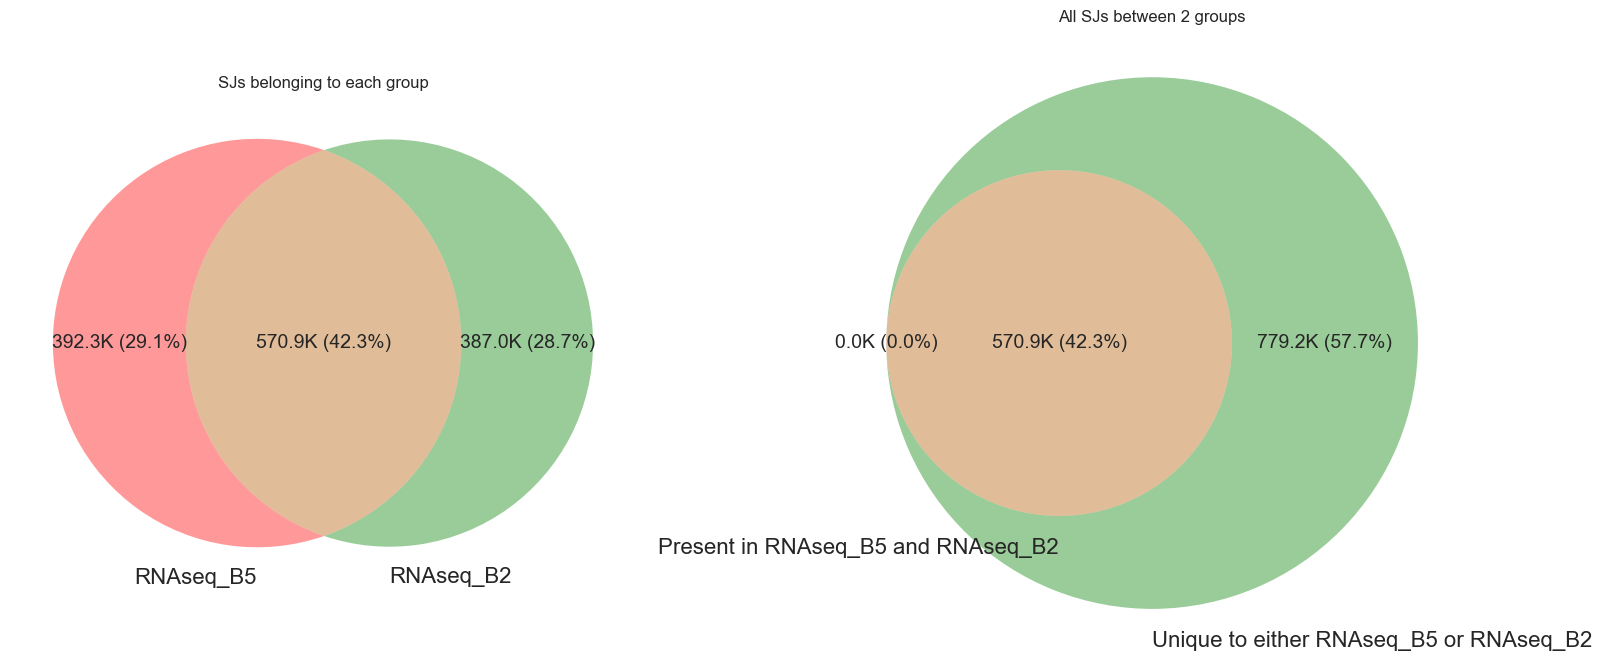

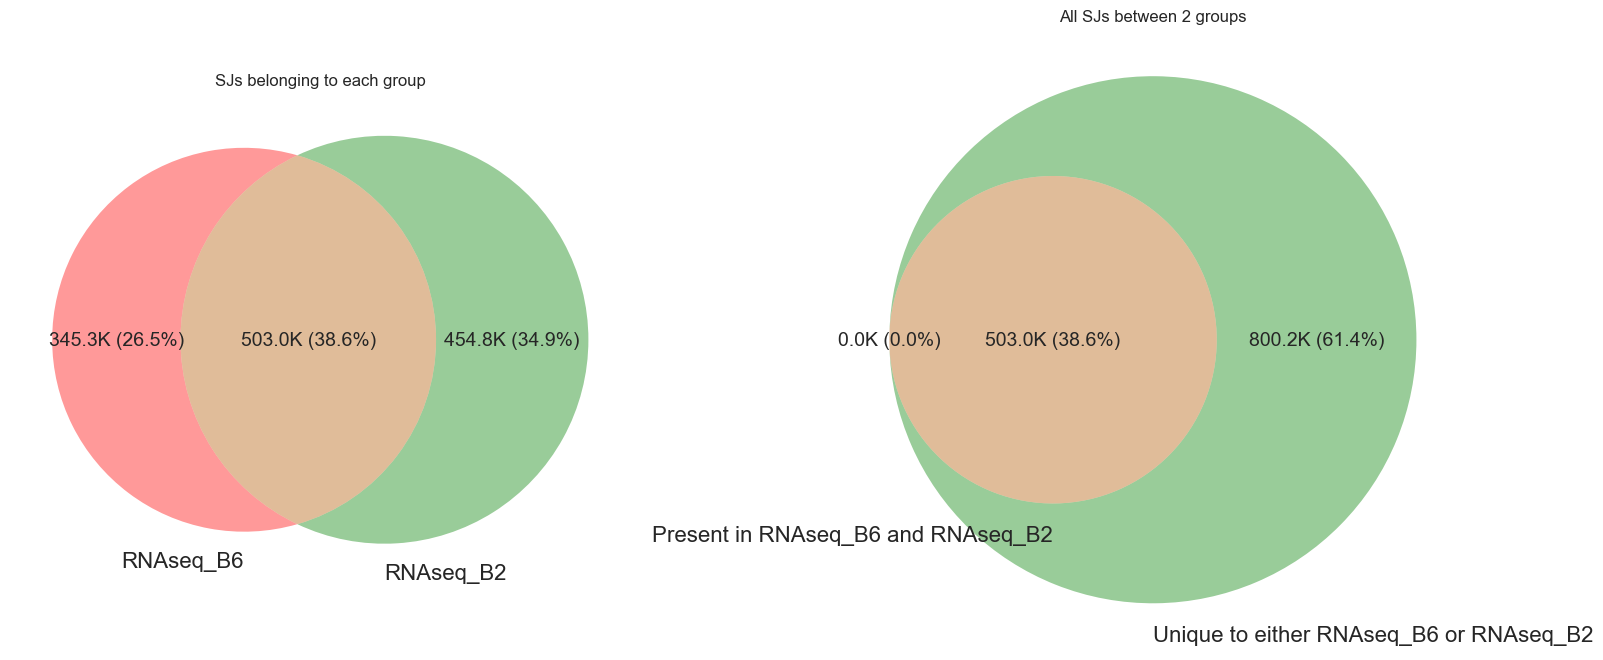

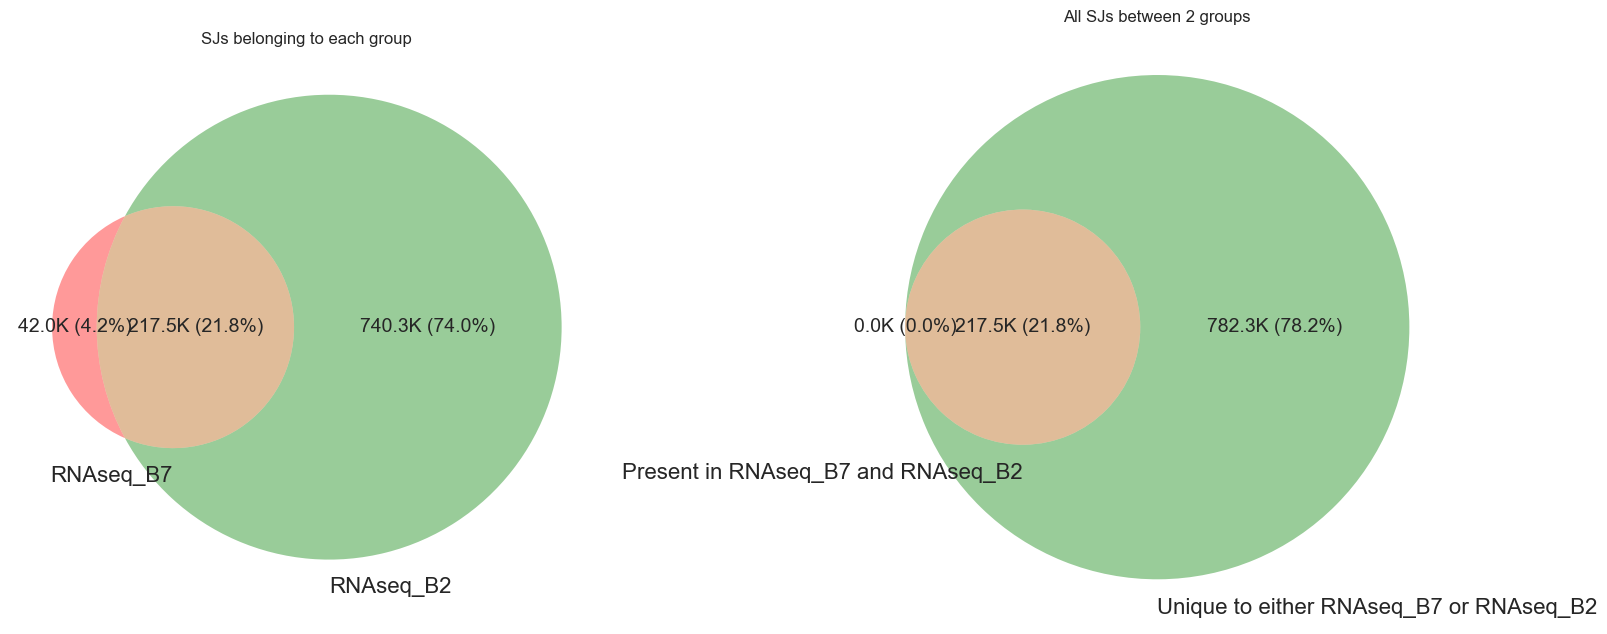

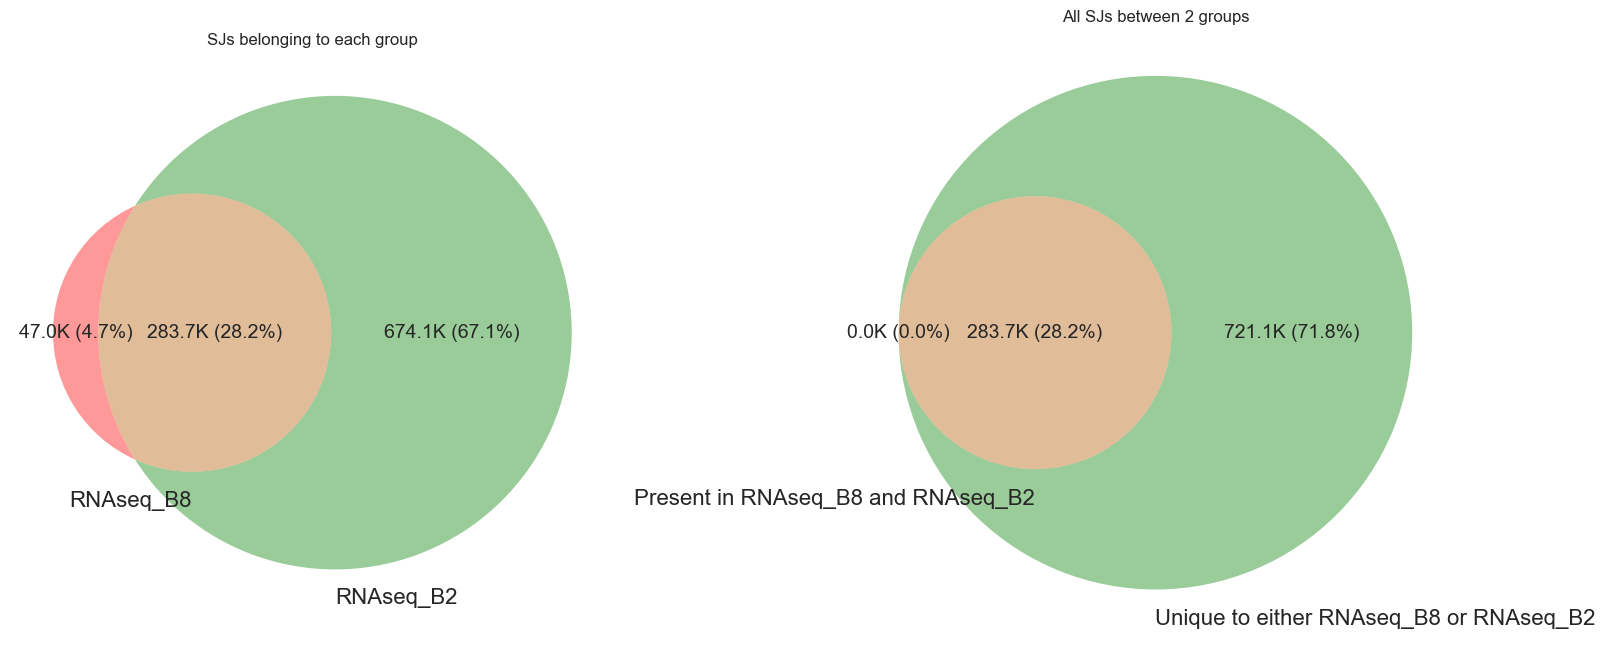

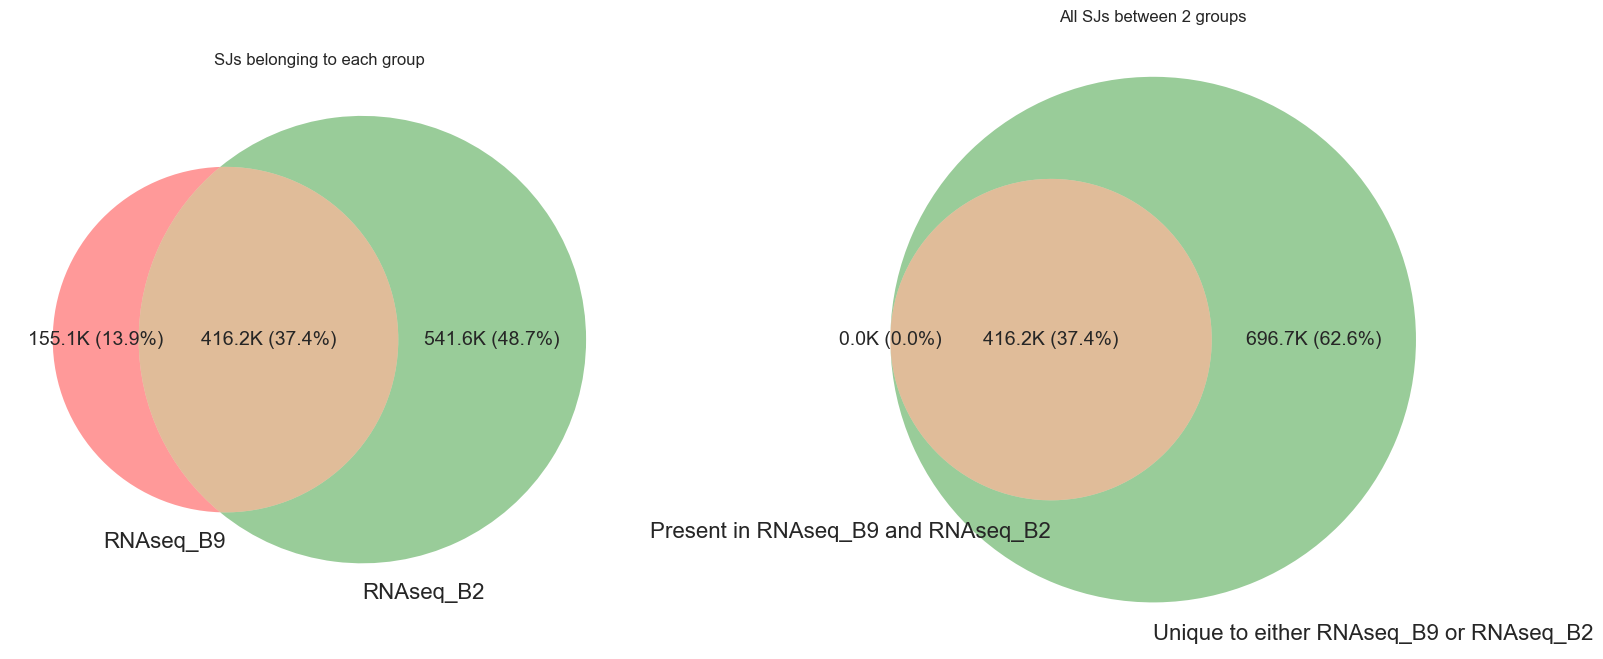

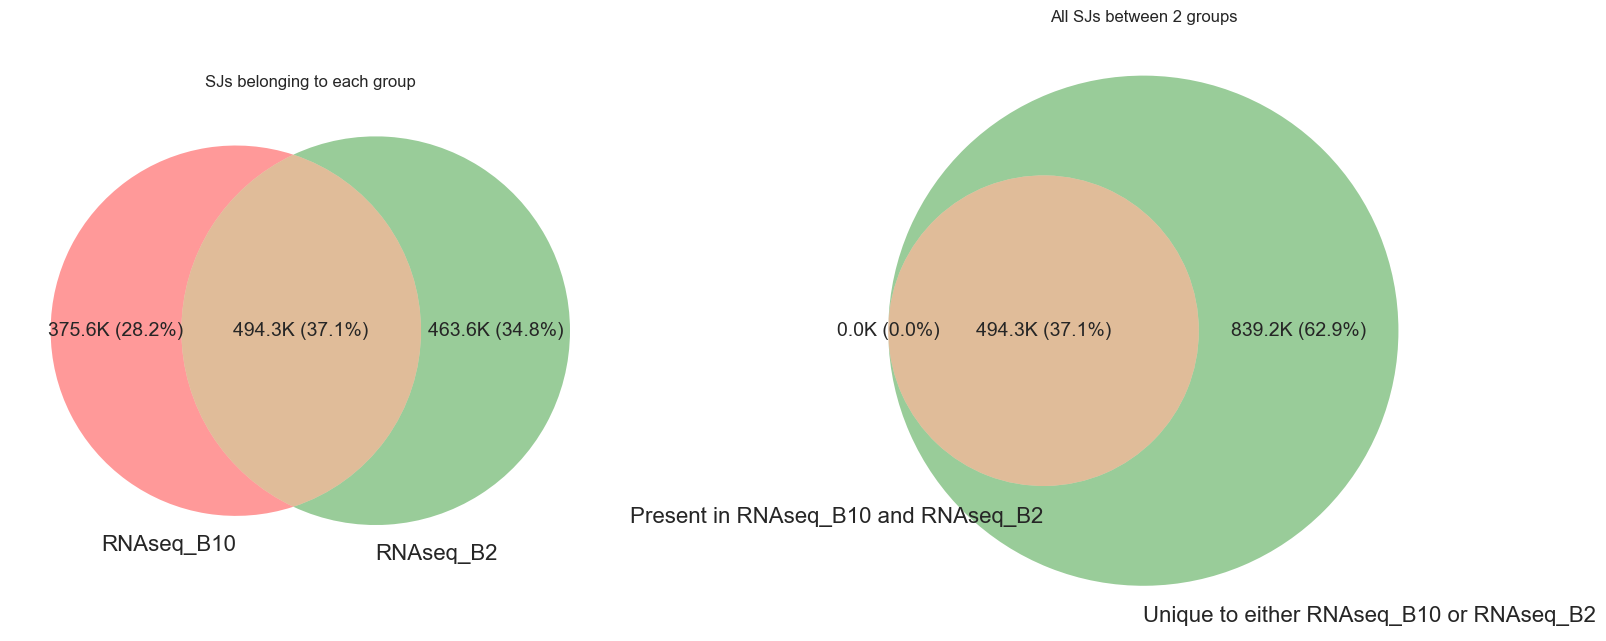

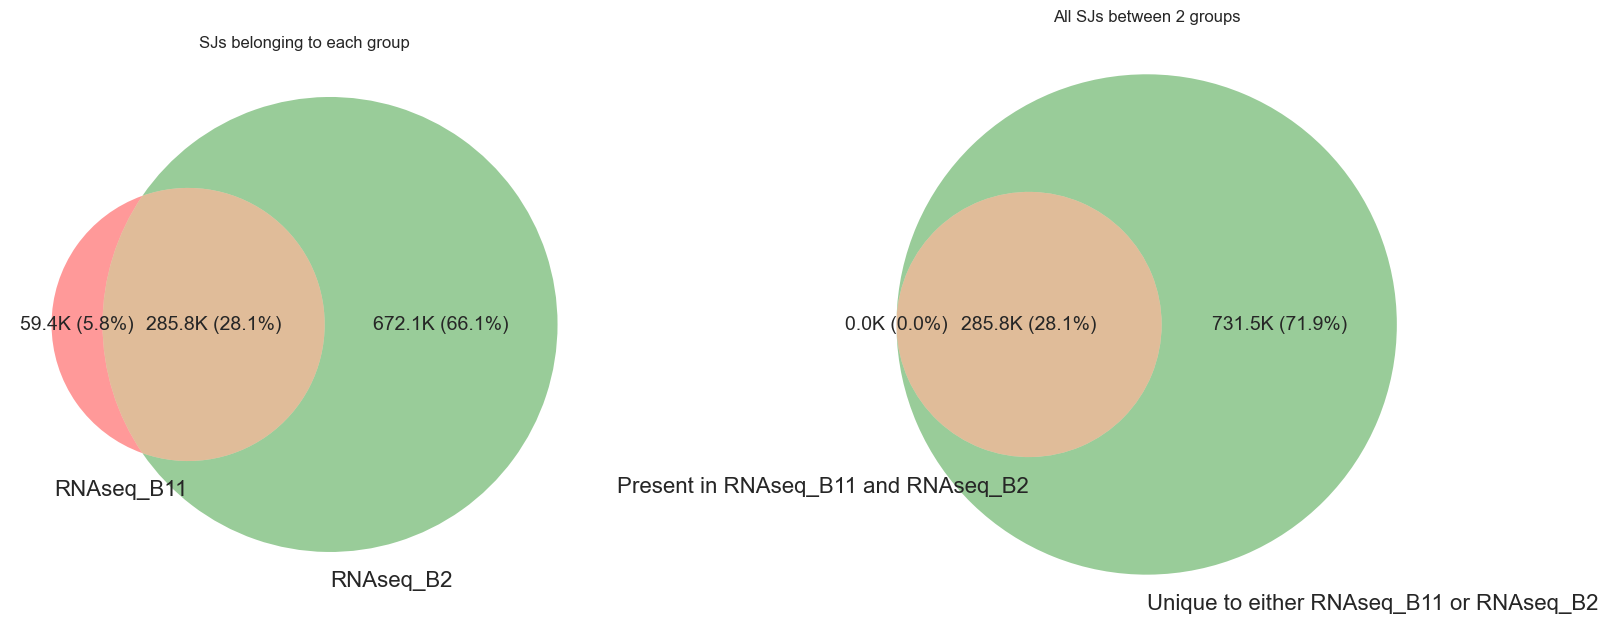

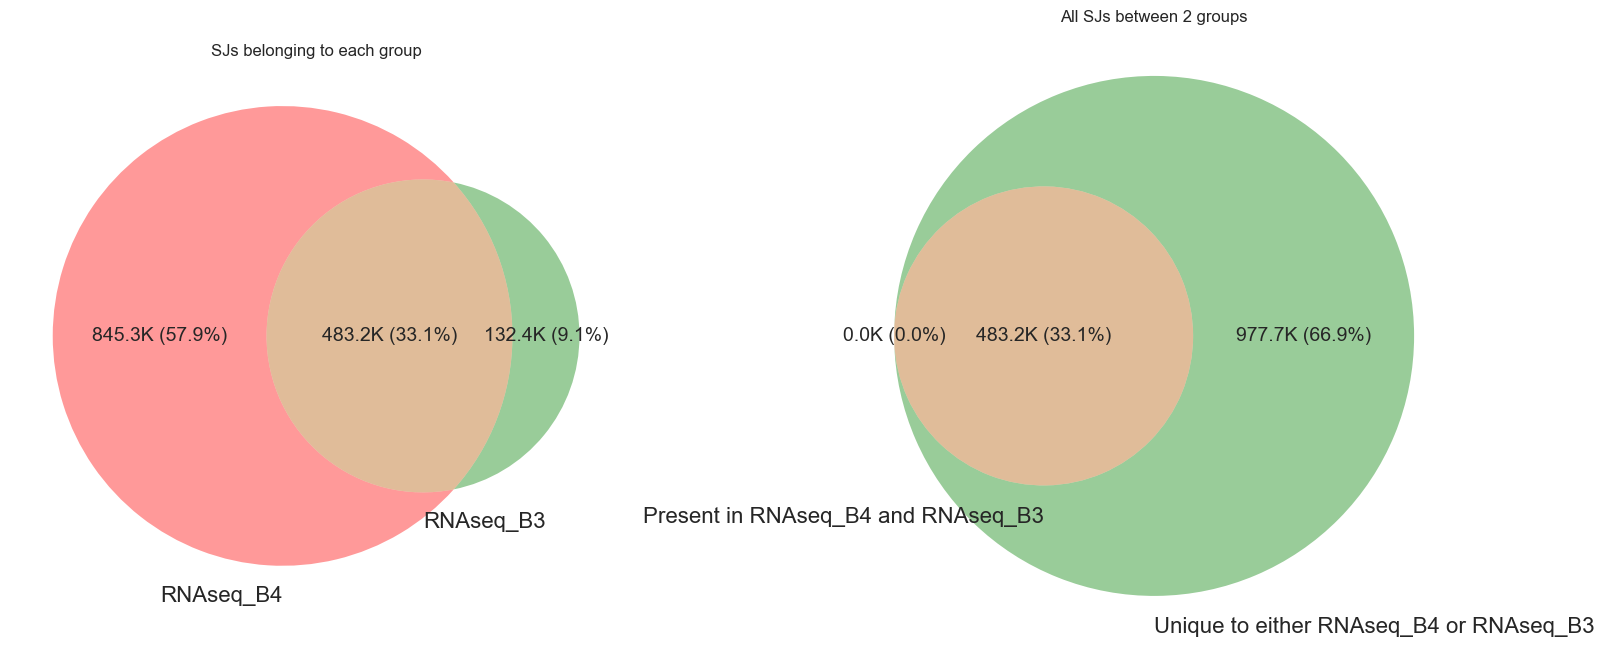

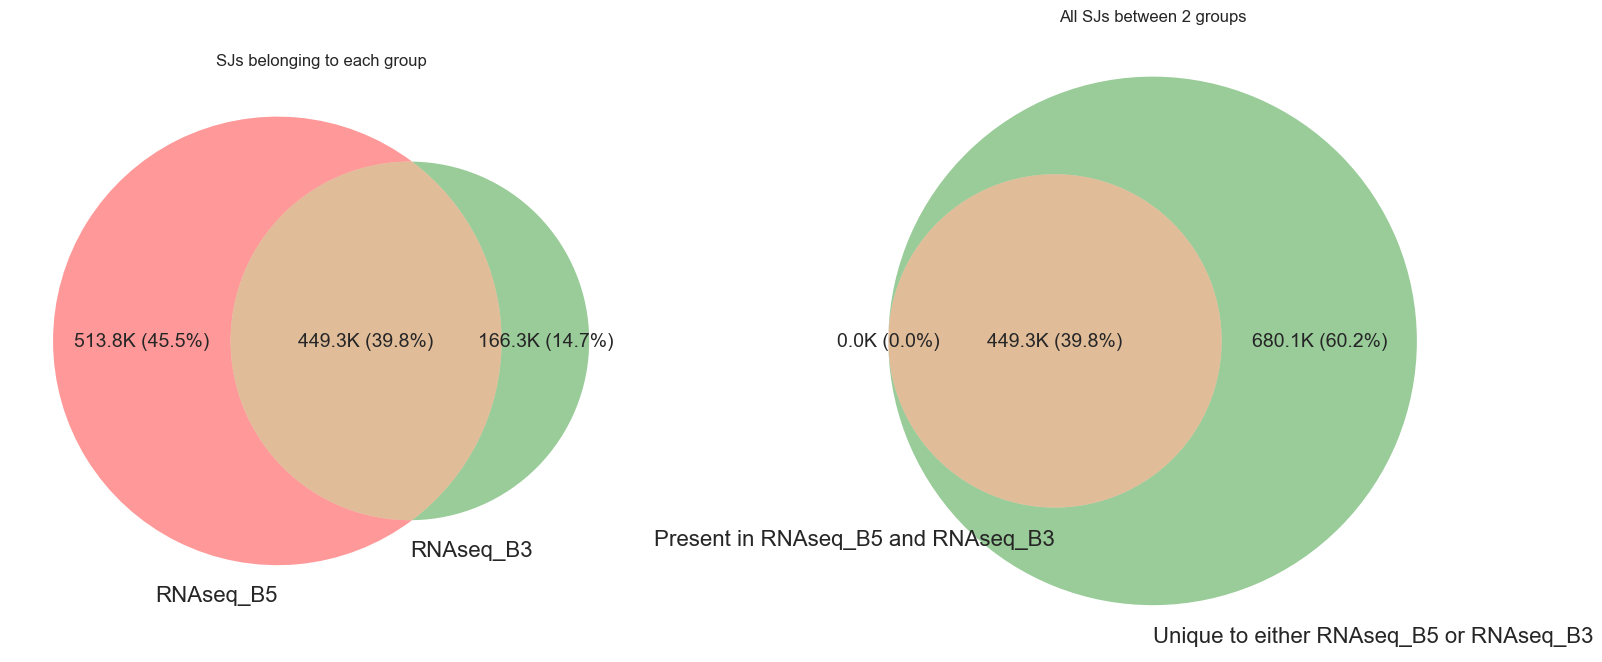

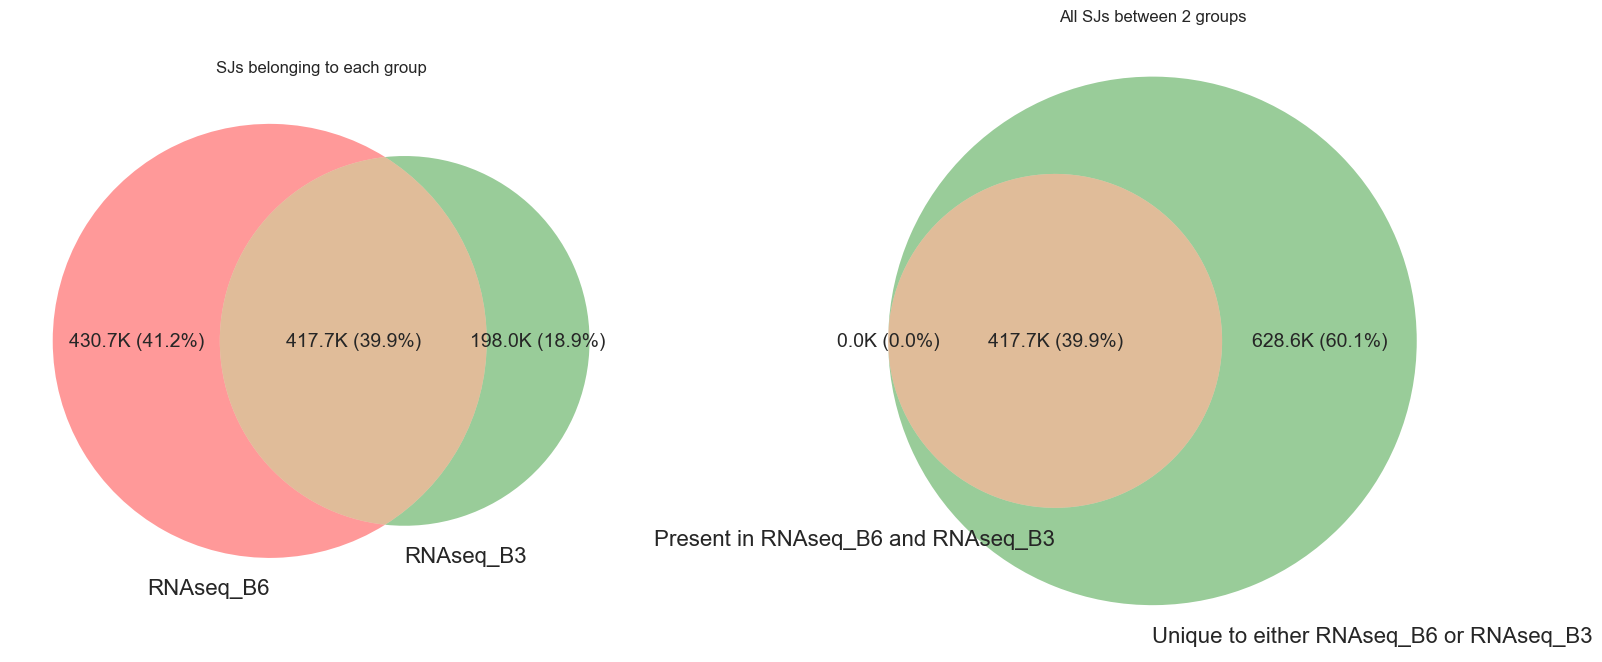

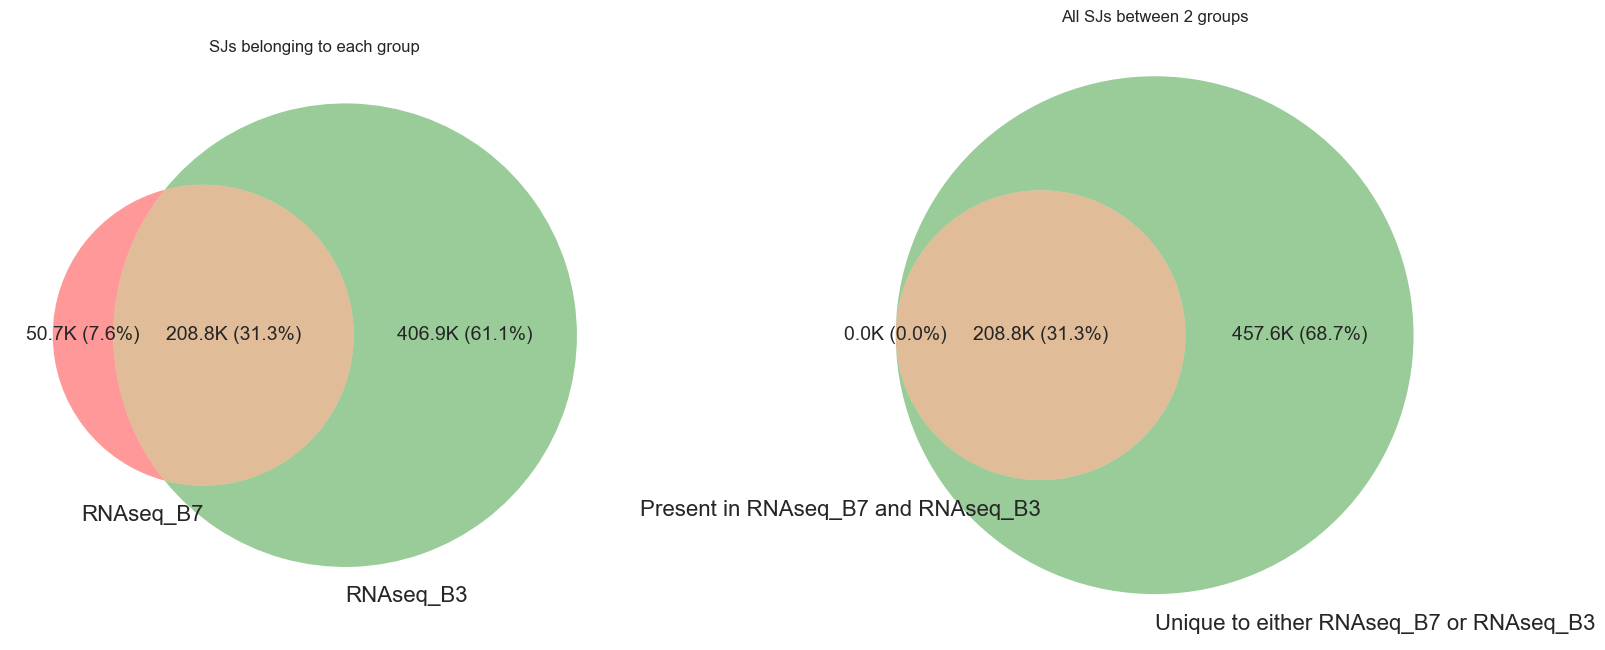

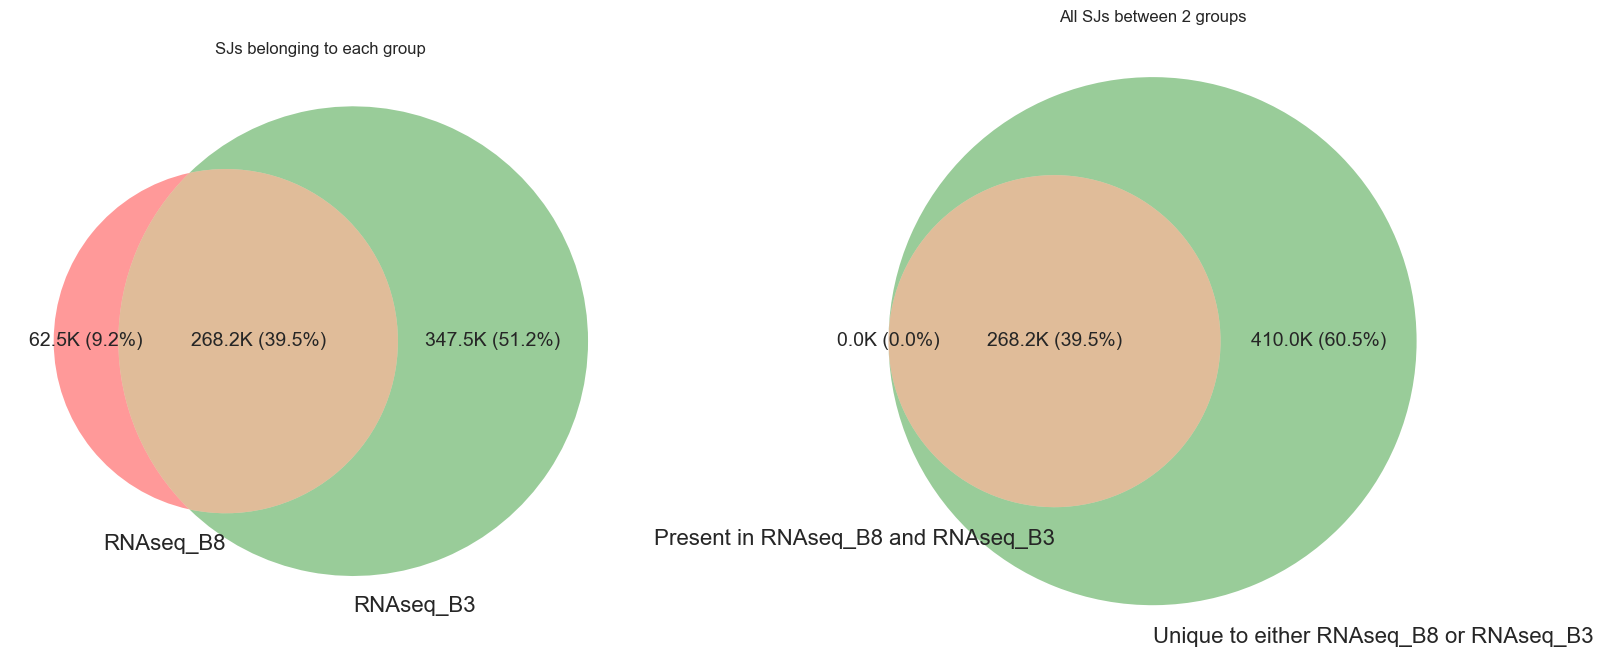

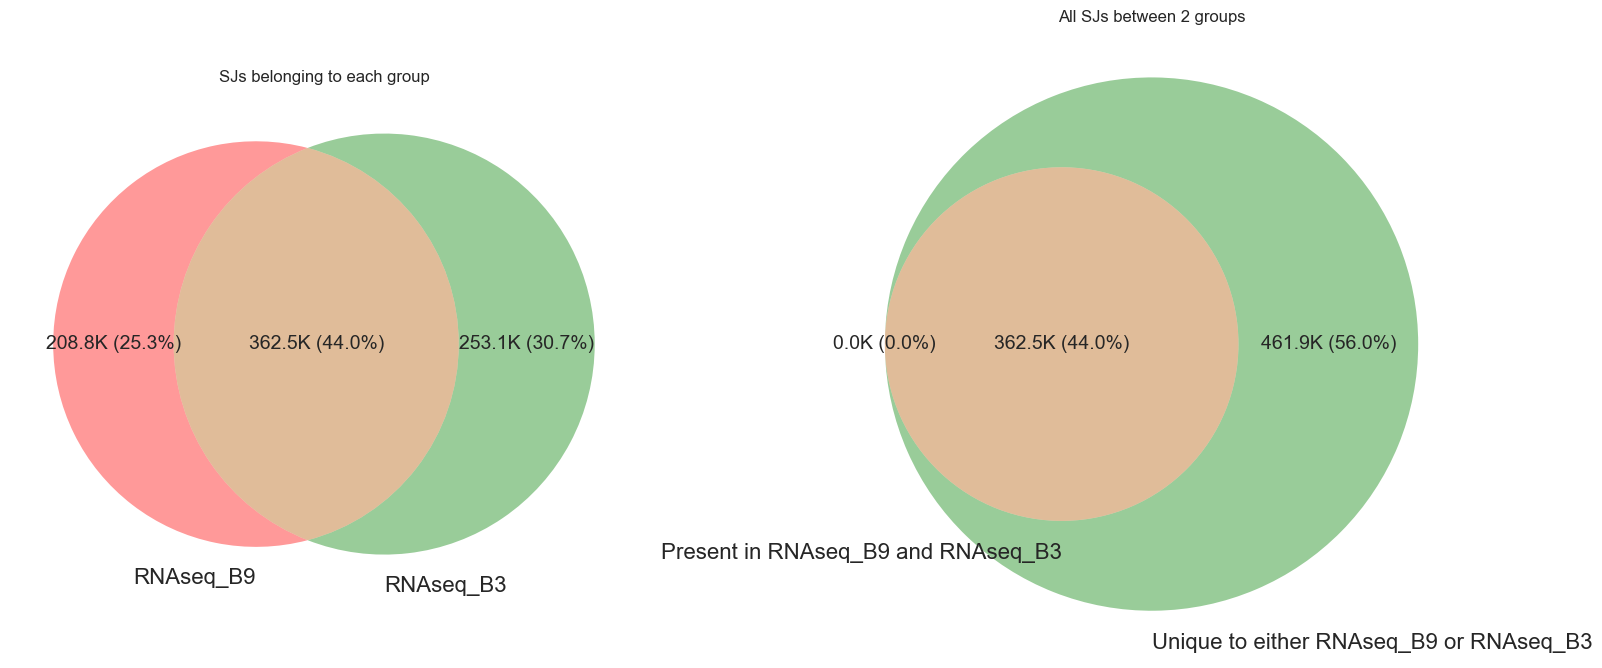

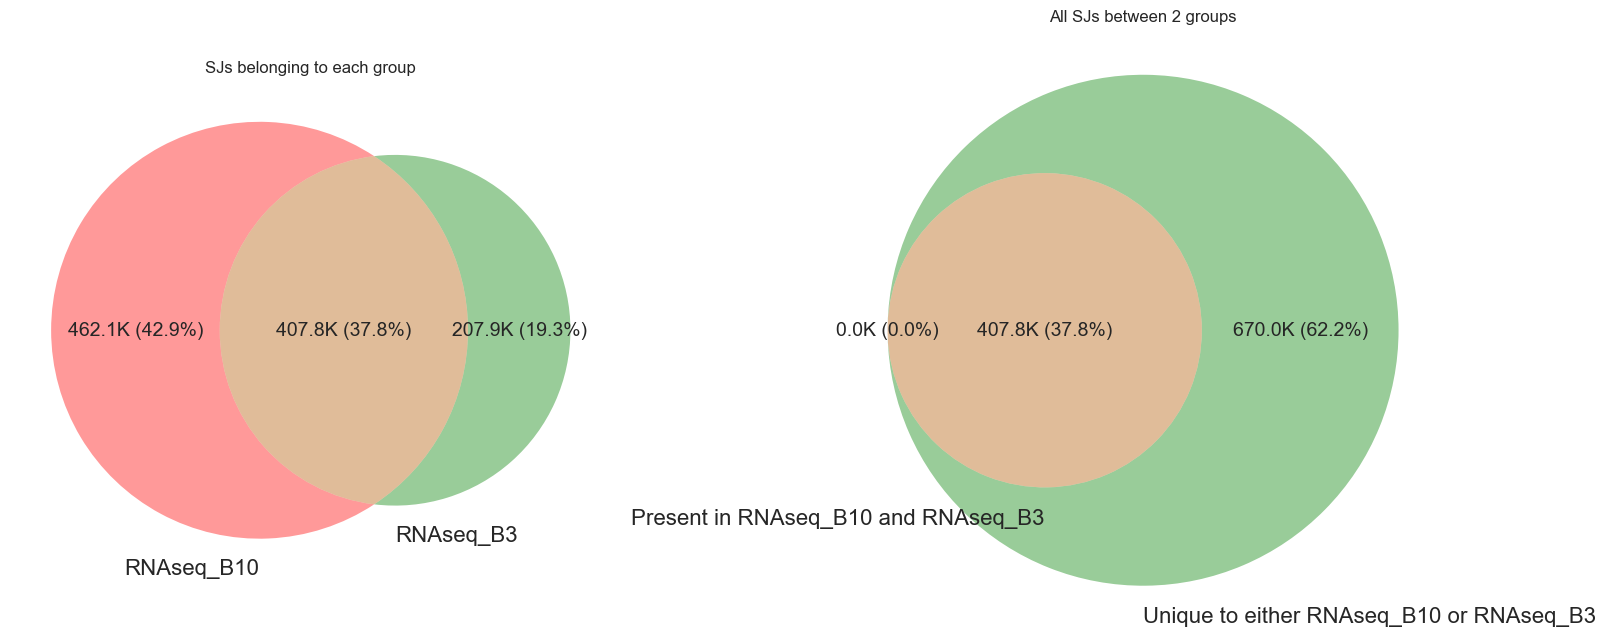

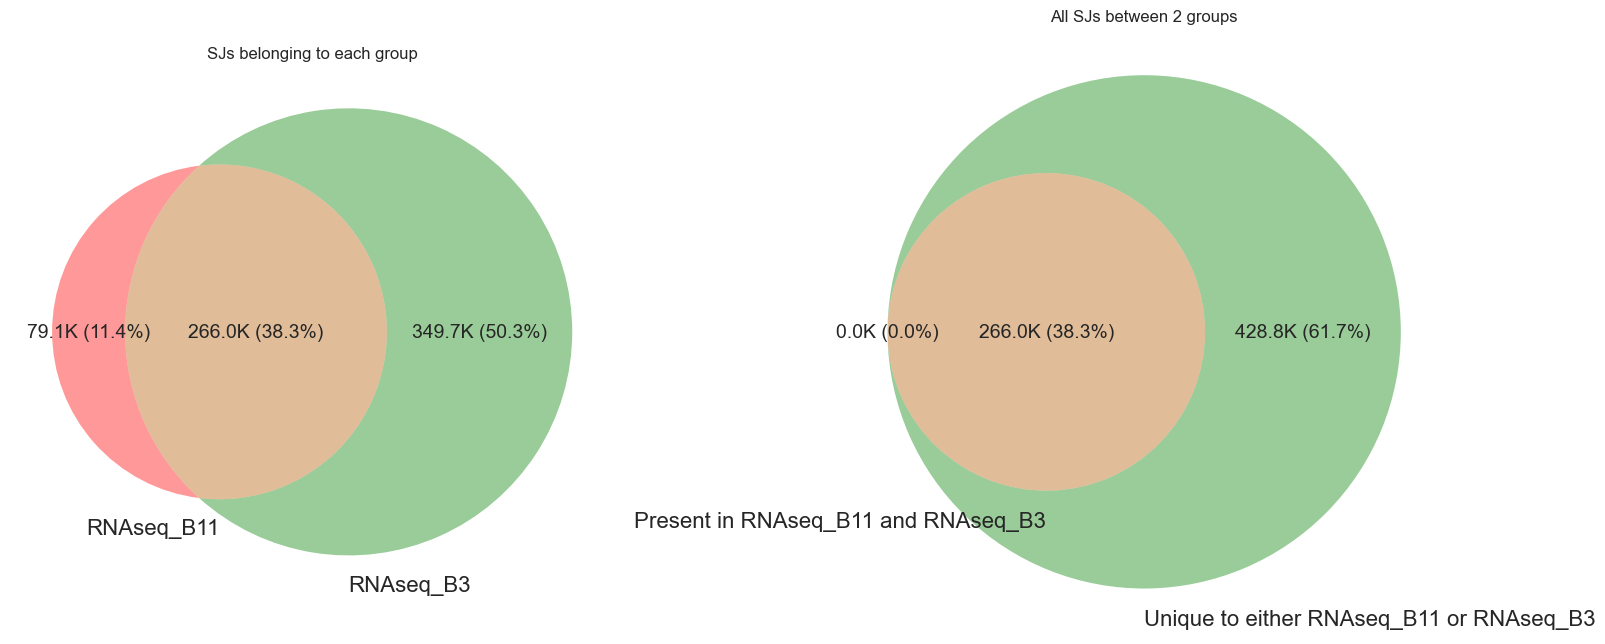

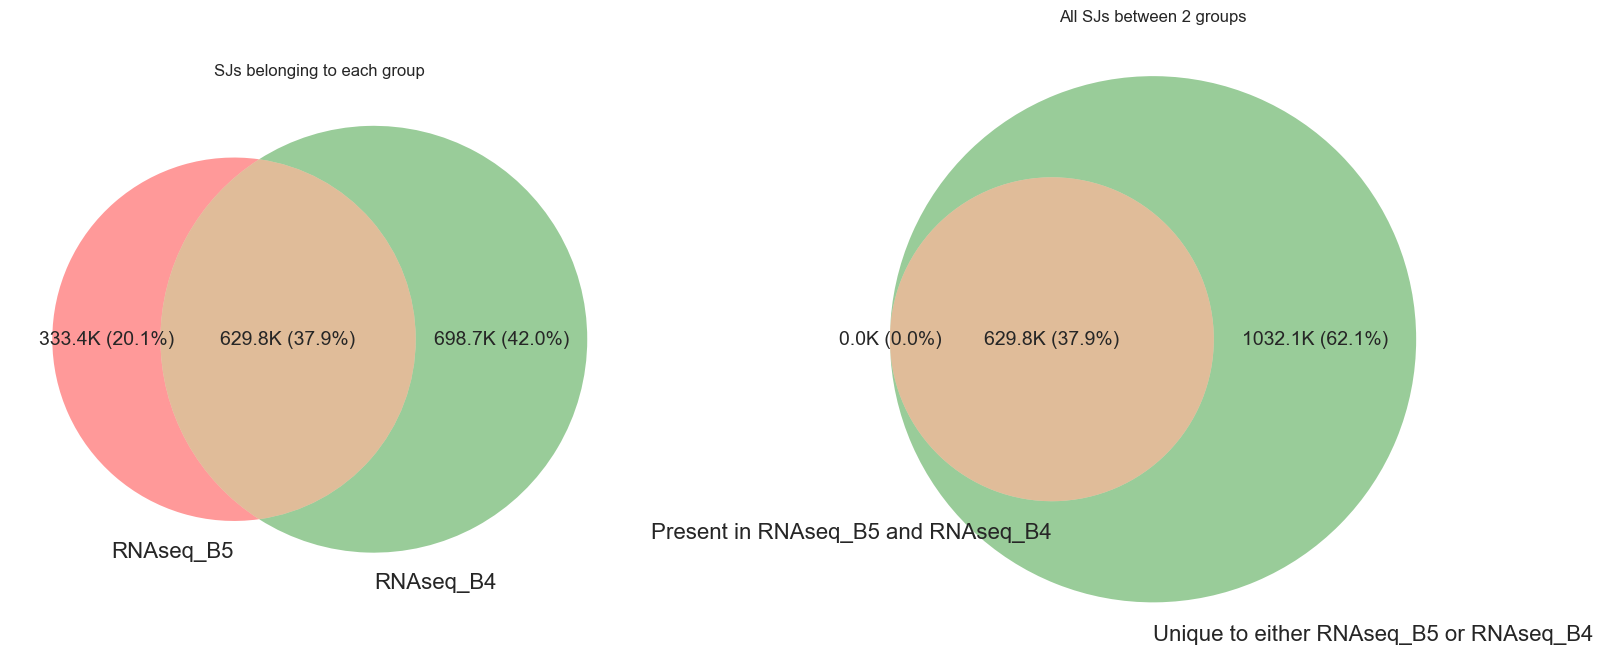

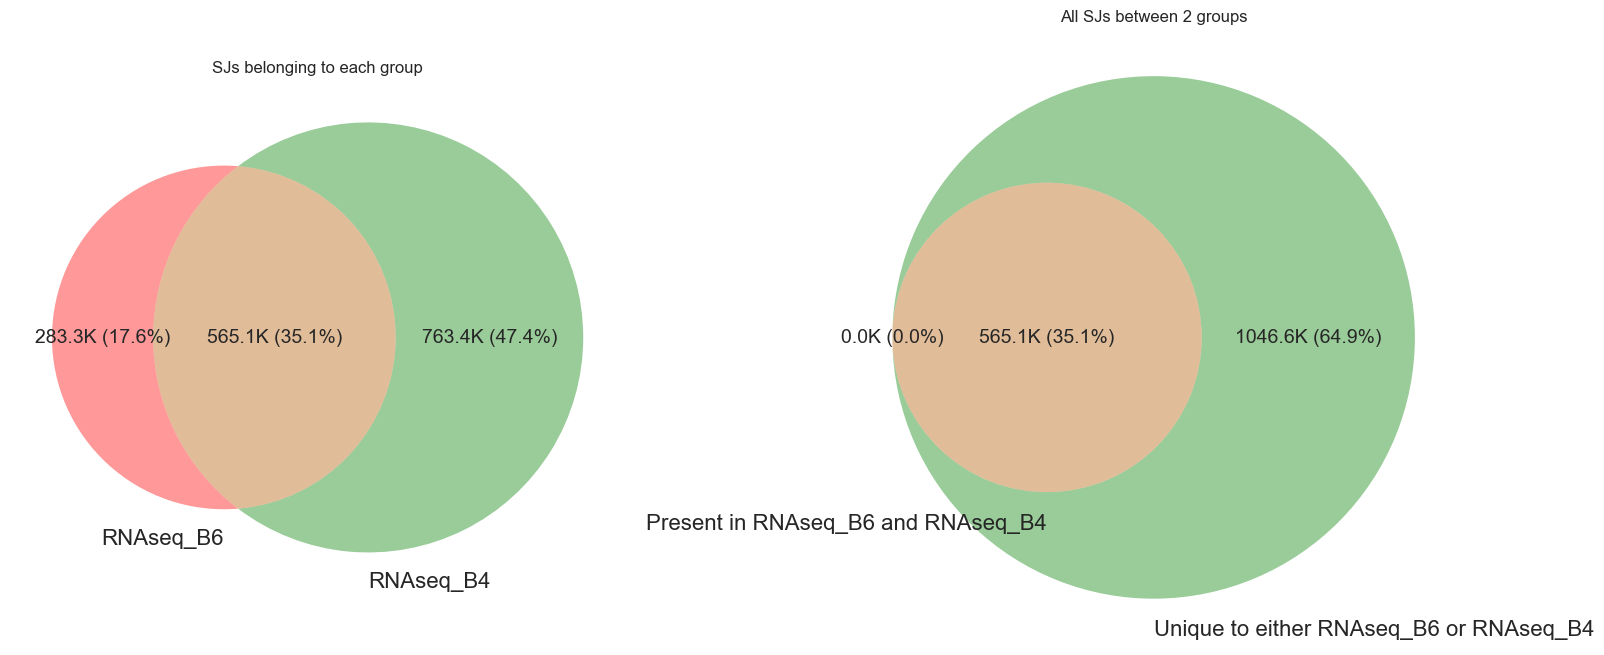

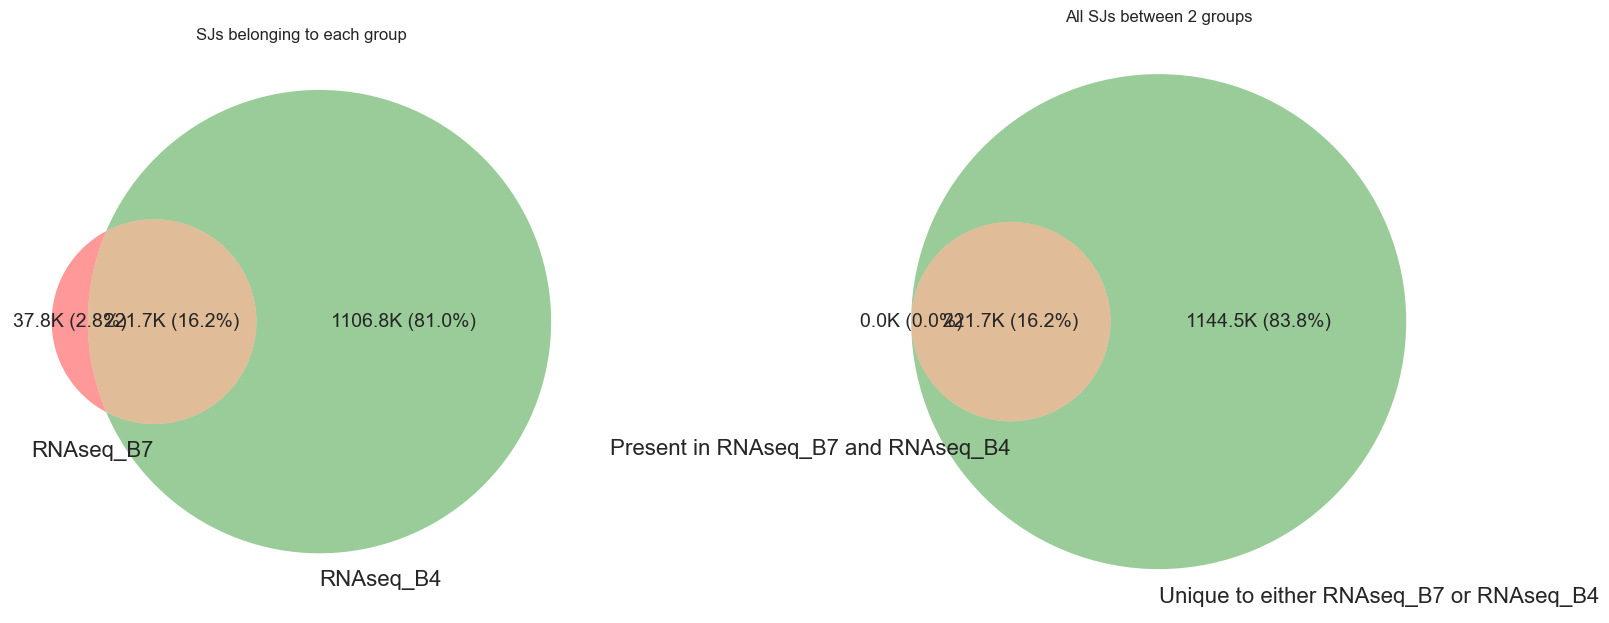

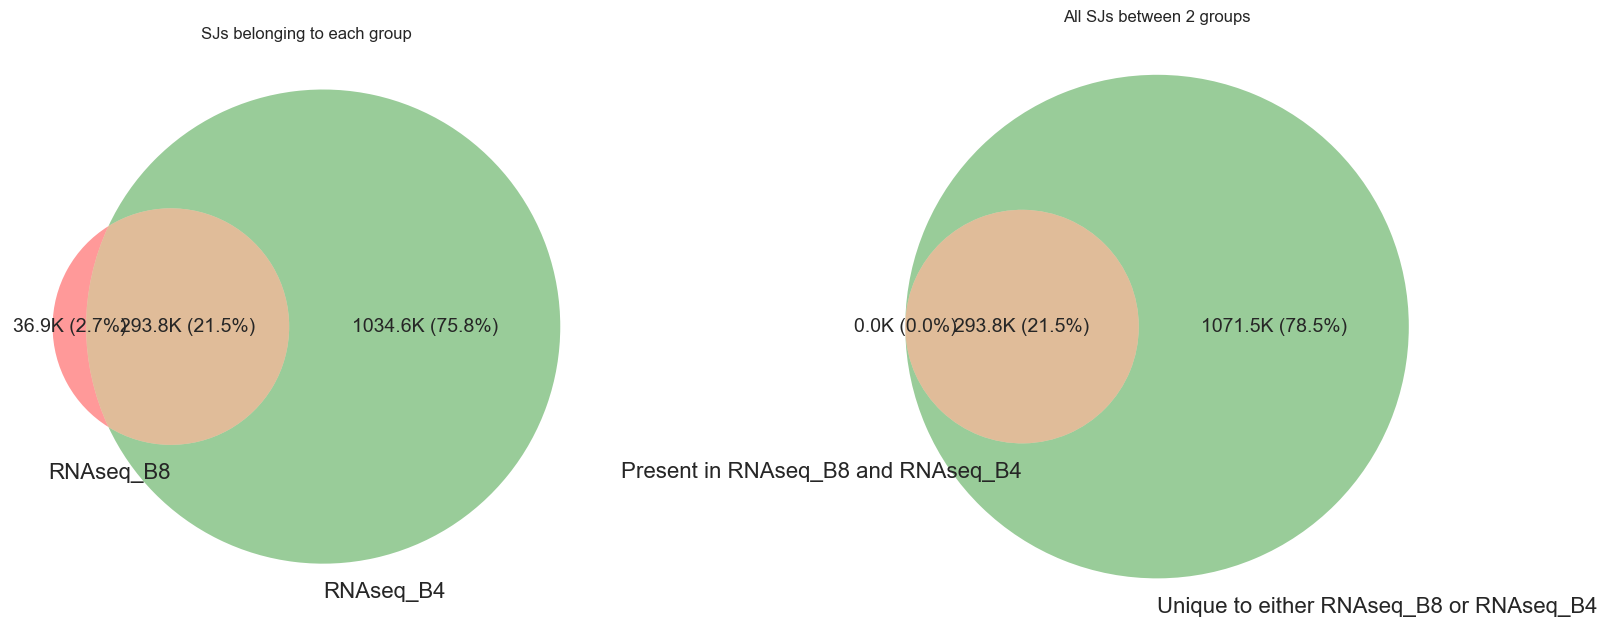

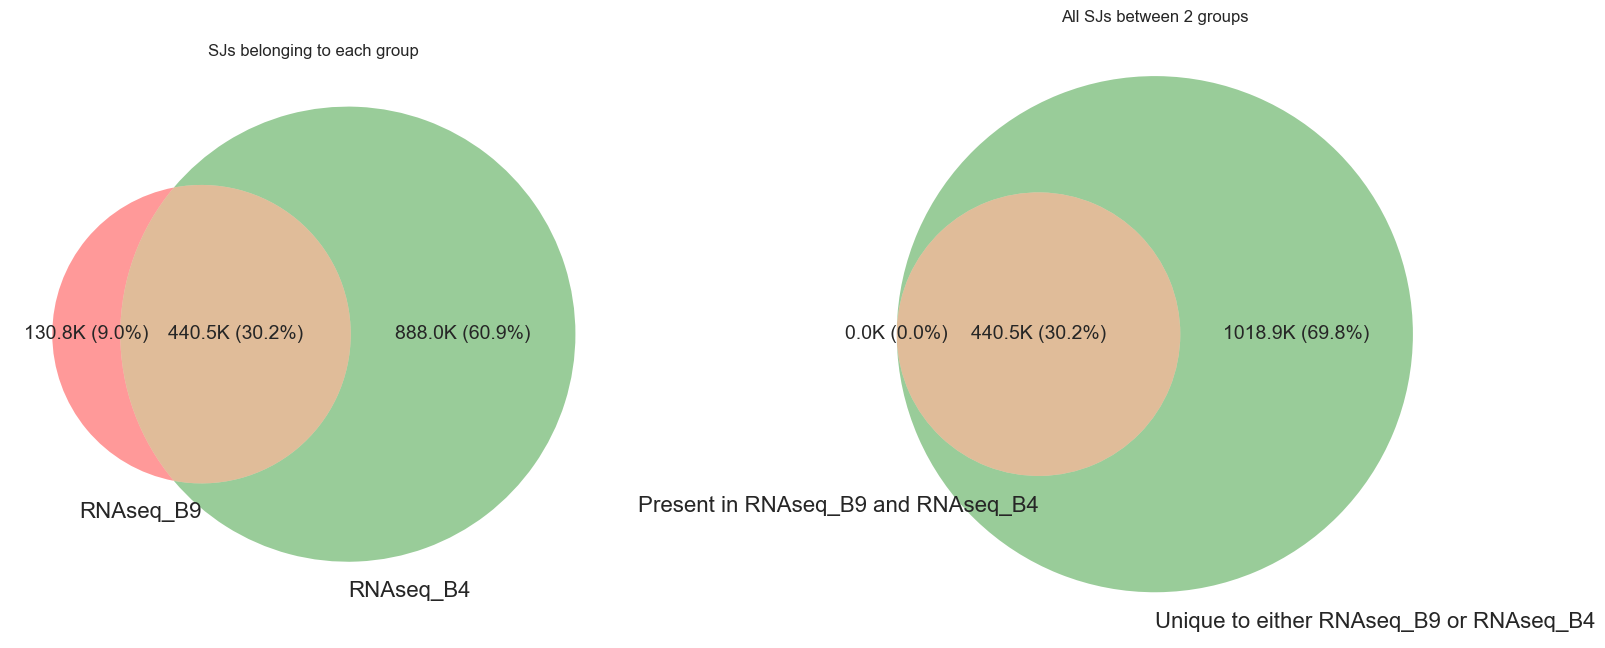

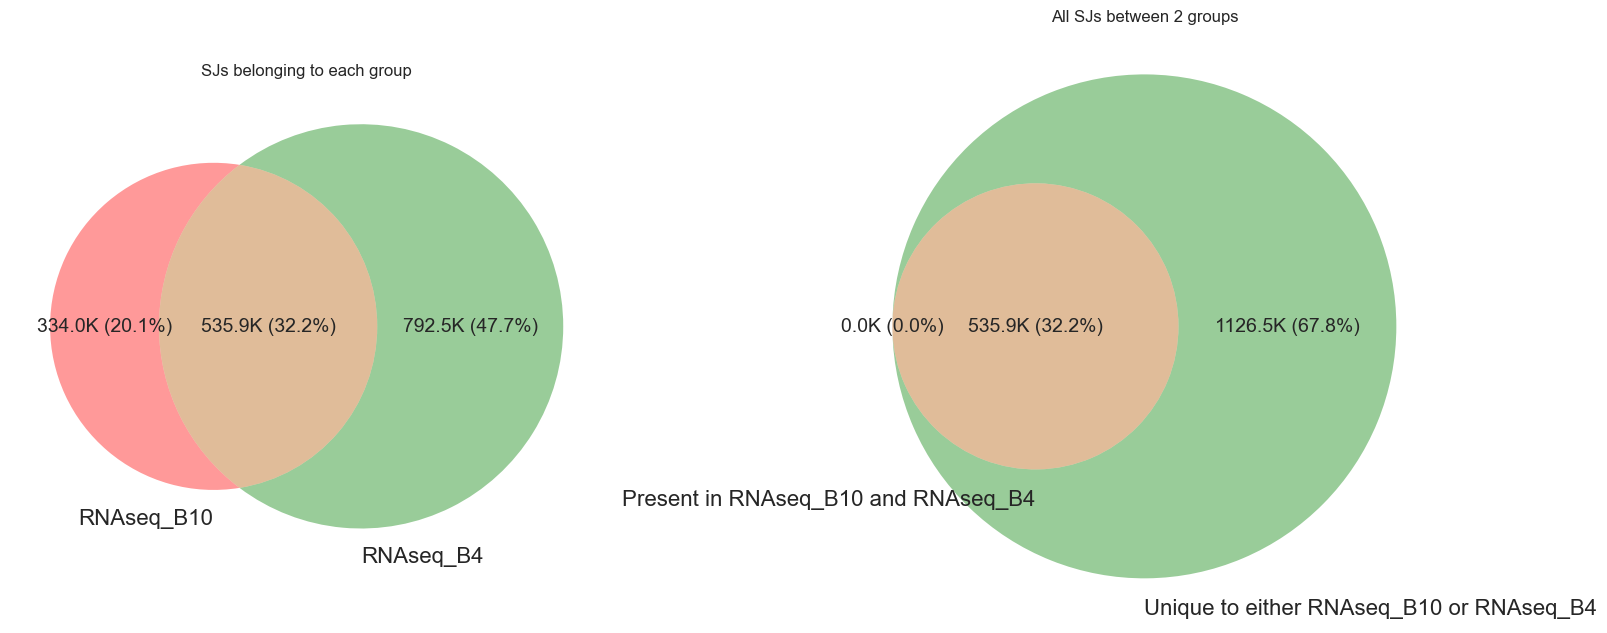

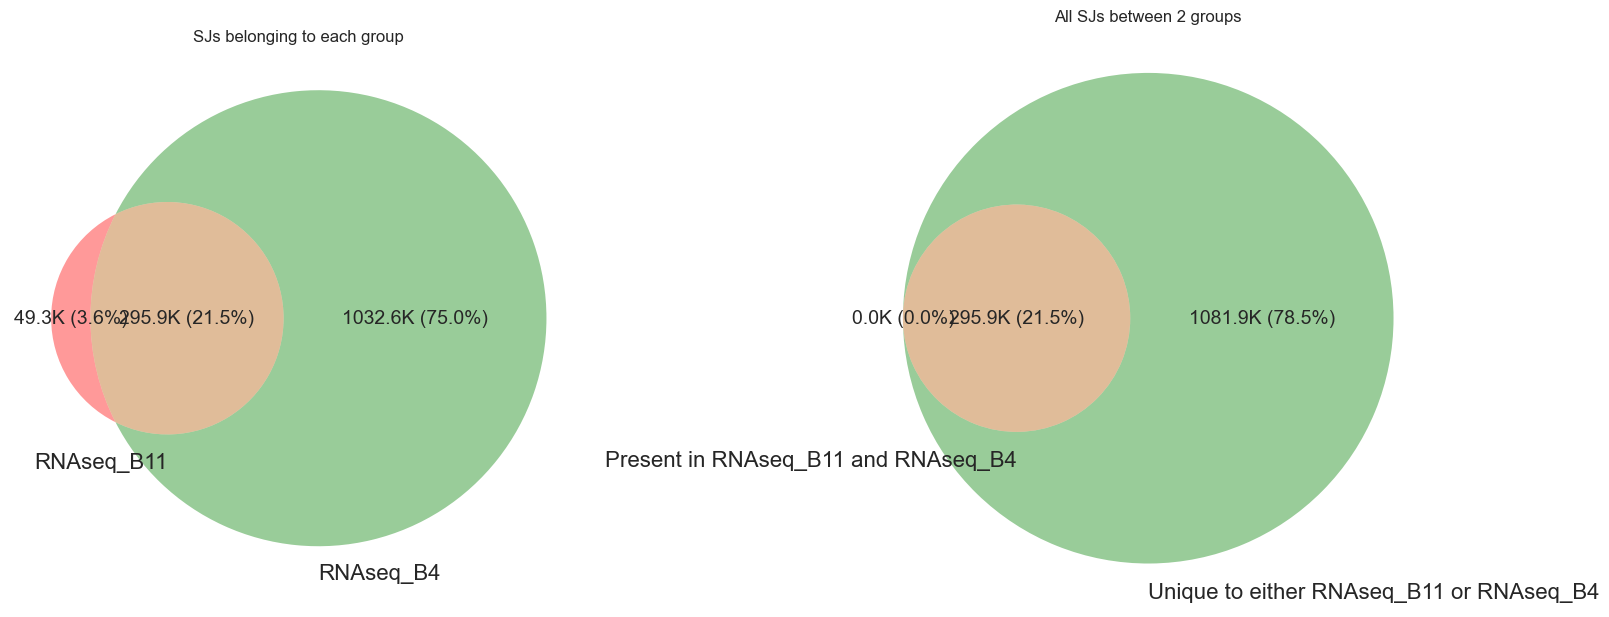

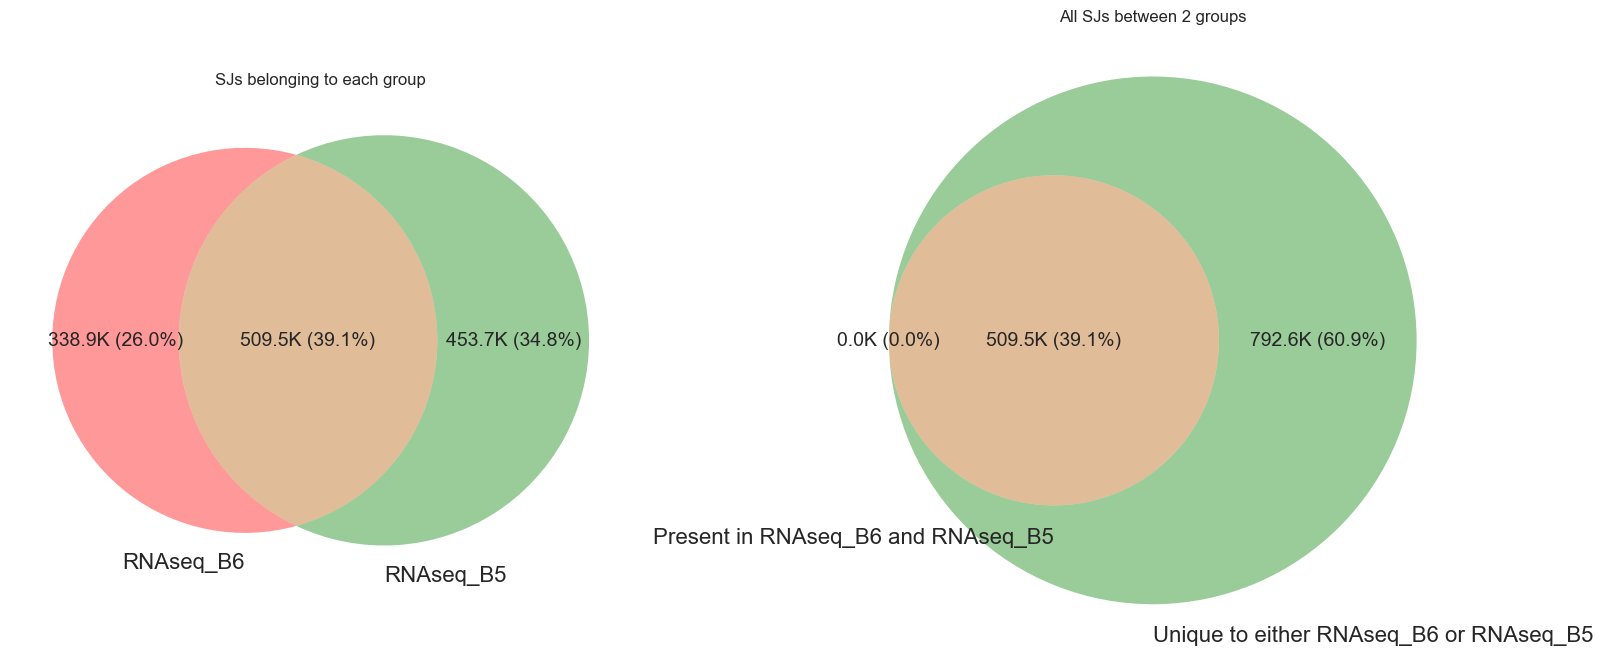

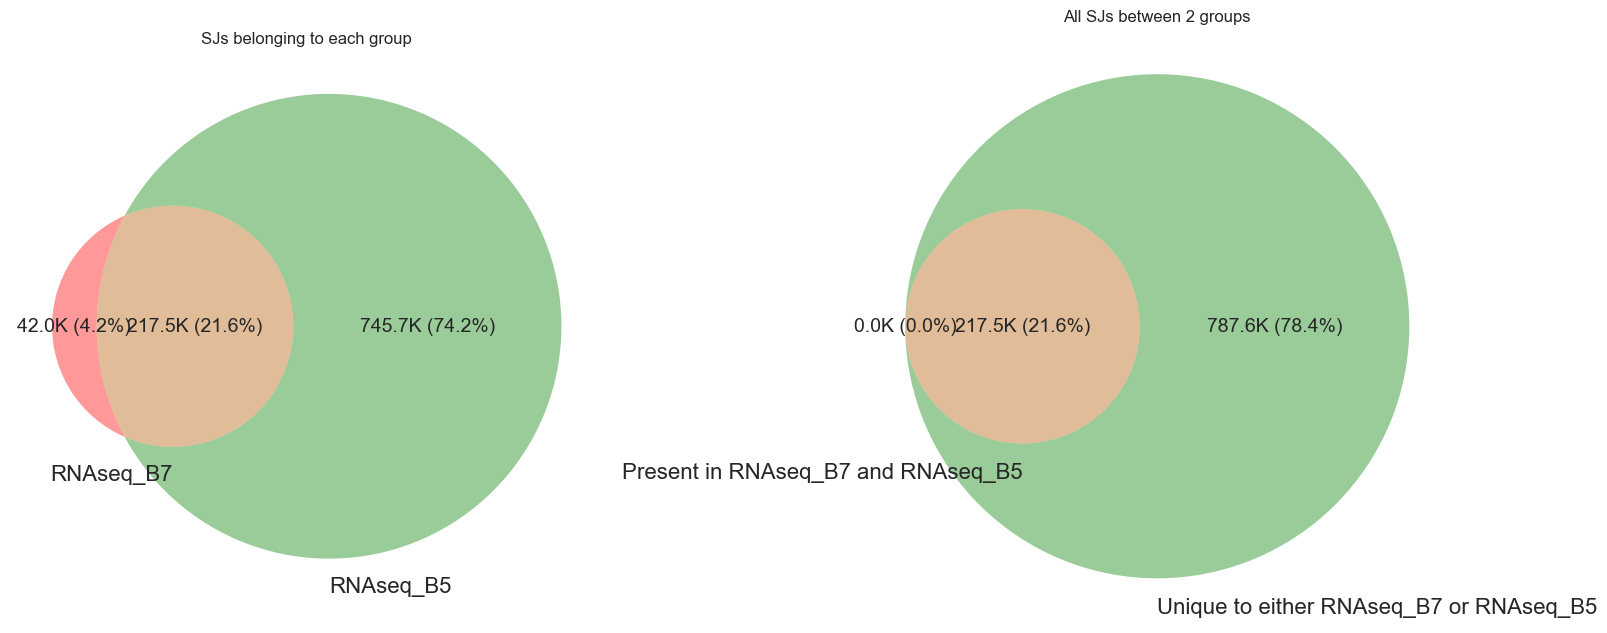

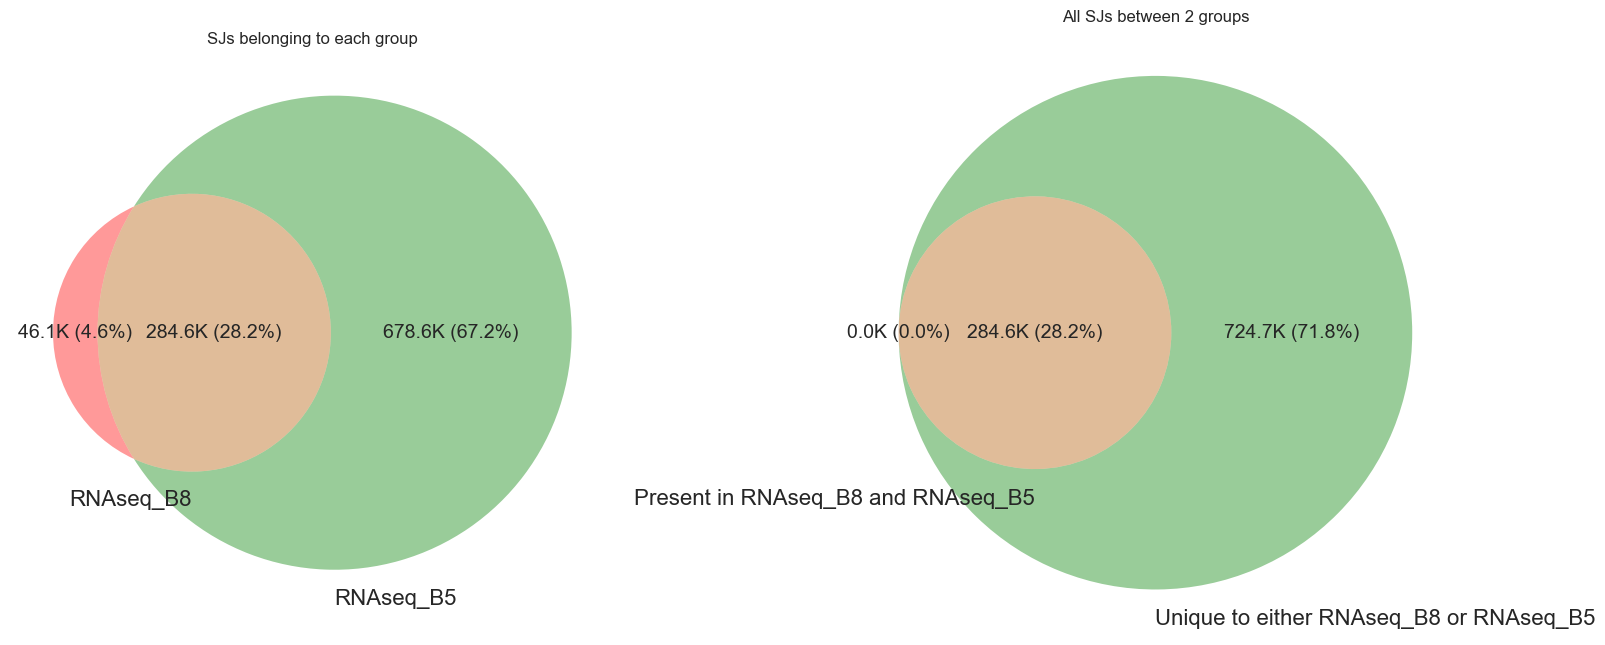

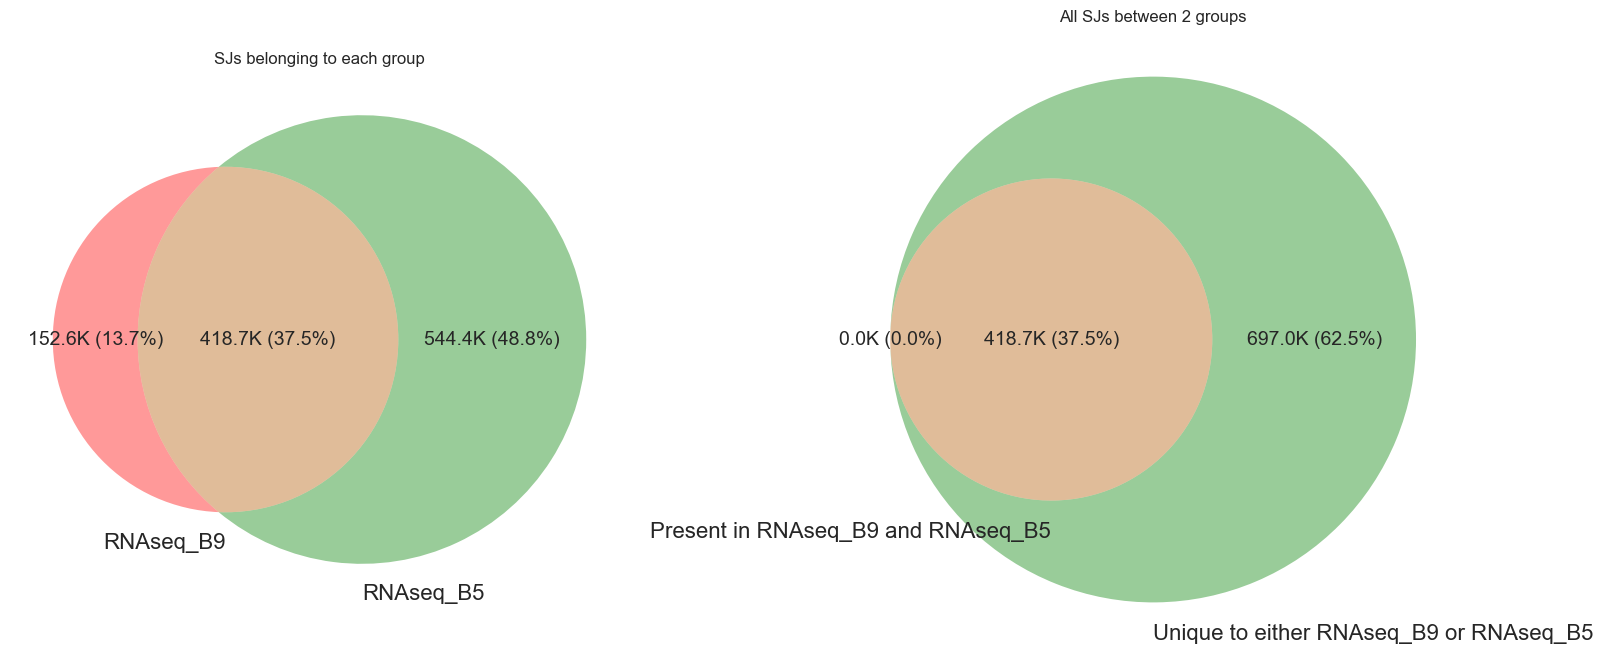

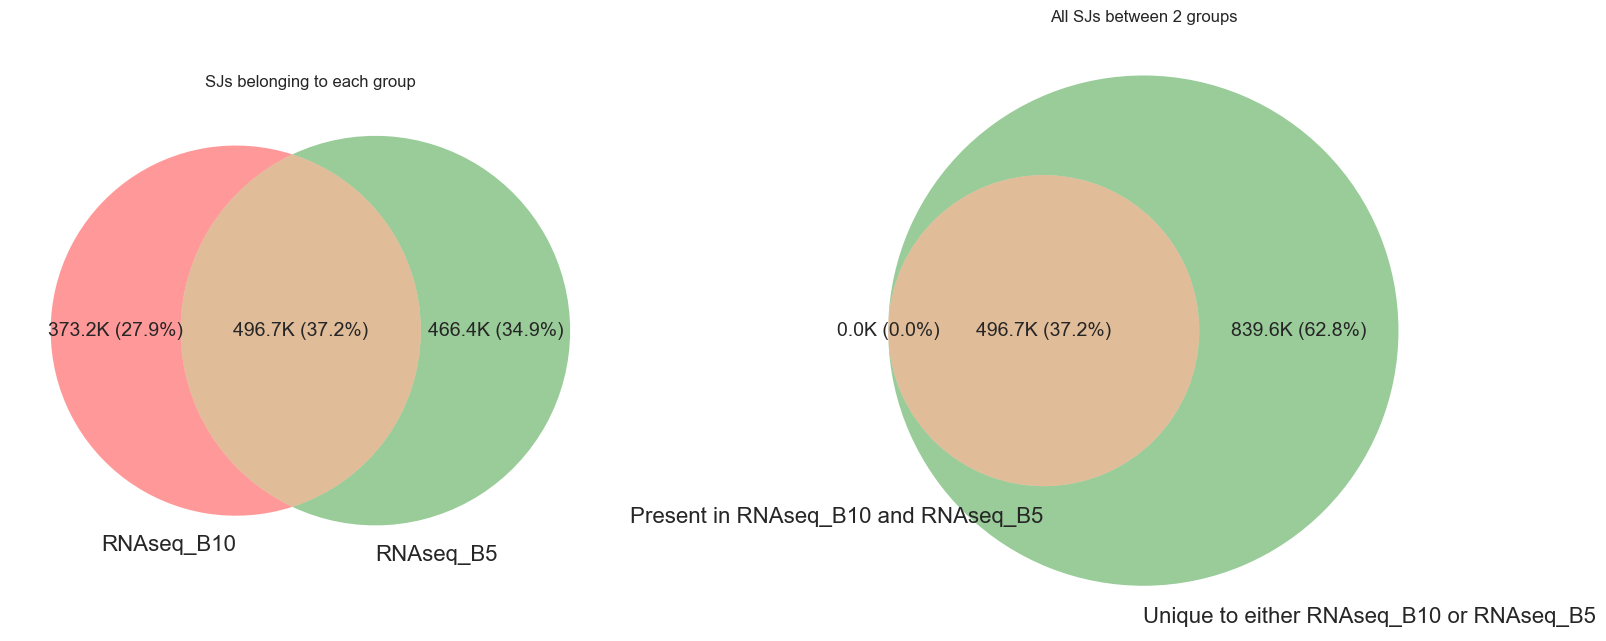

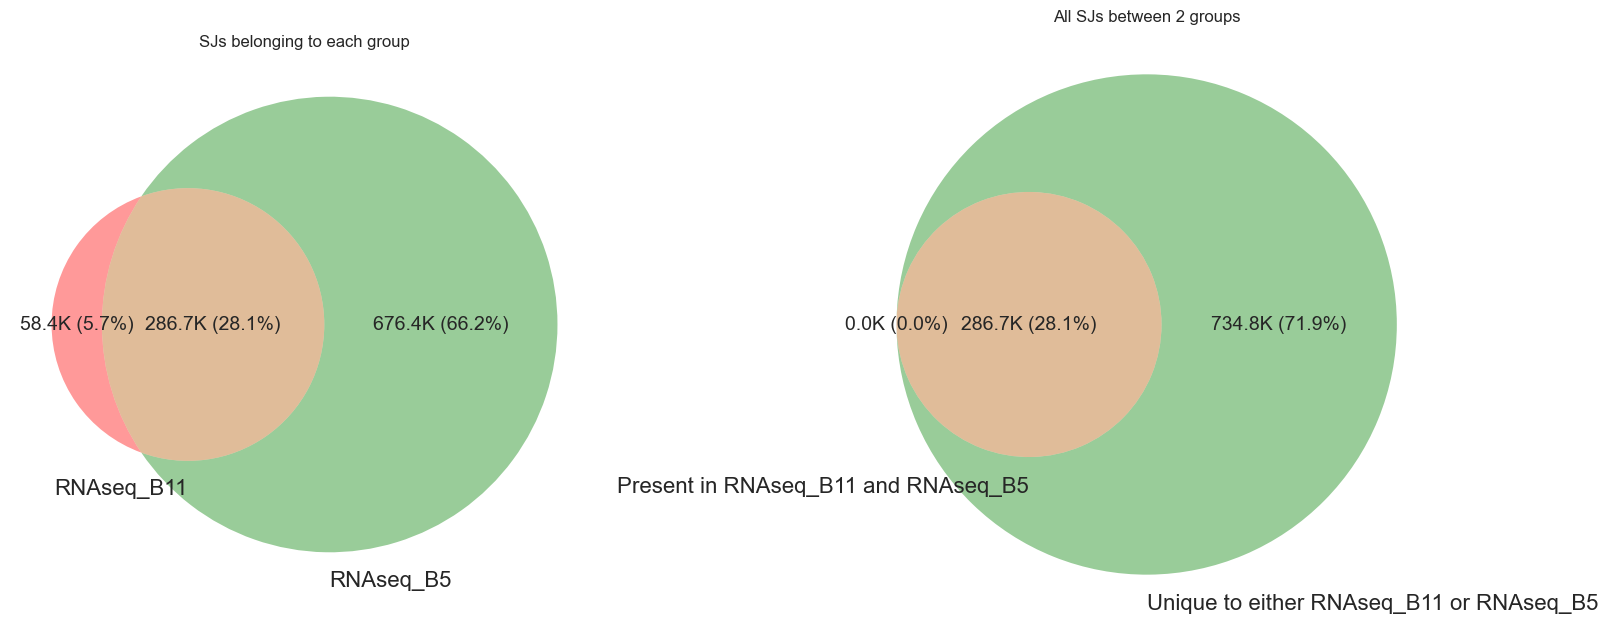

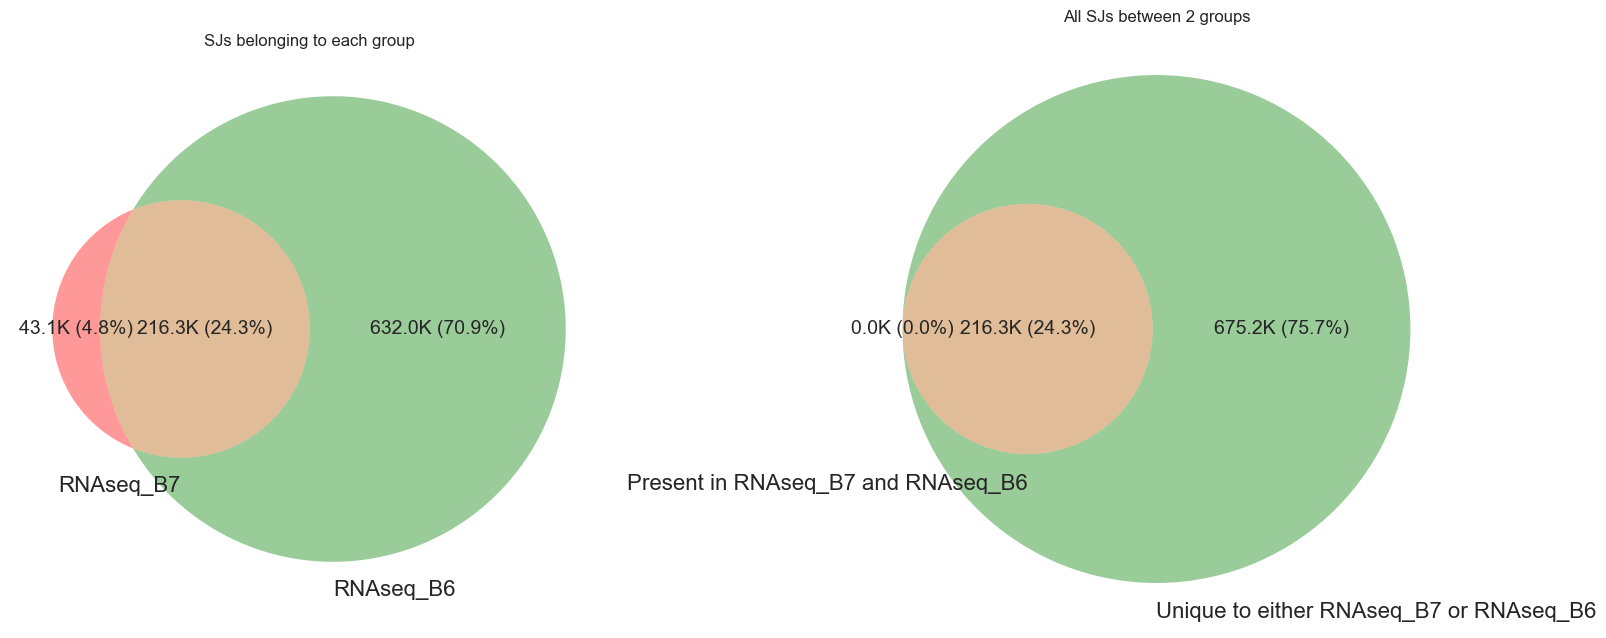

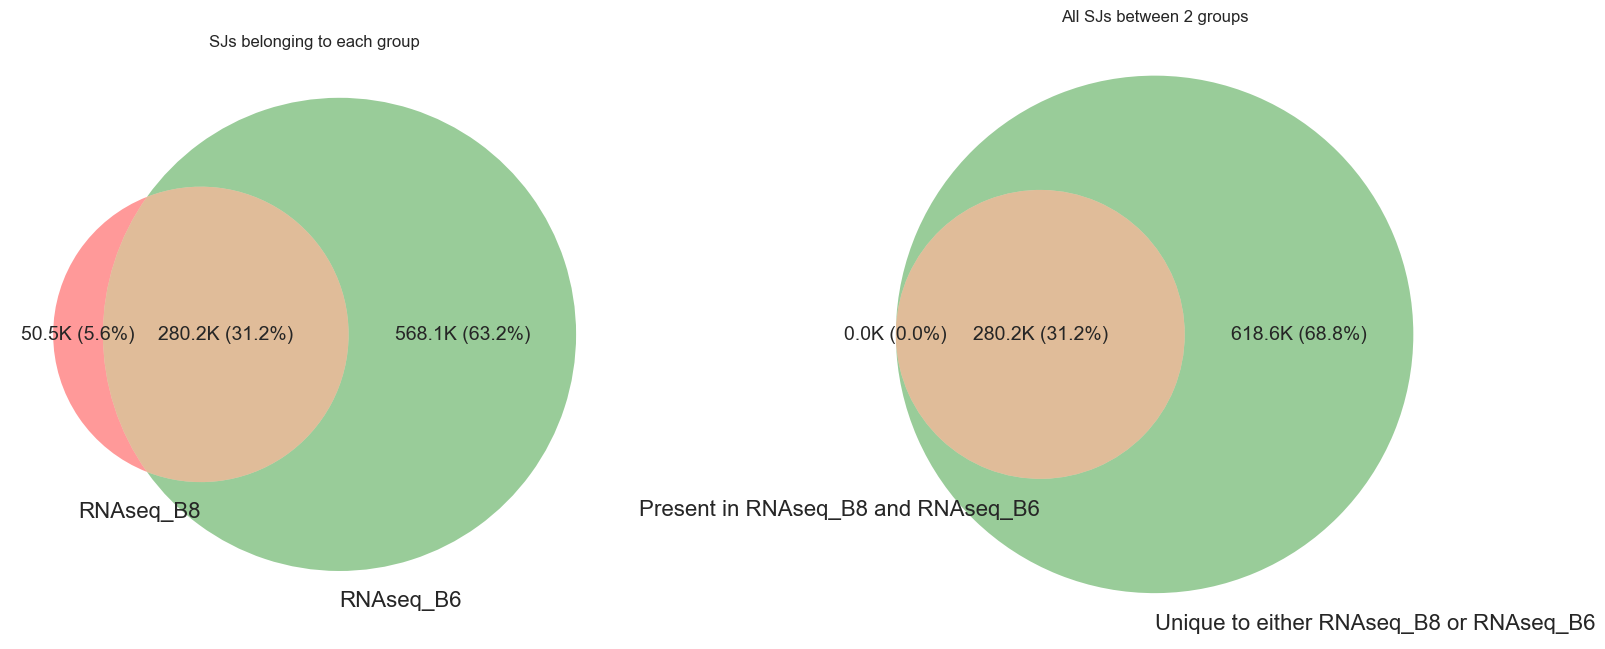

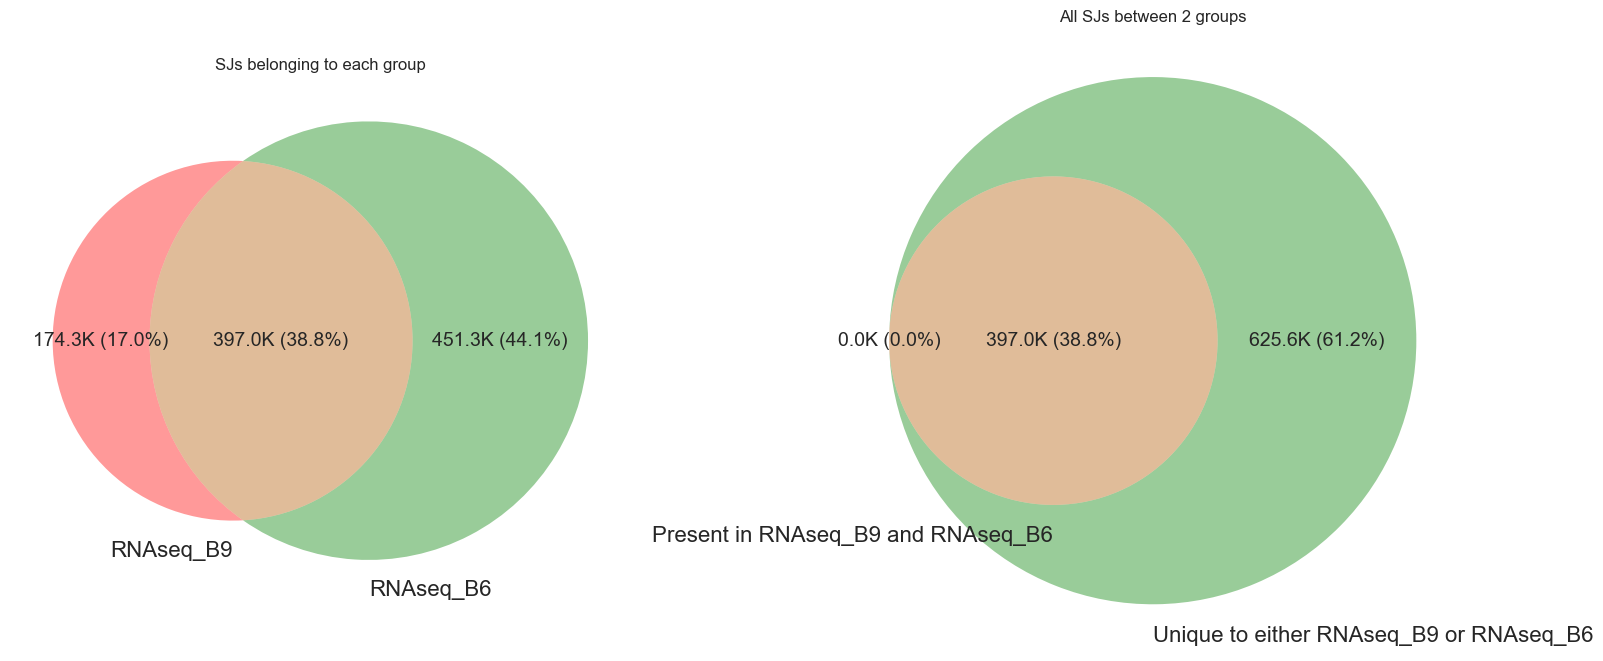

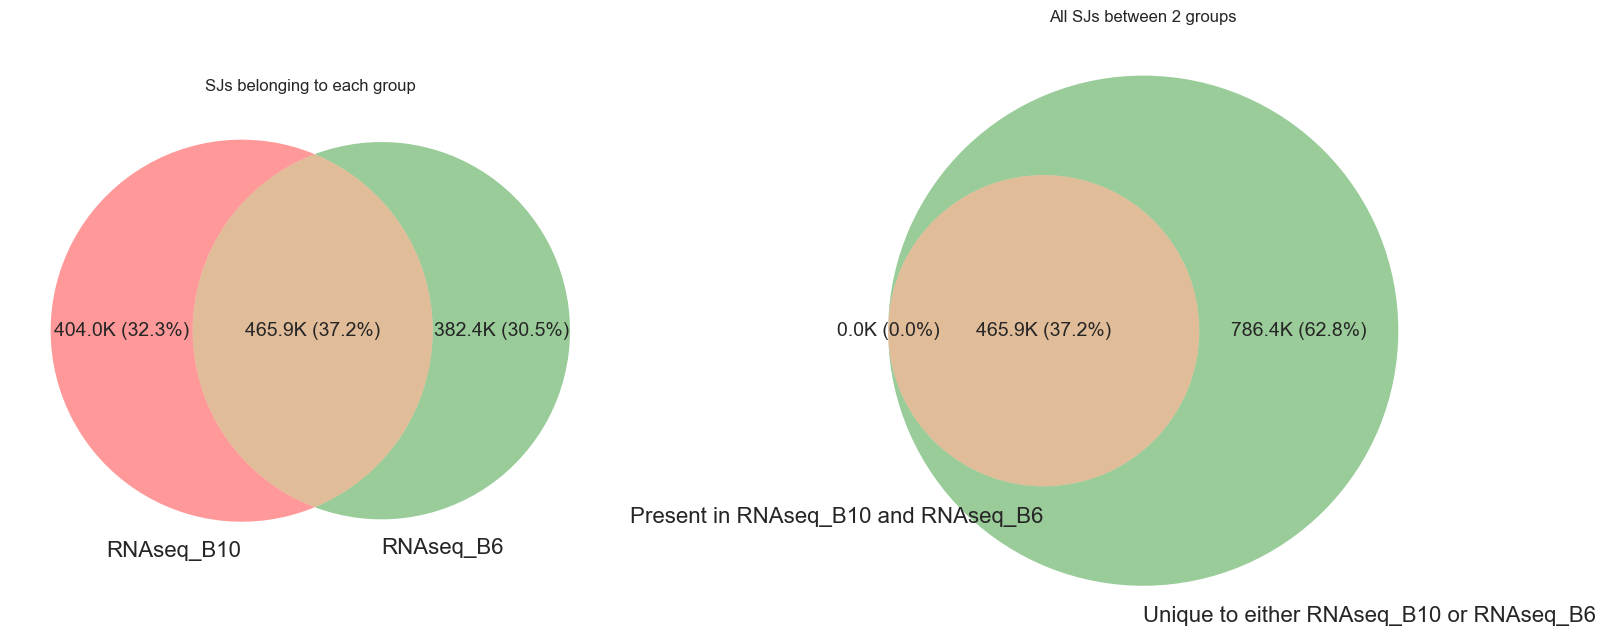

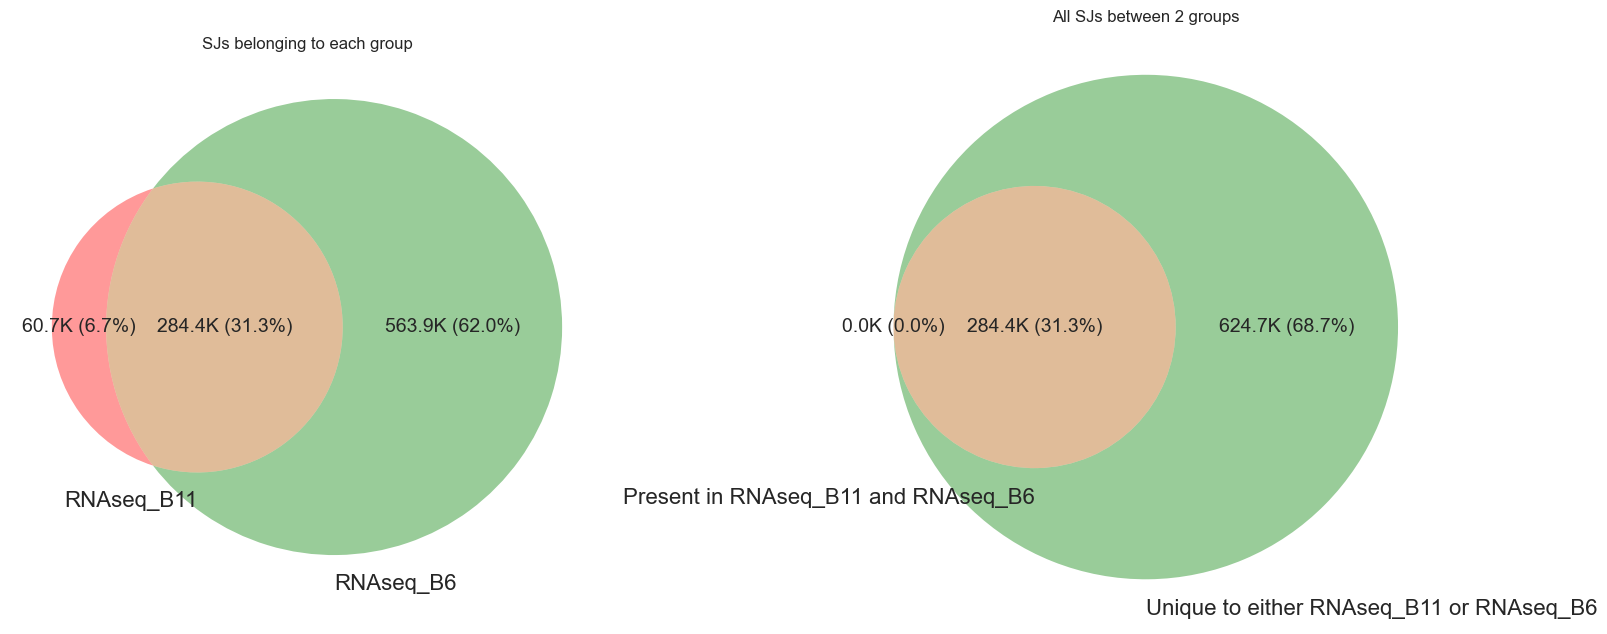

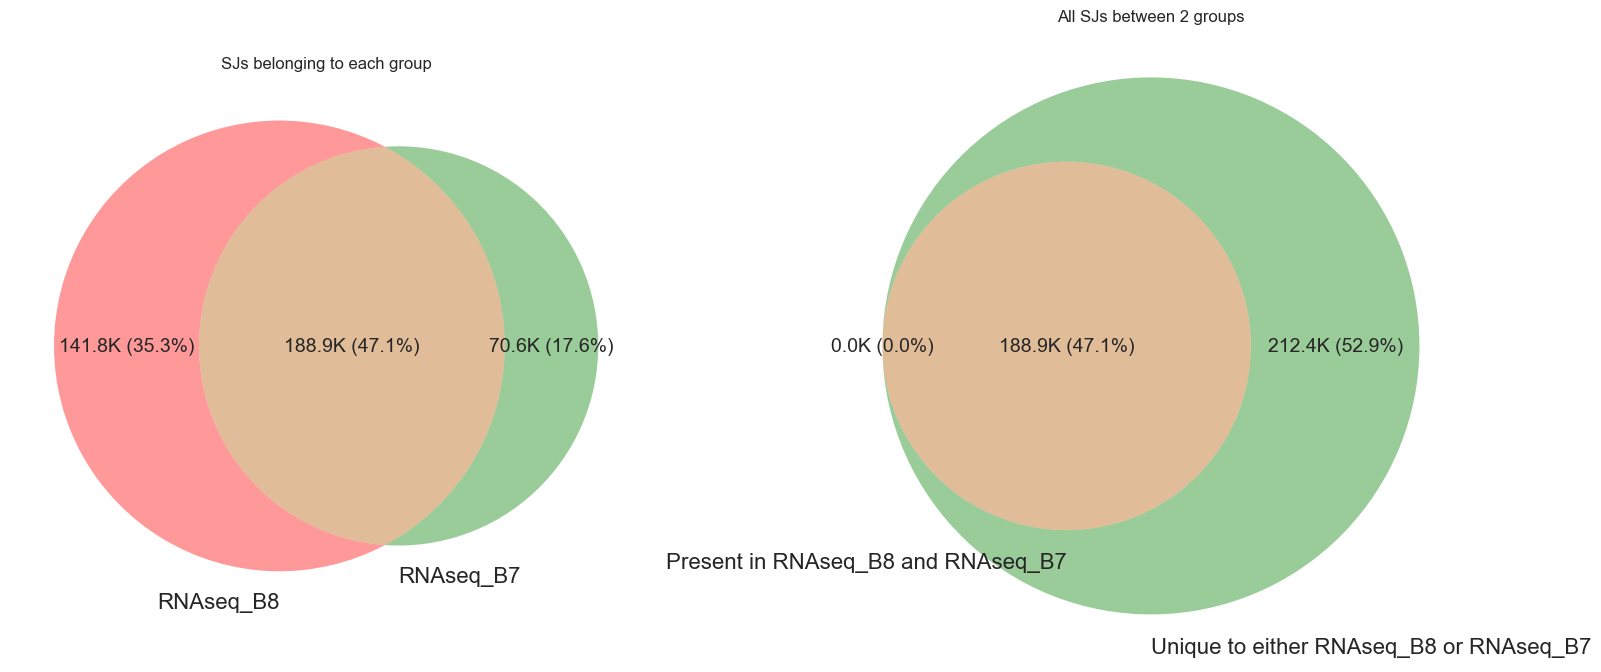

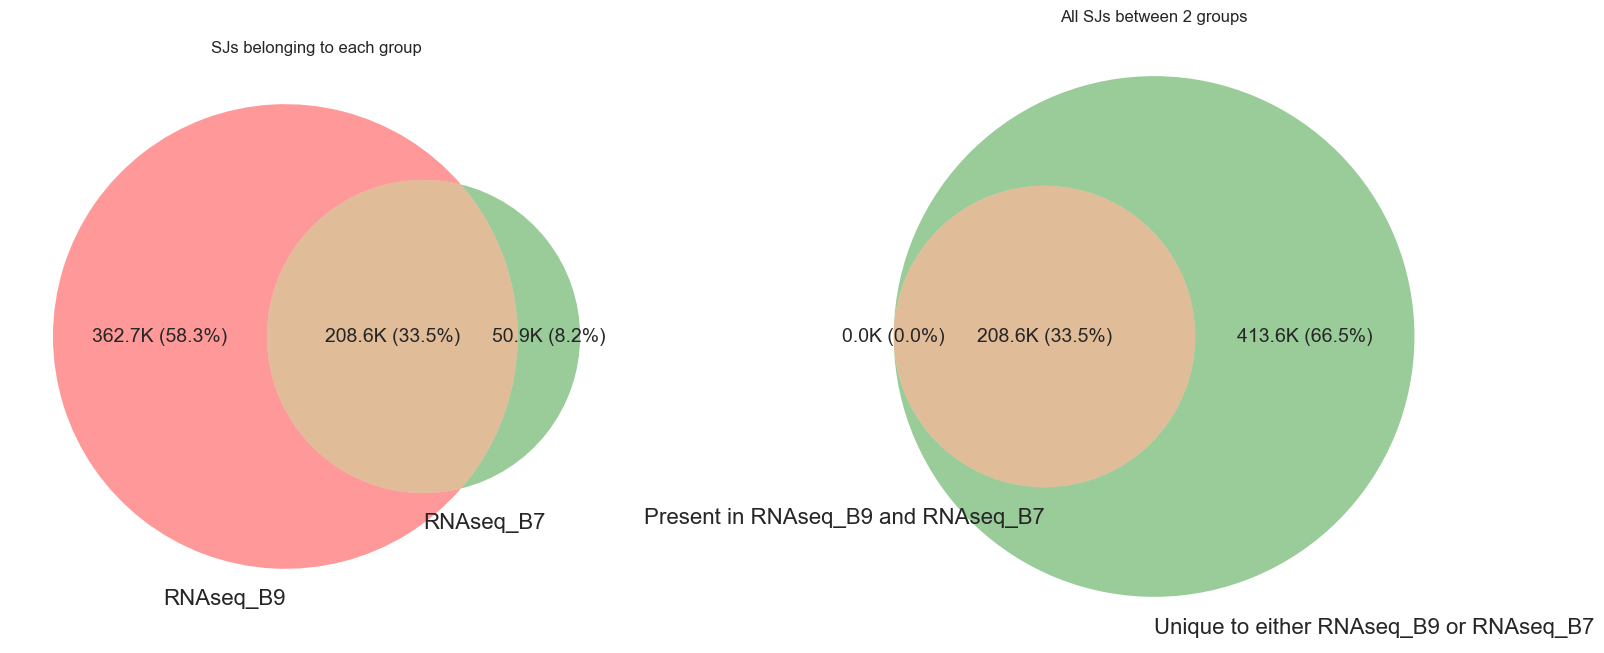

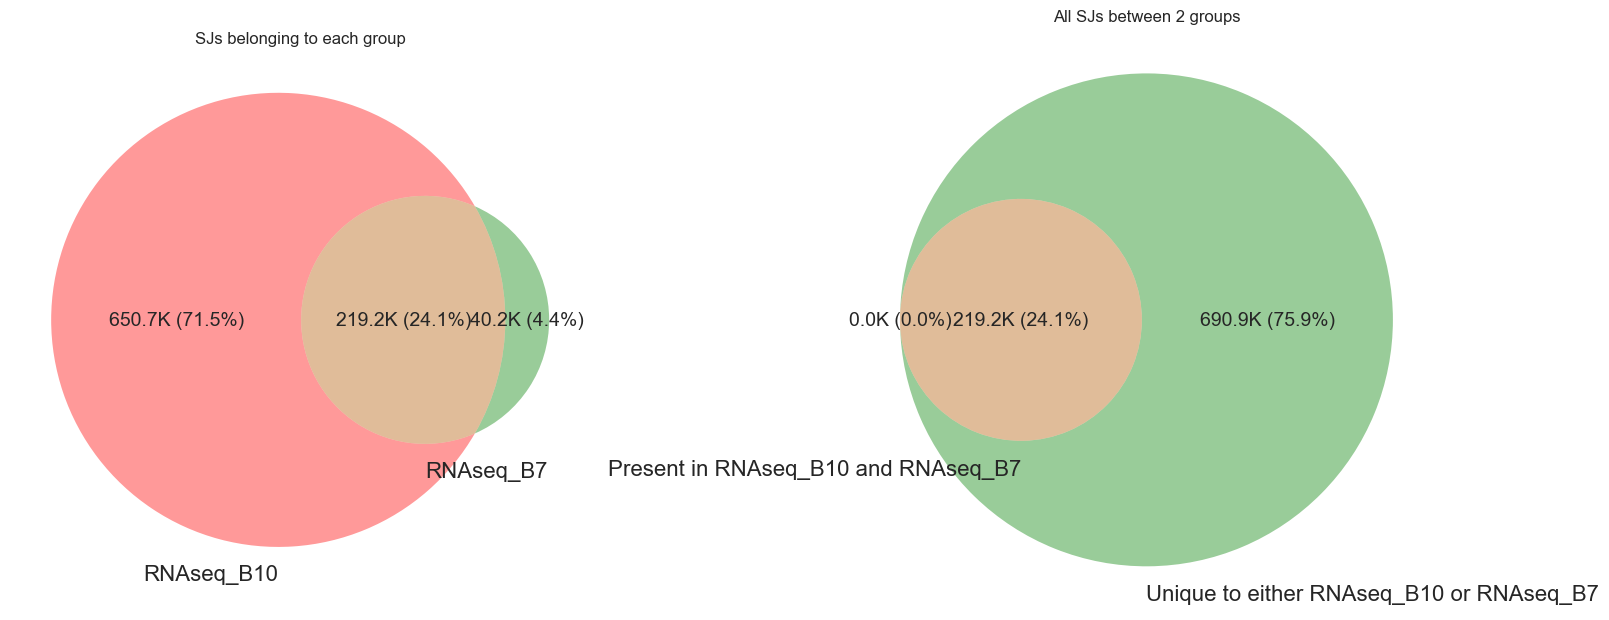

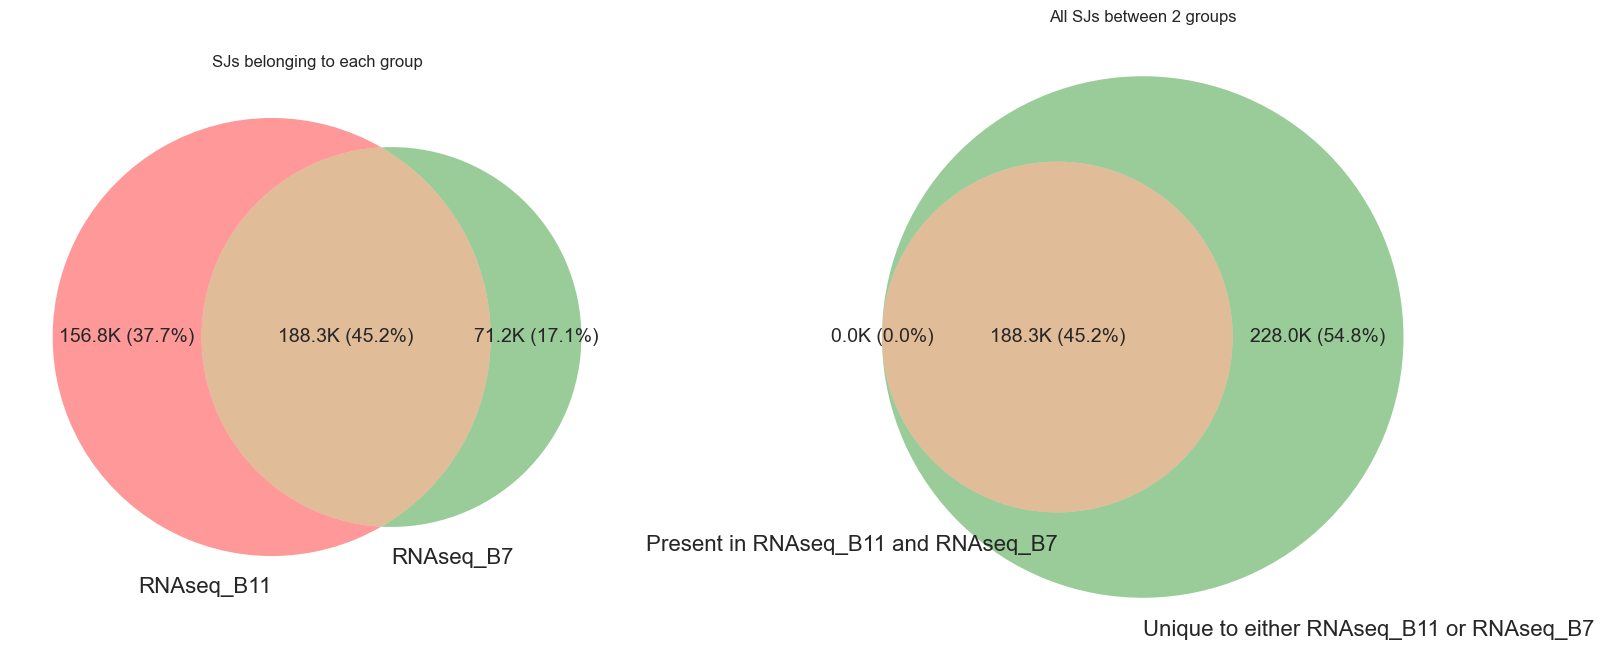

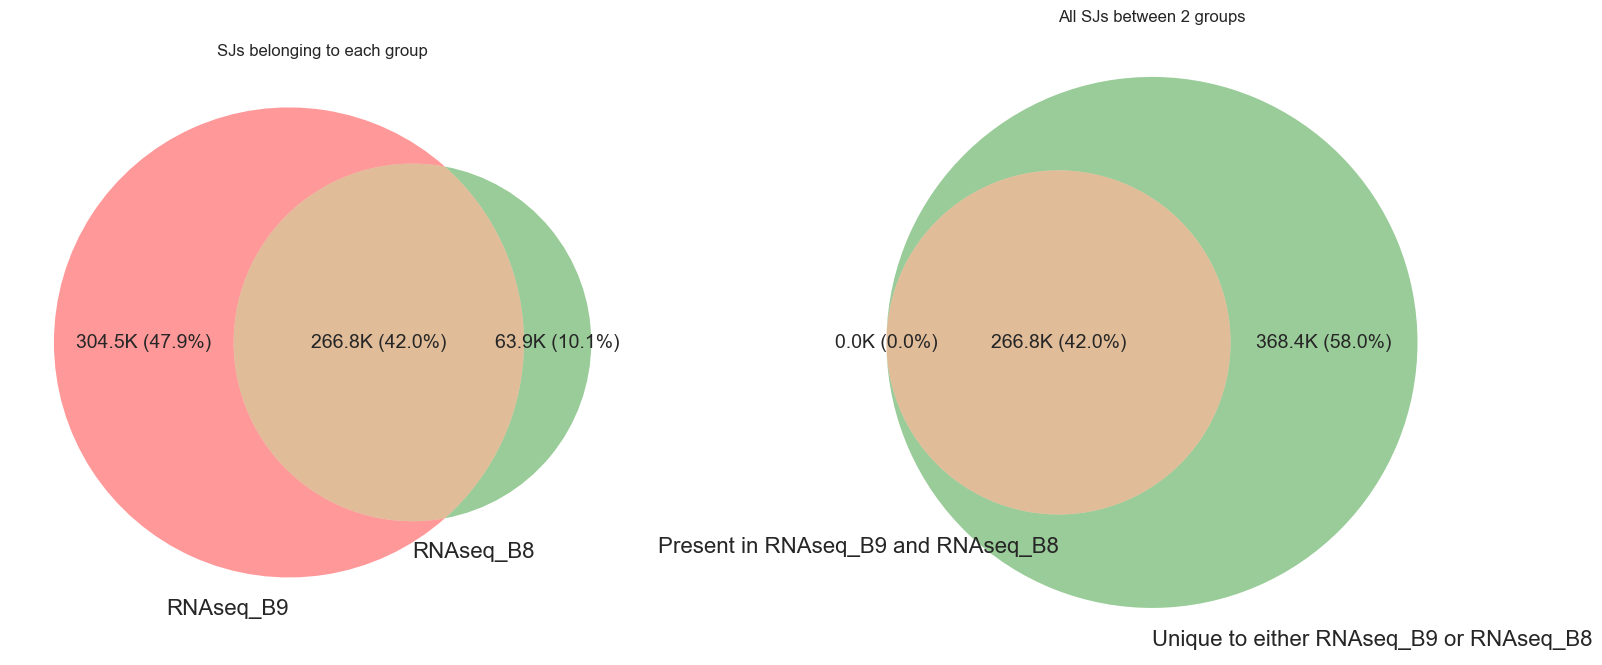

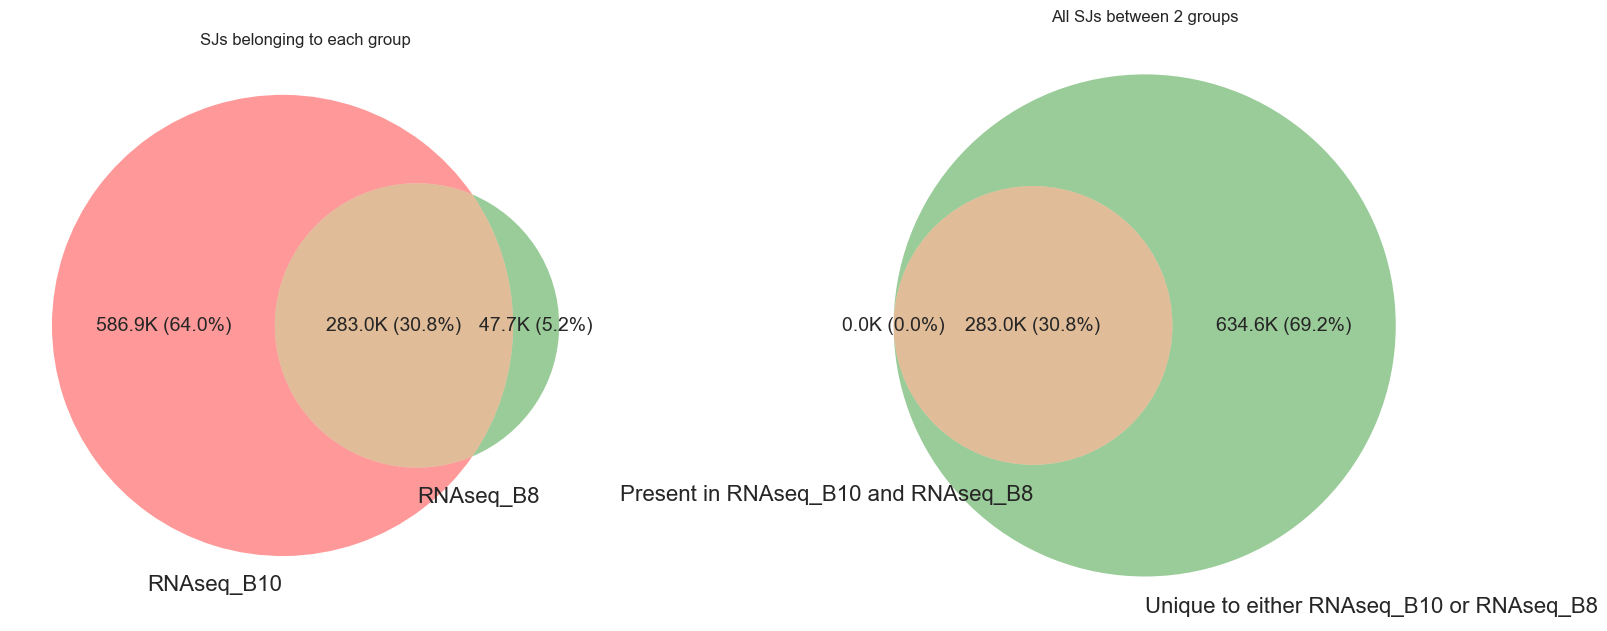

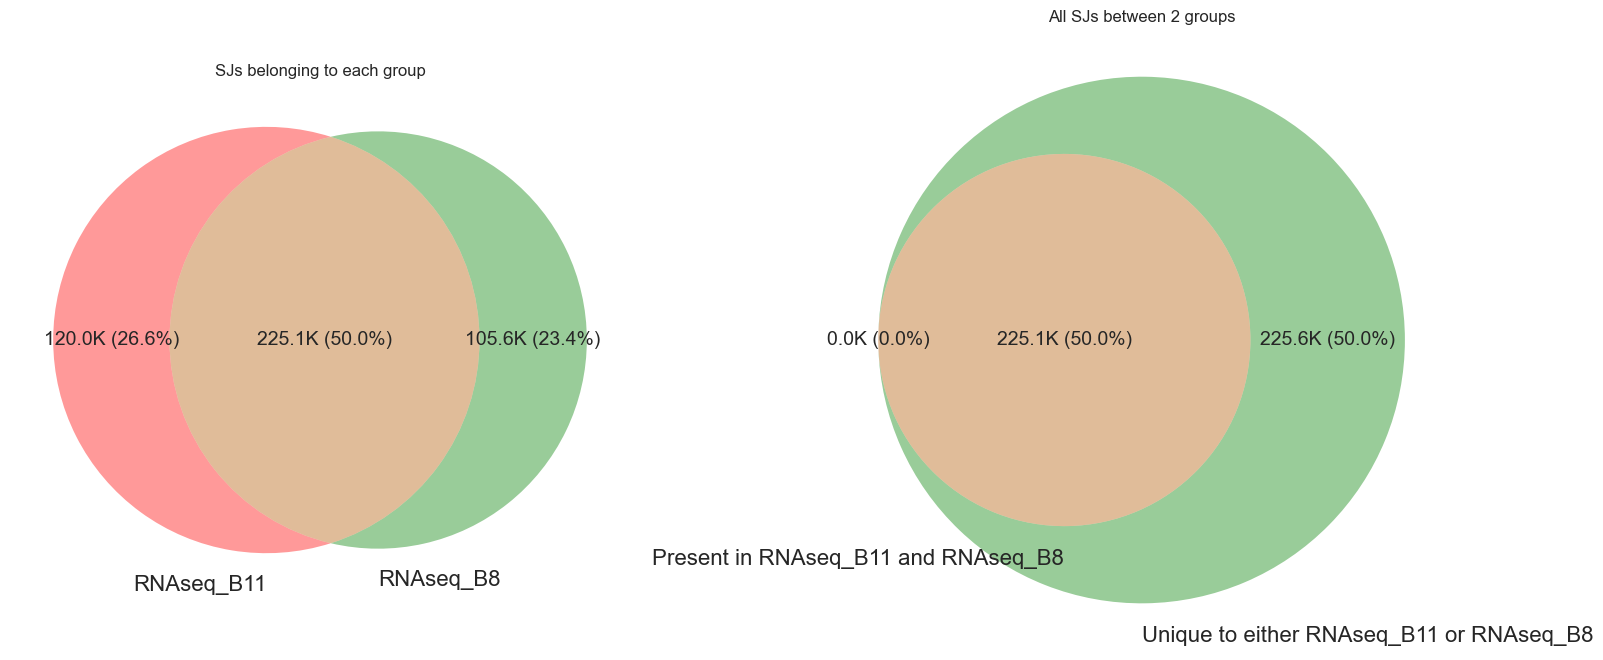

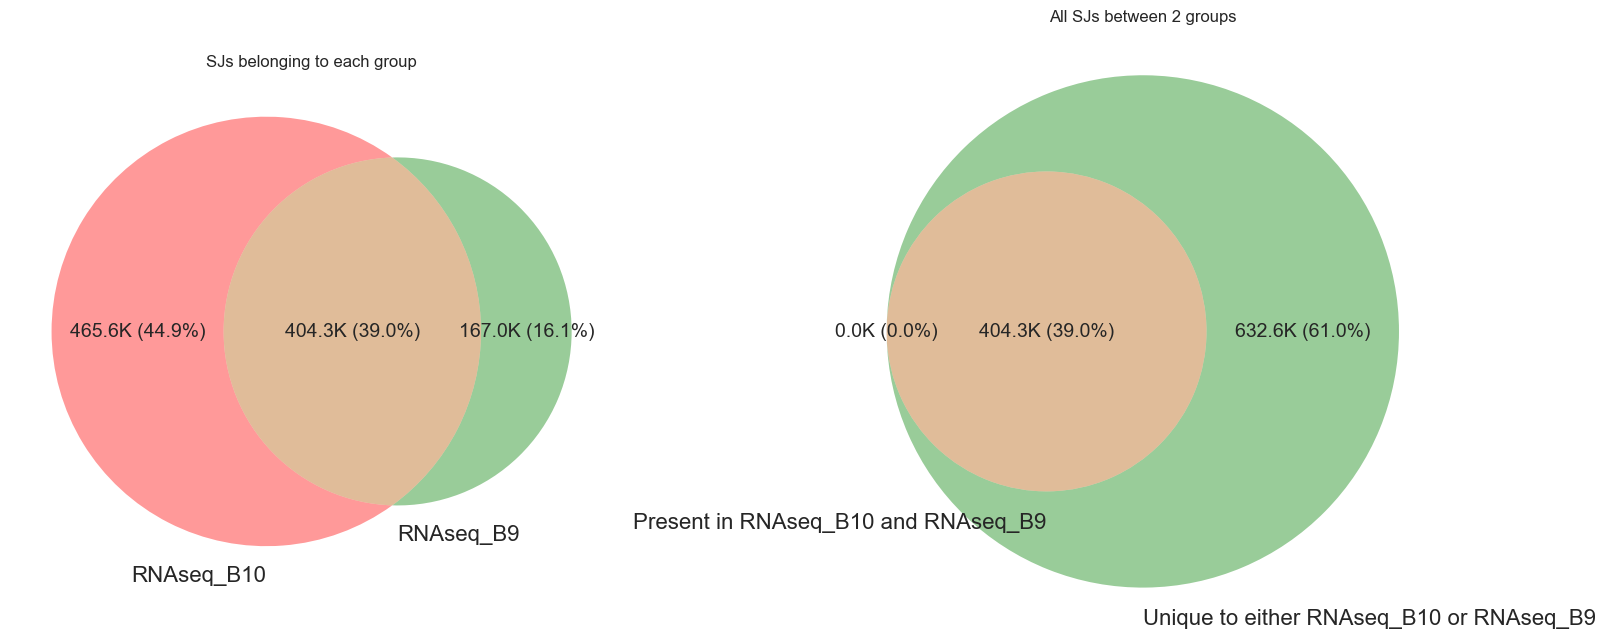

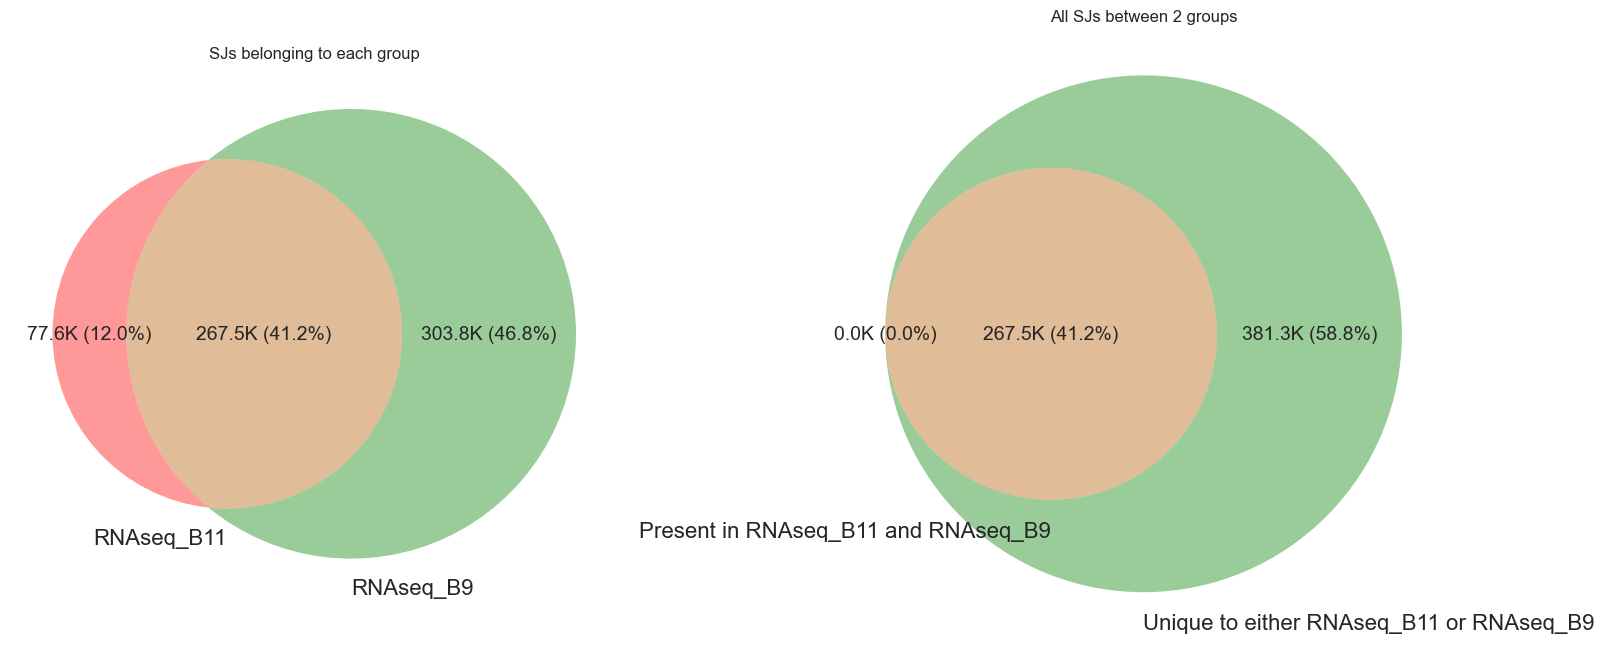

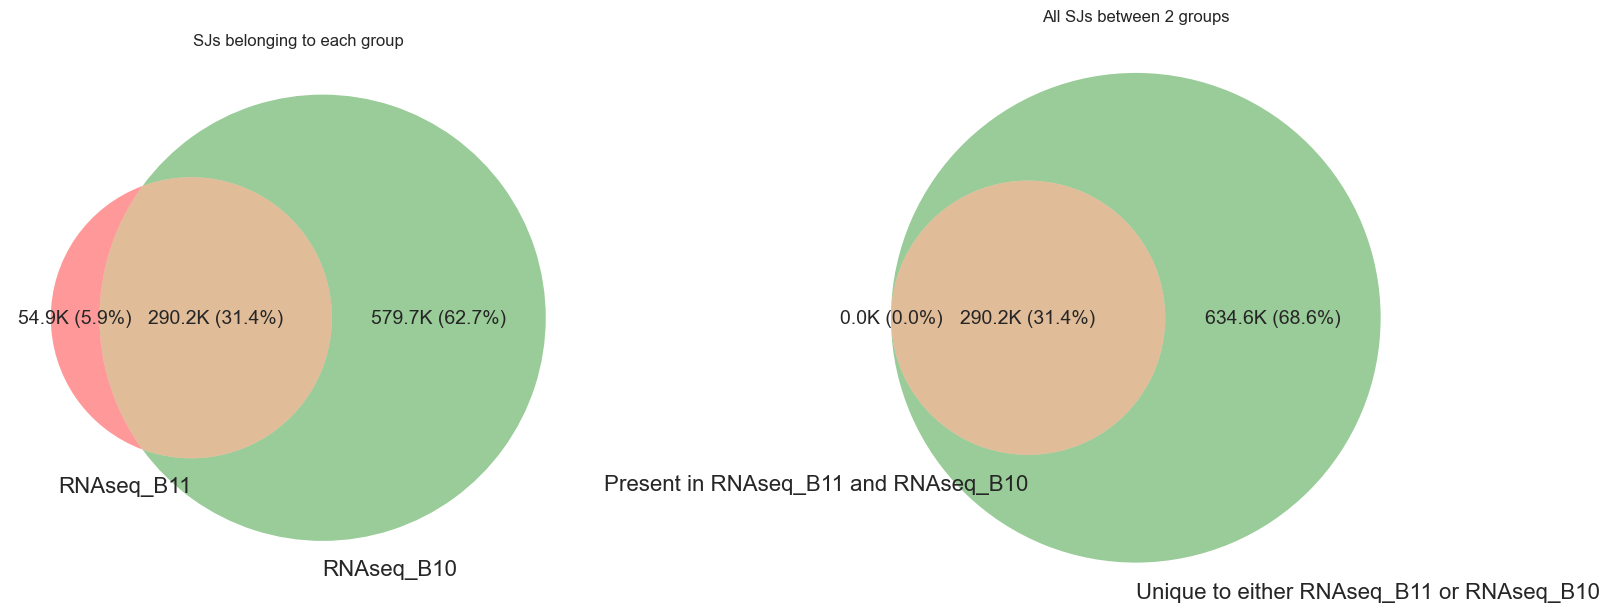

In [673]:
for batch1, batch2 in combinations([f'agg_sjs/human_NPC_RNAseq/RNAseq_B{n}.SJ.all' for n in range(2,12)], r=2):
    df_b1 = pd.read_csv(batch1, sep = '\t', header=None)
    df_b2 = pd.read_csv(batch2, sep = '\t', header=None)
    
    b1_name = batch1.split('.')[0].split('/')[-1]
    b2_name = batch2.split('.')[0].split('/')[-1]
    
    df_vals = plot_venn_comparison(df_L=df_b1, df_R=df_b2, l_name=b1_name, r_name=b2_name)
    

In [499]:
common_both = []


for batch1, batch2 in combinations([f'agg_sjs/human_NPC_RNAseq/RNAseq_B{n}.SJ.all' for n in range(2,12)], r=2):
    df_b1 = pd.read_csv(batch1, sep = '\t', header=None)
    df_b2 = pd.read_csv(batch2, sep = '\t', header=None)
    
    b1_name = batch1.split('.')[0].split('/')[-1]
    b2_name = batch2.split('.')[0].split('/')[-1]
    
    df_vals, df_prop = compare_2_sj_alls(df_L=df_b1, df_R=df_b2, l_name=b1_name, r_name=b2_name)
    
    common_both.append(df_prop.loc['both']['uniquely belonging to group'])
    

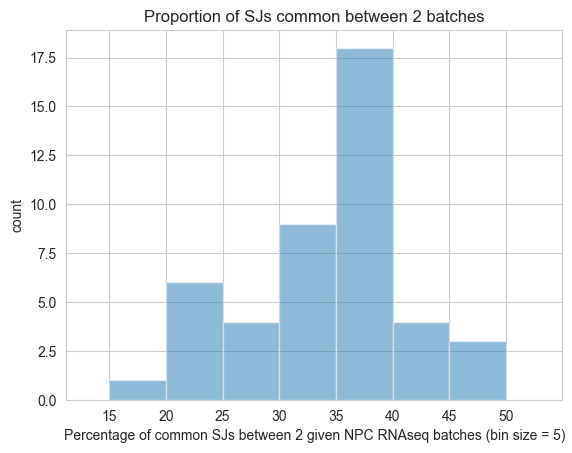

In [505]:
bins = np.arange(0, 103, 5) # fixed bin size

plt.xlim([min(common_both)-5, max(common_both)+5])

plt.hist(common_both, bins=bins, alpha=0.5)
plt.title('Proportion of SJs common between 2 batches')
plt.xlabel('Percentage of common SJs between 2 given NPC RNAseq batches (bin size = 5)')
plt.ylabel('count')

plt.show()

### Comparison between NPC cell line SJs and NPC human RNAseq SJs

When comparing NPC patient RNAseq with NPC cell lines:
1. There is the largest raw number of unique SJs from each list. 
2. As this list comprises of all the unique SJs from all samples in the category, we can see this as representative of the entire set.
3. Given this, we see that out of the 3.9m unique reads between the 2 sets, only 843k are common between them, totaling to approximately 21.3%

In [ ]:
cell_line_npc = npc
rnaseq_npc = pd.read_csv('agg_sjs/human_NPC_RNAseq/full_human_RNAseq.SJ.all', sep = '\t', header=None)

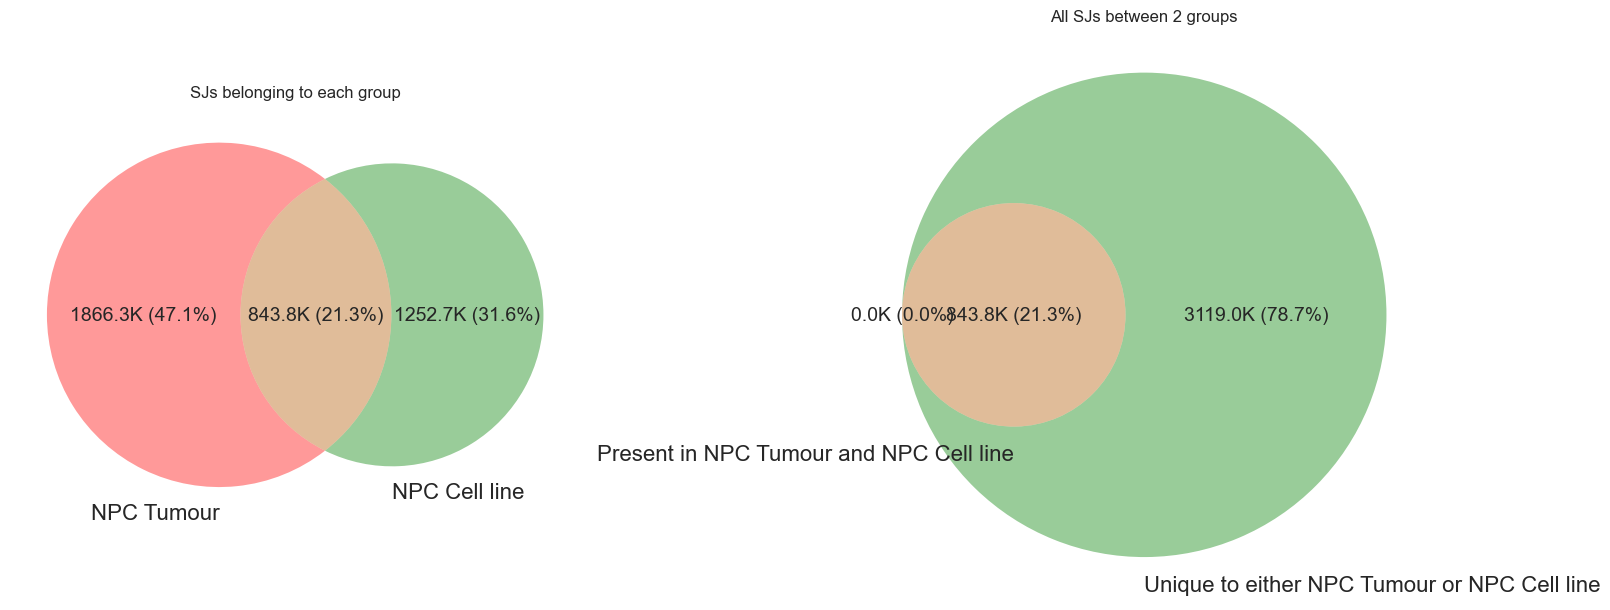

uniquely belonging to group   shared
both                                843801  3119023
NPC Tumour                         1866324   843801
NPC Cell line                      1252699   843801

In [674]:
plot_venn_comparison(df_L=cell_line_npc, df_R=rnaseq_npc, l_name='NPC Cell line', r_name='NPC Tumour')

#### Final conclusions

1. Within cell lines, comparisons show common Sjs between 35-40%. X2 and Du are particularly low.
2. Between tissue types in cell lines: approx 37% are shared which is in line with 'normal'
3. Modal common SJ proportions between patient RNAseq batches are around 35-40%.
4. Ultimate comparison between NPC cell lines and NPC RNAseq data show low commonality: 21.3%

Recommendations:
* Either create a filtered SJ out file for each of: cell lines, RNAseq per tissue type. Or use STAR --twopassmode Basic

### Comparing cell line and tumour tissue in Head and Neck samples to generate a benchmark of SJ commonality.

___
1. Distribution of number of samples an SJ is found in 

In [521]:
HN_cellline = pd.read_csv(f'agg_sjs/HN/HN_cellline.SJ.all', sep = '\t', header=None)
HN_tumour = pd.read_csv(f'agg_sjs/HN/HN_tumours.SJ.all', sep = '\t', header=None)
HN_cellline.columns = colnames
HN_tumour.columns = colnames
HN_cellline.drop_duplicates(colnames[:3], inplace = True)
HN_tumour.drop_duplicates(colnames[:3], inplace = True)


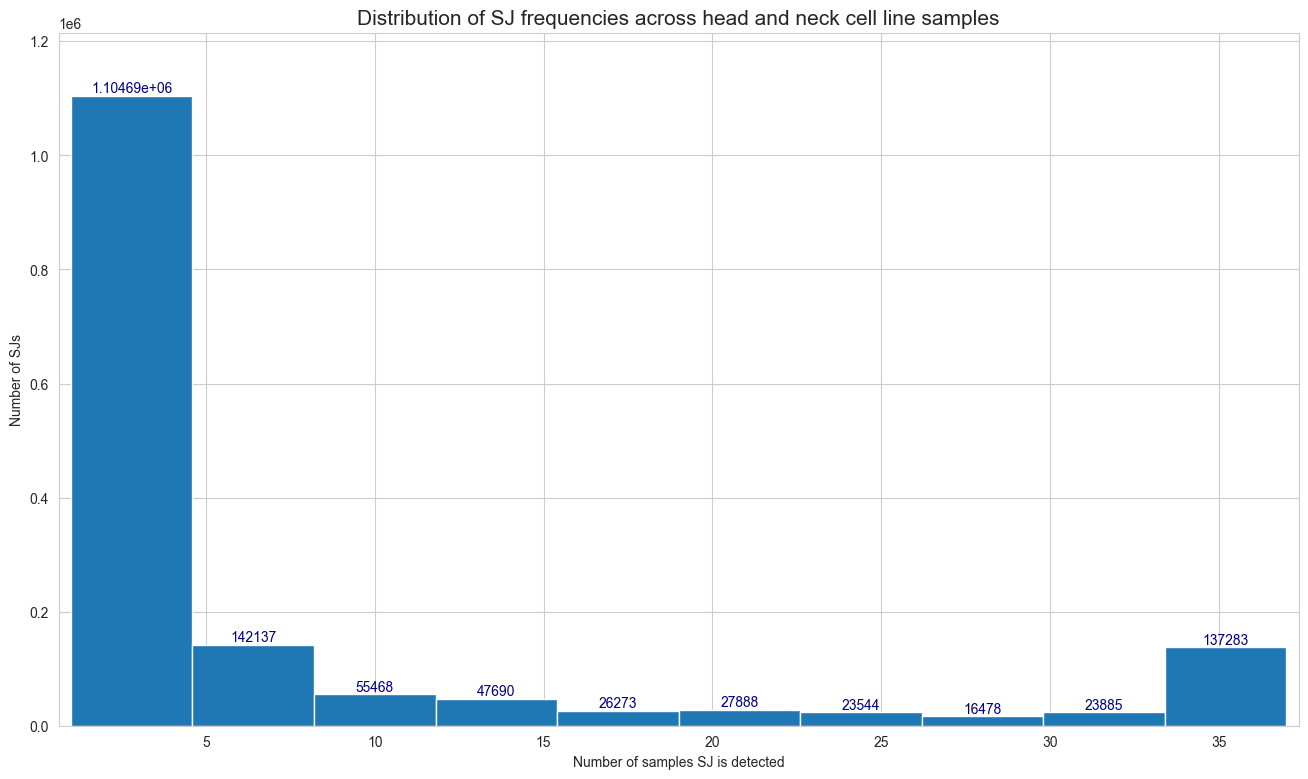

In [541]:
plot_Sj_dist_hist(HN_cellline, bins = 10, title = 'Distribution of SJ frequencies across head and neck cell line samples')

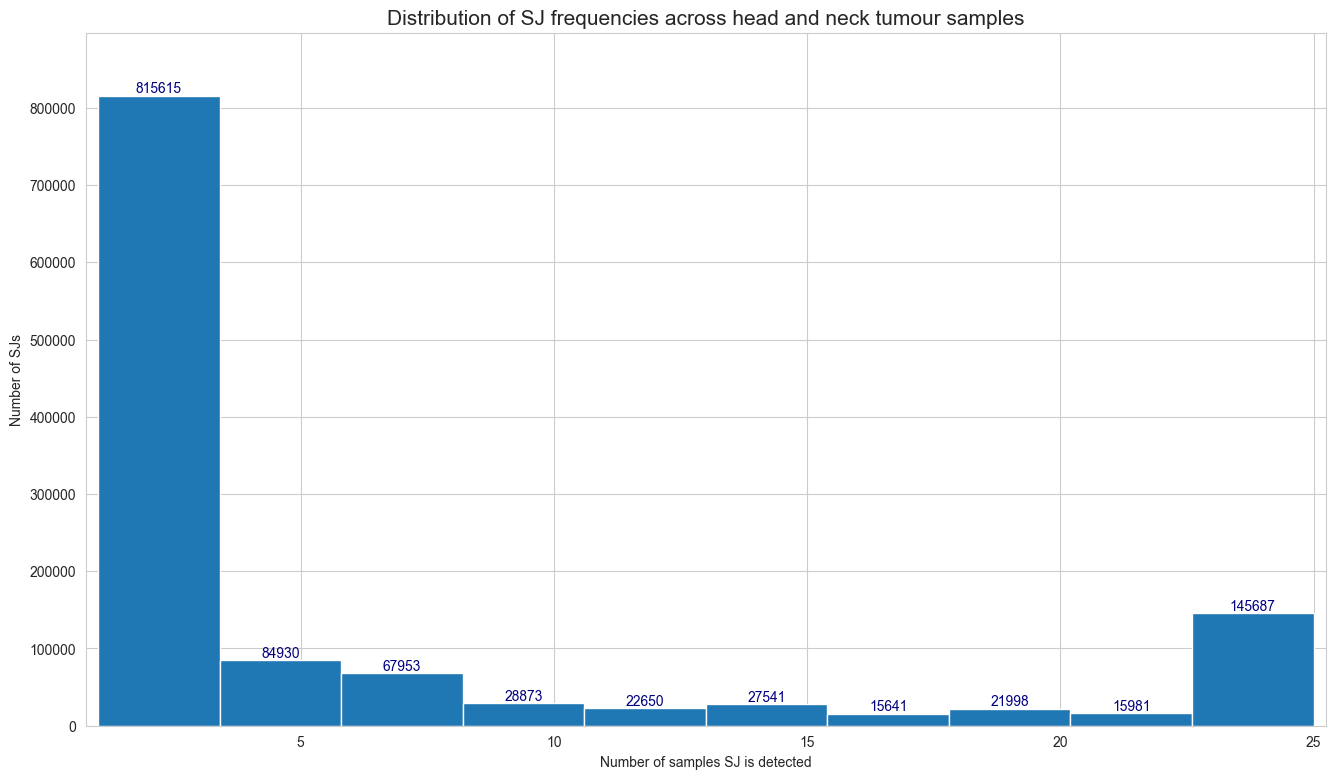

In [542]:
plot_Sj_dist_hist(HN_tumour, bins = 10, title = 'Distribution of SJ frequencies across head and neck tumour samples')

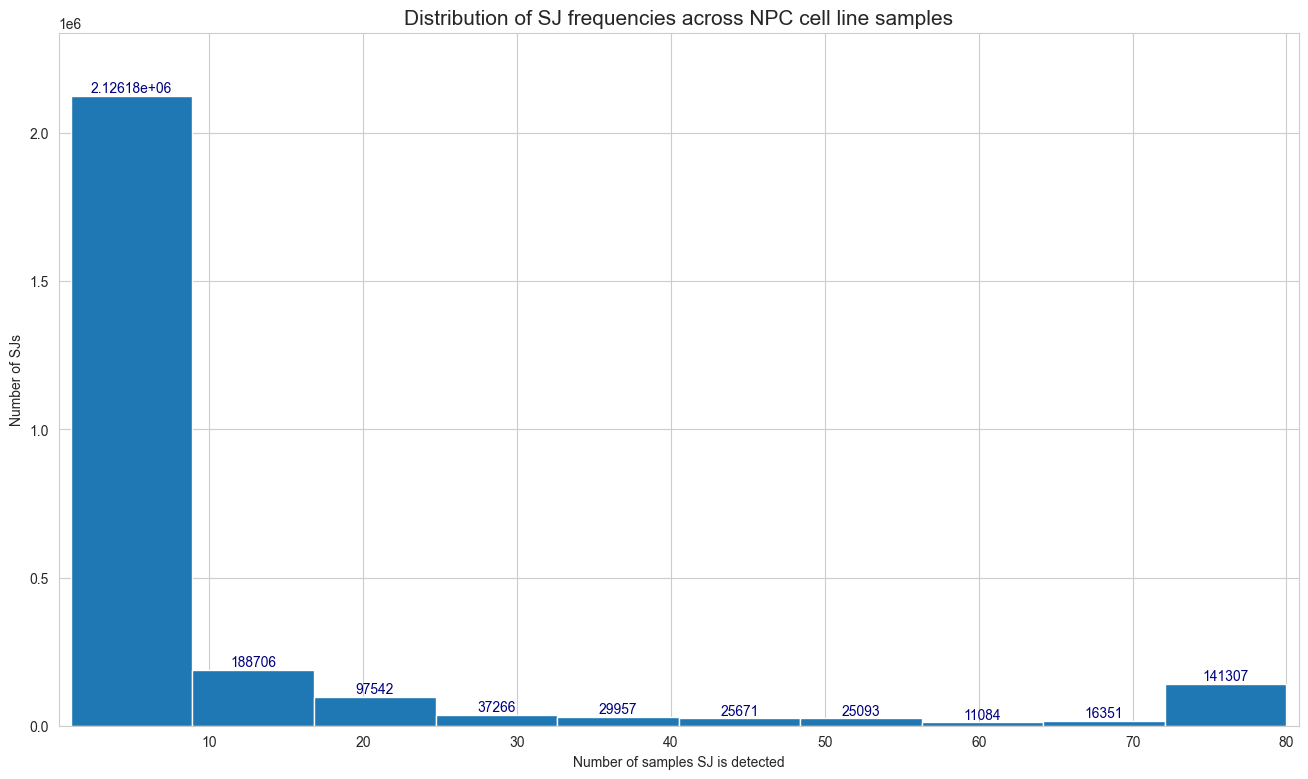

In [543]:
plot_Sj_dist_hist(cell_line_npc, bins = 10, title = 'Distribution of SJ frequencies across NPC cell line samples')

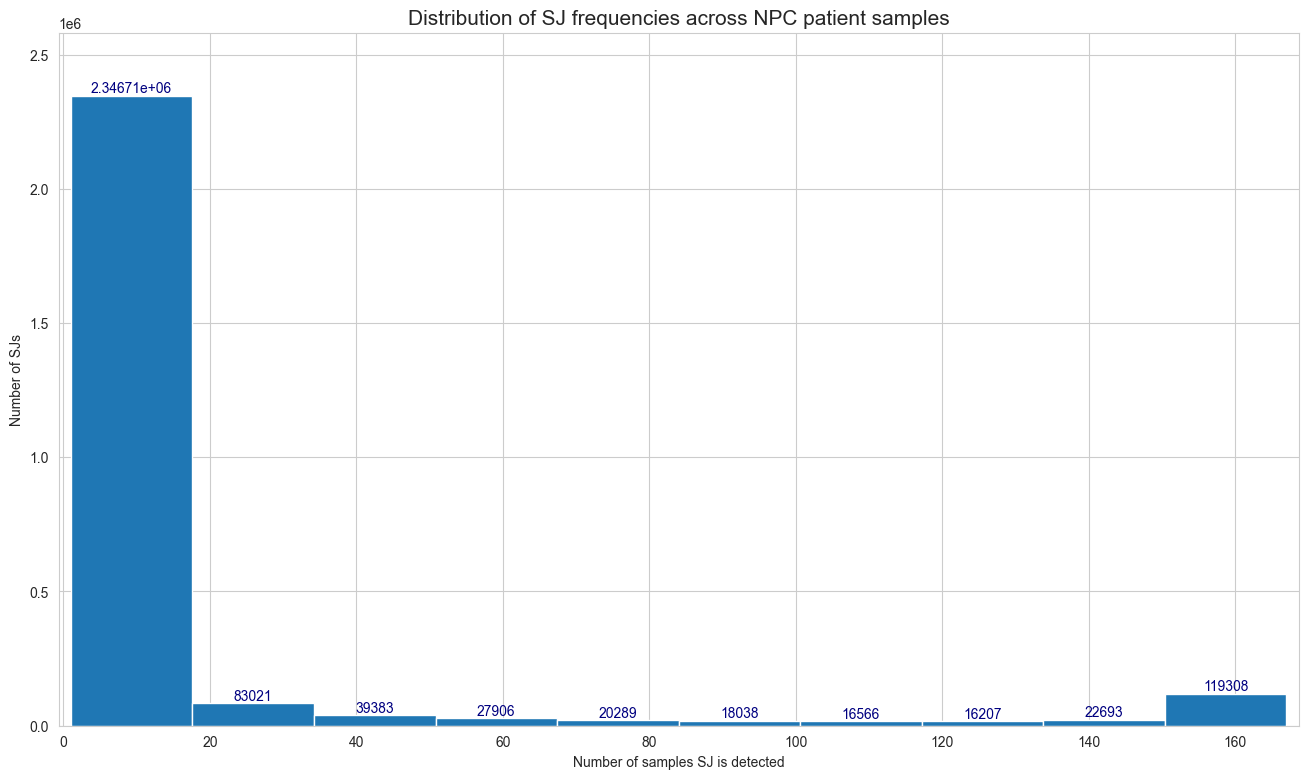

In [544]:
plot_Sj_dist_hist(rnaseq_npc, bins = 10, title = 'Distribution of SJ frequencies across NPC patient samples')

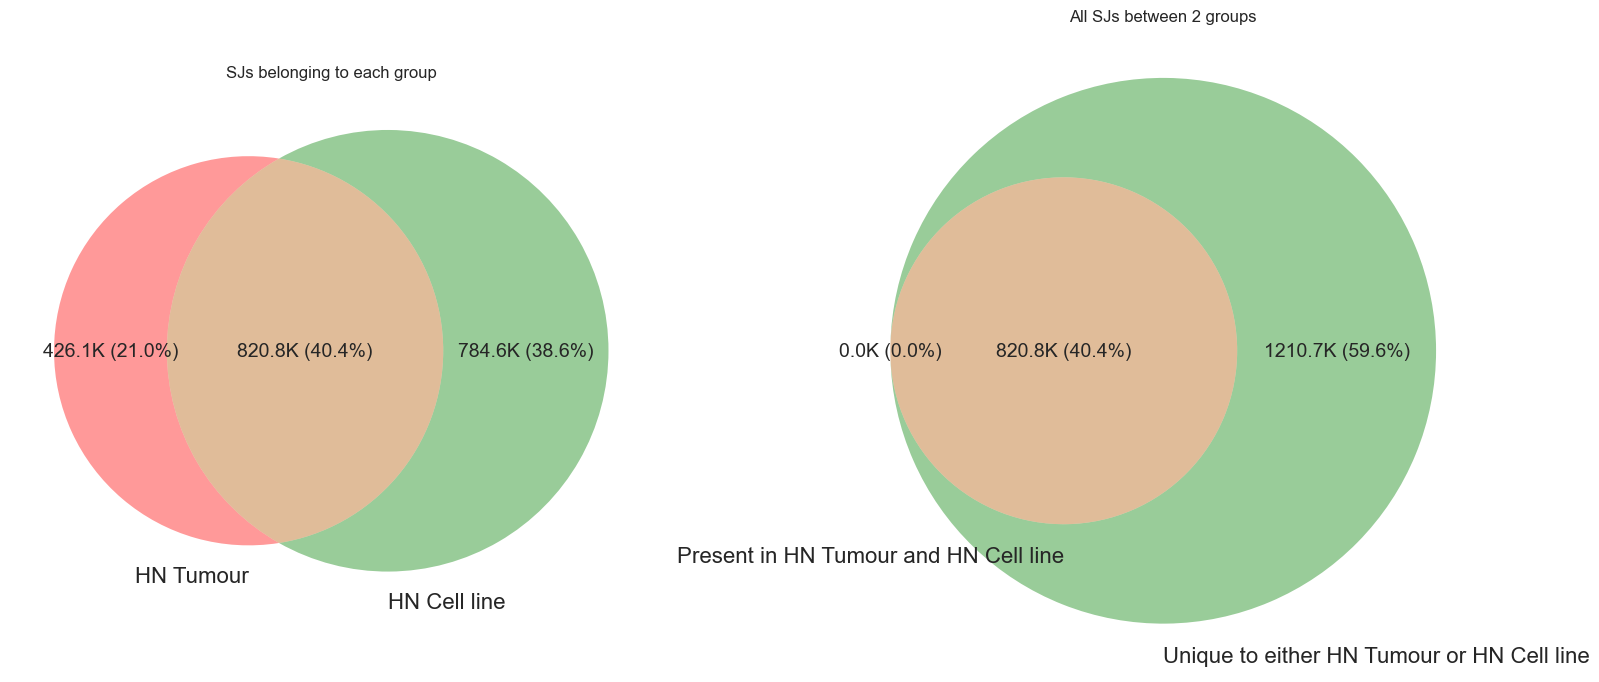

uniquely belonging to group   shared
both                               820770  1210664
HN Tumour                          426099   820770
HN Cell line                       784565   820770

In [675]:
plot_venn_comparison(df_L=HN_cellline, df_R=HN_tumour, l_name='HN Cell line', r_name='HN Tumour')

*Exploring patients with paired tissue and cell line samples*
1. batch1/HN279
2. batch3/HN148
3. batch7/HN338

In [678]:
HN279_Pri_CL = pd.read_csv('HN/batch1/HN279_Pri.star.SJ.out.tab', sep = '\t', header=None)
HN279_Pri_Tissue = pd.read_csv('HN/batch1/HN279_Pri_Tissue.star.SJ.out.tab', sep = '\t', header=None)
HN279_Met_CL = pd.read_csv('HN/batch1/HN279_Met.star.SJ.out.tab', sep = '\t', header=None)
HN279_Met_Tissue = pd.read_csv('HN/batch1/HN279_Met_Tissue.star.SJ.out.tab', sep = '\t', header=None)

In [681]:
colnames_short = colnames[:-1]

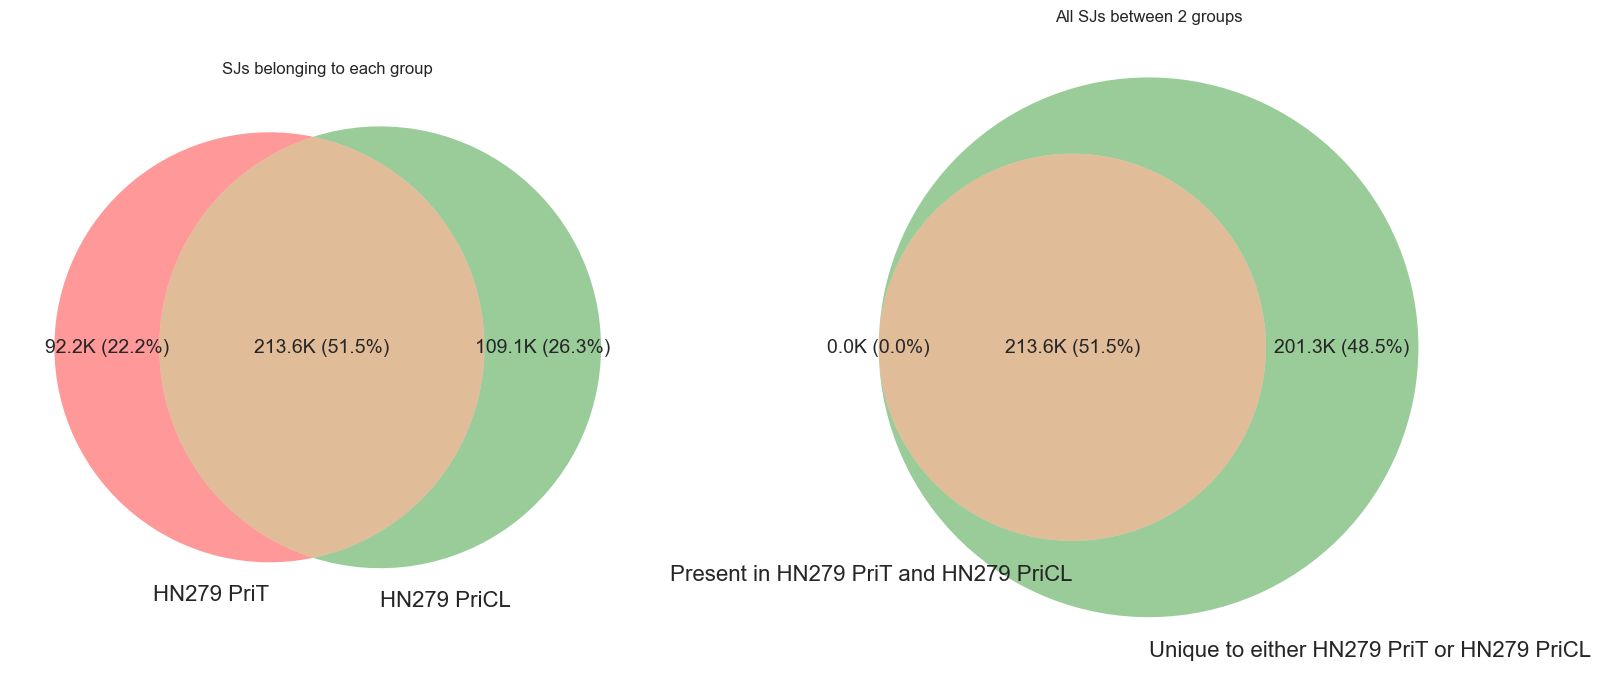

uniquely belonging to group  shared
both                              213606  201304
HN279 PriT                         92169  213606
HN279 PriCL                       109135  213606

In [690]:
plot_venn_comparison(df_L=HN279_Pri_CL, 
                     df_R=HN279_Pri_Tissue, 
                     l_name='HN279 PriCL', 
                     r_name='HN279 PriT',
                    colnames = colnames_short)

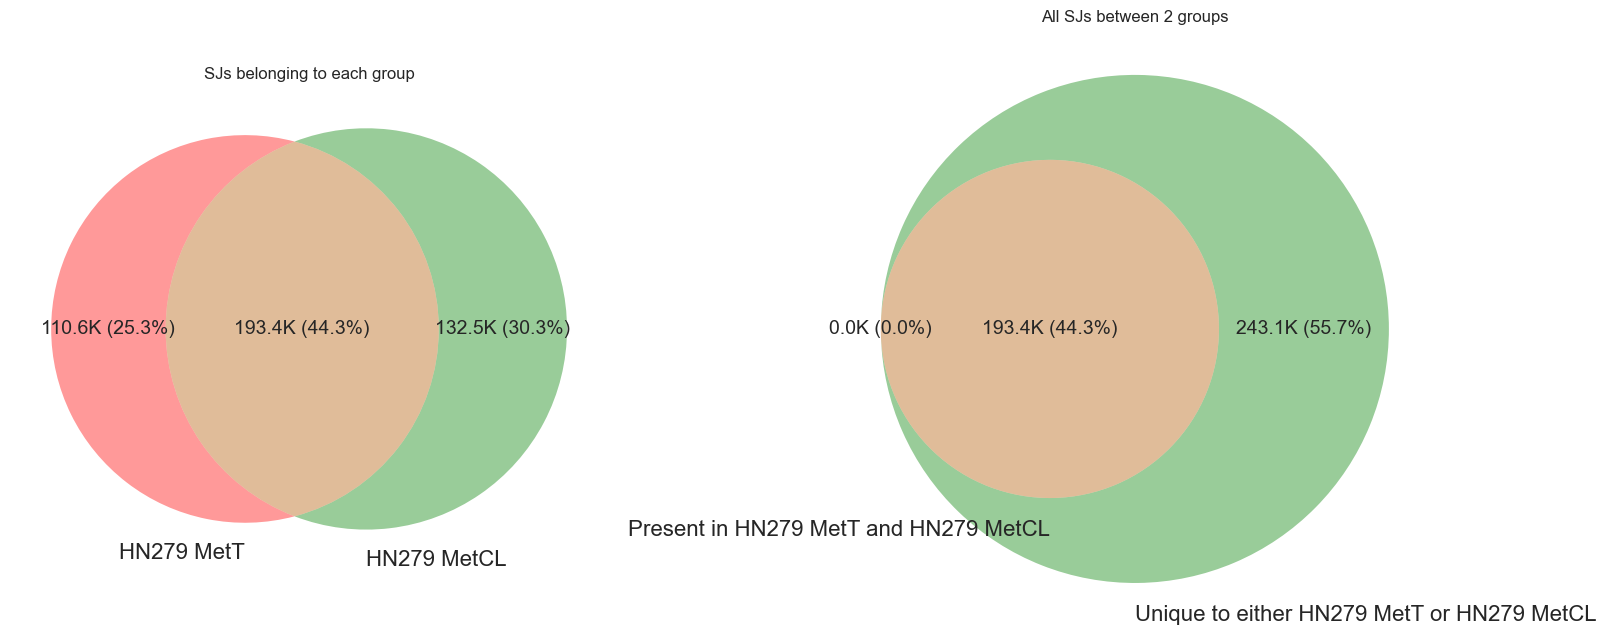

uniquely belonging to group  shared
both                              193435  243126
HN279 MetT                        110646  193435
HN279 MetCL                       132480  193435

In [689]:
plot_venn_comparison(df_L=HN279_Met_CL,
                     df_R=HN279_Met_Tissue,
                     l_name='HN279 MetCL',
                     r_name='HN279 MetT',
                    colnames = colnames_short)

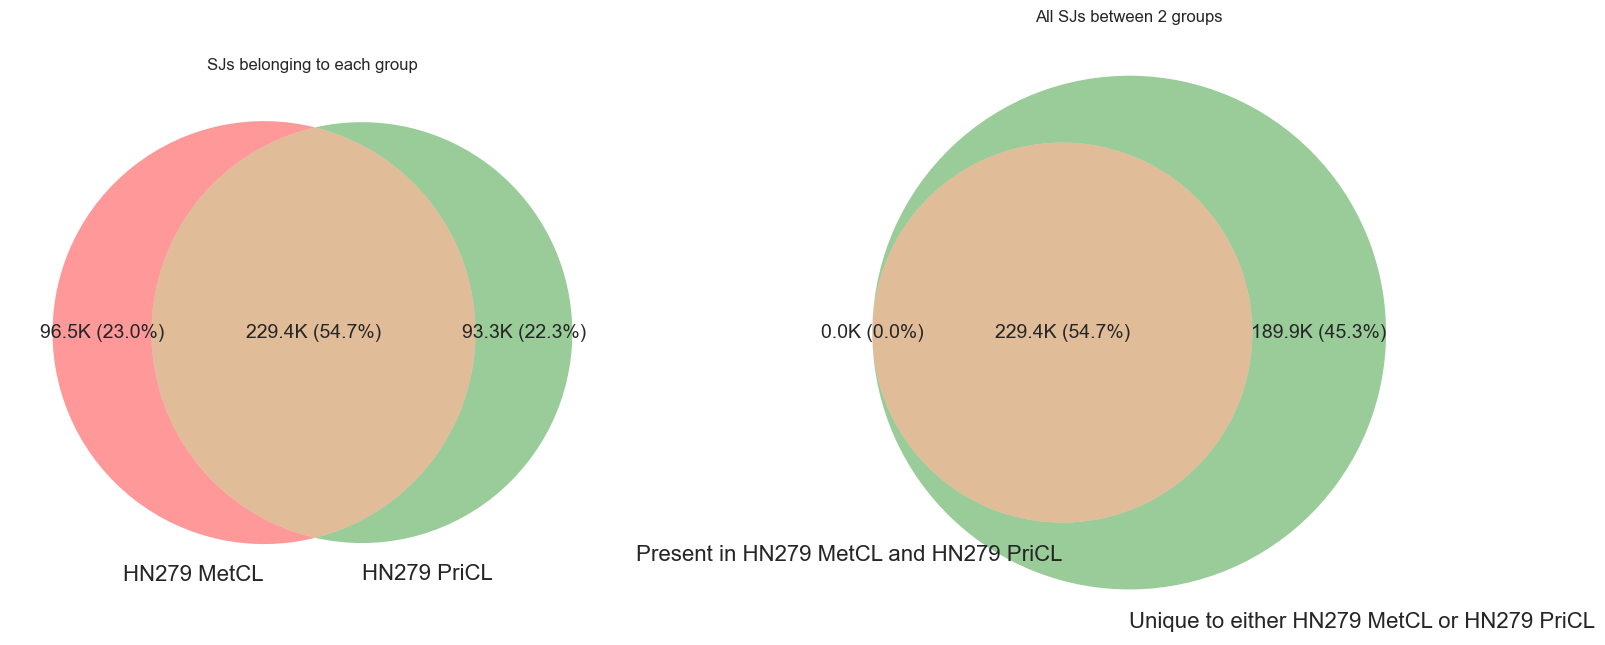

uniquely belonging to group  shared
both                              229396  189864
HN279 MetCL                        96519  229396
HN279 PriCL                        93345  229396

In [713]:
plot_venn_comparison(df_L=HN279_Pri_CL, 
                     df_R=HN279_Met_CL, 
                     l_name='HN279 PriCL', 
                     r_name='HN279 MetCL',
                    colnames = colnames_short)

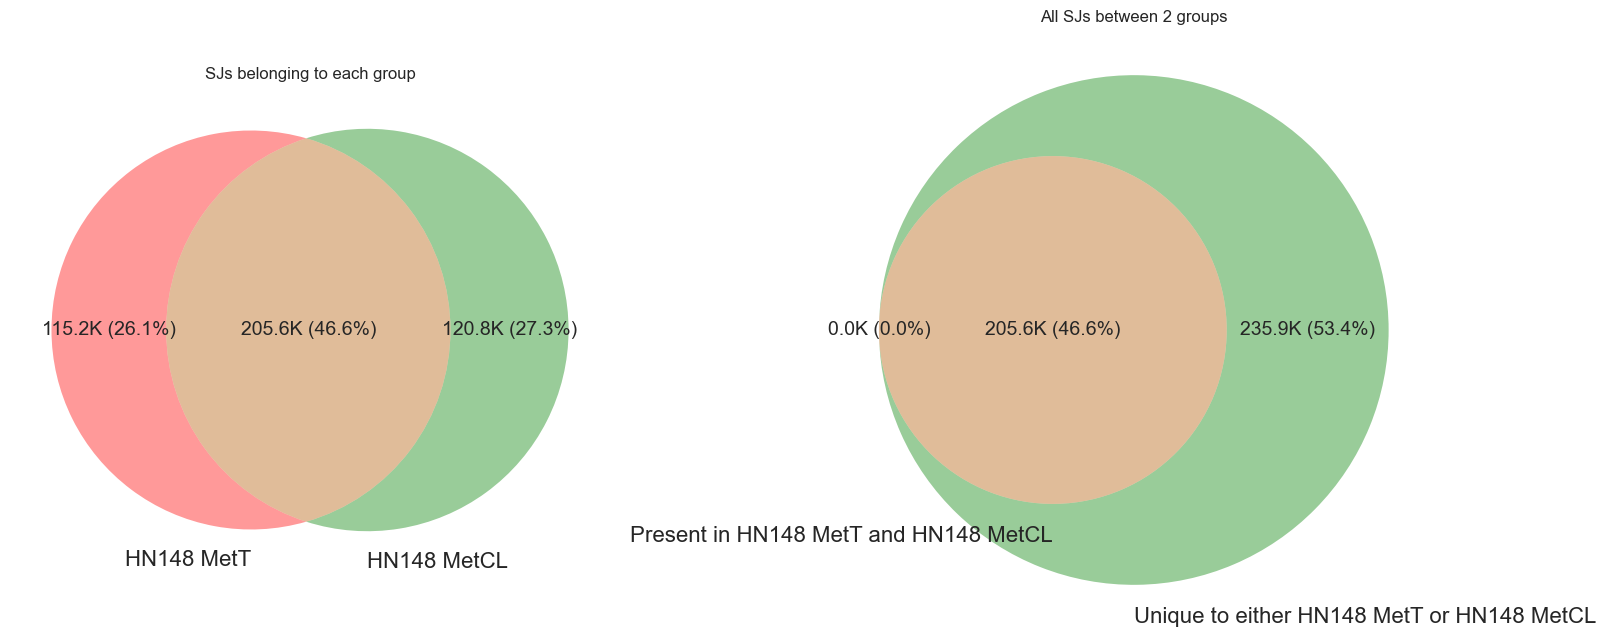

uniquely belonging to group  shared
both                              205641  235946
HN148 MetT                        115193  205641
HN148 MetCL                       120753  205641

In [691]:
HN148_Met_CL = pd.read_csv('HN/batch3/HN148Met.star.SJ.out.tab', sep = '\t', header=None)
HN148_Met_Tissue = pd.read_csv('HN/batch3/HN148MetT.star.SJ.out.tab', sep = '\t', header=None)
plot_venn_comparison(df_L=HN148_Met_CL, 
                     df_R=HN148_Met_Tissue, 
                     l_name='HN148 MetCL', 
                     r_name='HN148 MetT',
                    colnames = colnames_short)

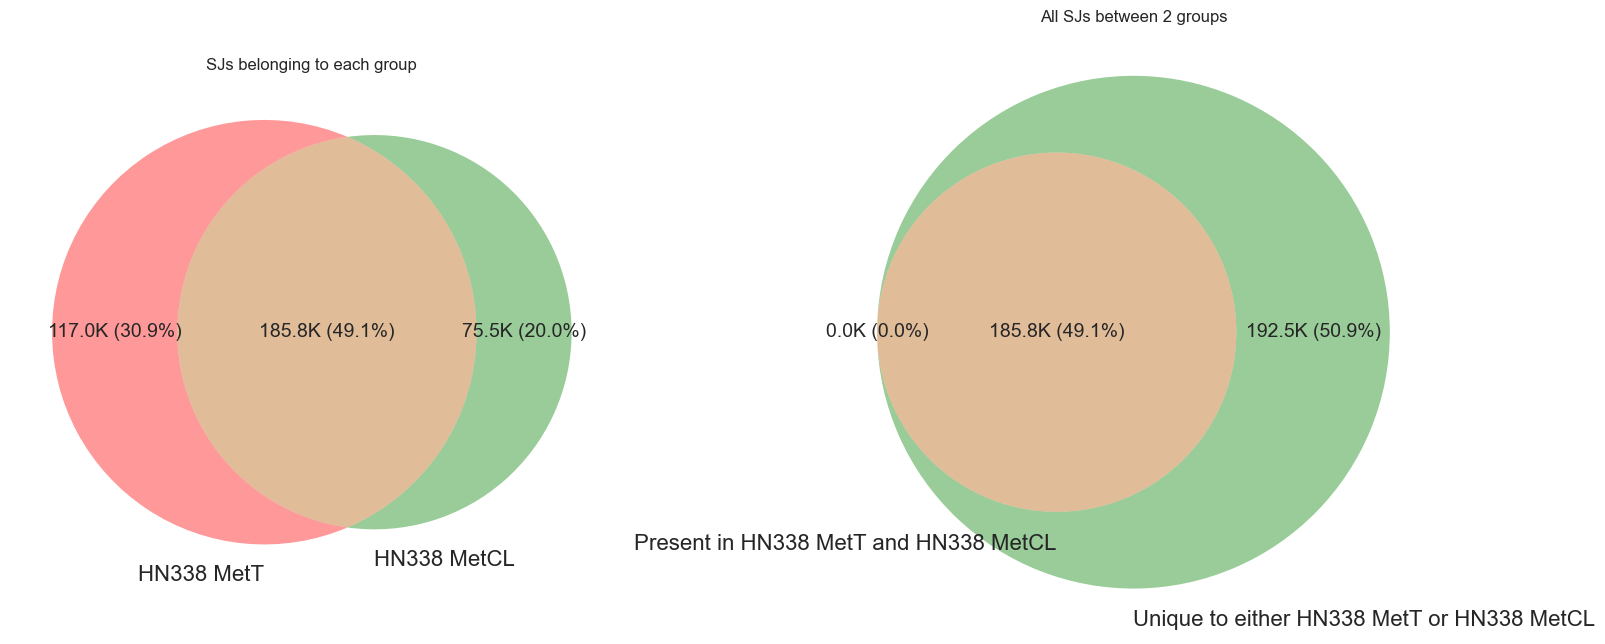

uniquely belonging to group  shared
both                              185794  192525
HN338 MetT                        117045  185794
HN338 MetCL                        75480  185794

In [692]:
HN338_Met_CL = pd.read_csv('HN/batch7/HN338Met_cellline.star1.SJ.out.tab', sep = '\t', header=None)
HN338_Met_Tissue = pd.read_csv('HN/batch7/HN338Met_tumour.star1.SJ.out.tab', sep = '\t', header=None)
plot_venn_comparison(df_L=HN338_Met_CL, 
                     df_R=HN338_Met_Tissue, 
                     l_name='HN338 MetCL', 
                     r_name='HN338 MetT',
                    colnames = colnames_short)

In [693]:
(49.1+46.6+44.3+51.5)/4

47.875

#### Conclusions for Head and Neck comparisons

* Over all HN cell line and HN tumour tissue samples, SJ commonality is 40.4%
* Over 4 patient-paired cell line and tumour tissue samples, mean SJ commonality is 47.9%

This is notably higher than the SJ commonality of 21.3% seen in the NPC comparison. Something else to note is there is a higher raw number of SJs in across NPC samples than there are in HN samples.

___
### Plotting histograms of splice junction recurrence in samples

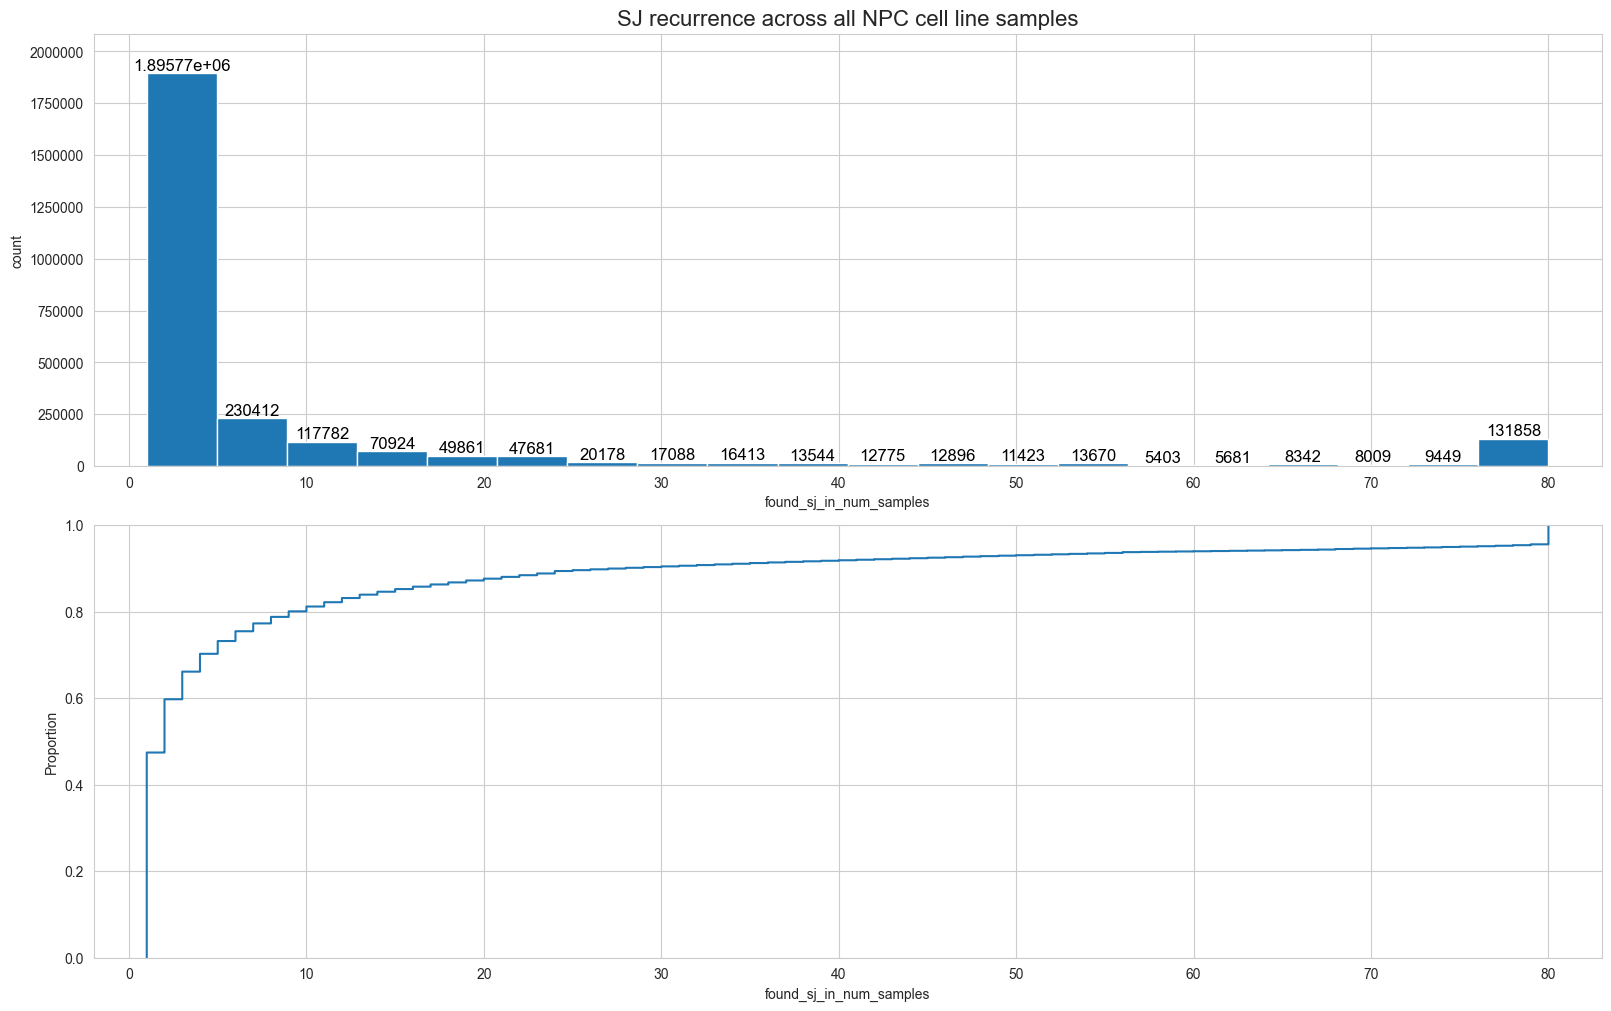

In [787]:
plot_recurrence_patterns(cell_line_npc, n_bins=20, title='NPC cell line')

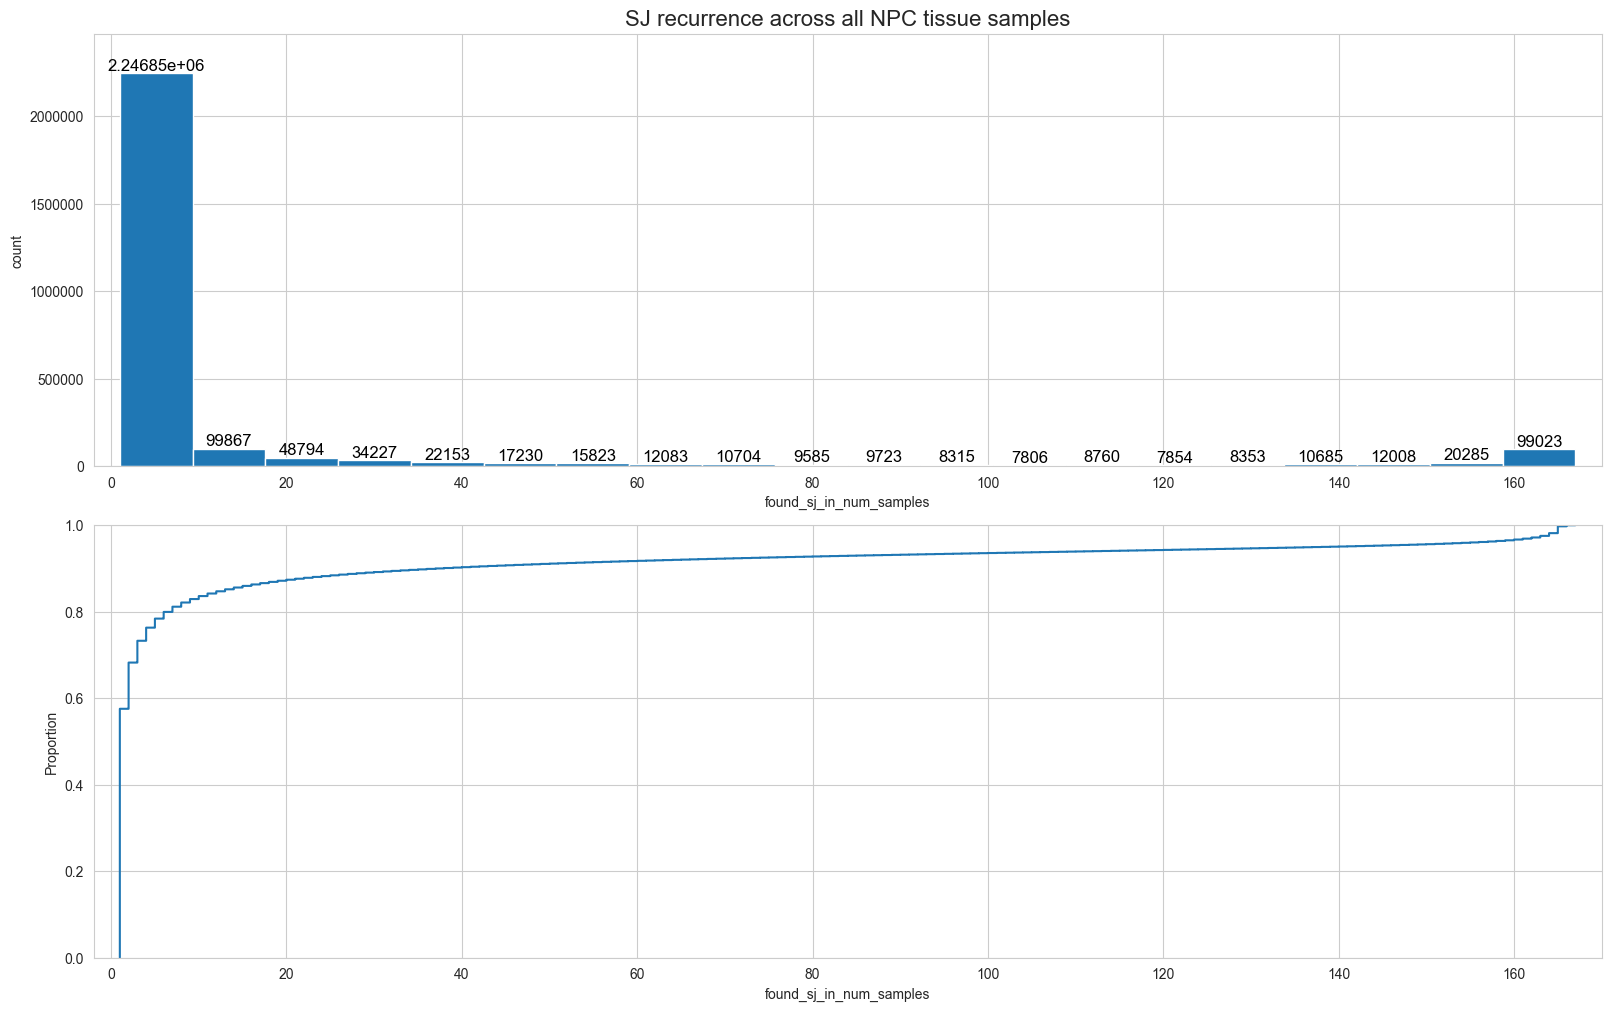

In [788]:
plot_recurrence_patterns(rnaseq_npc, n_bins = 20, title='NPC tissue')

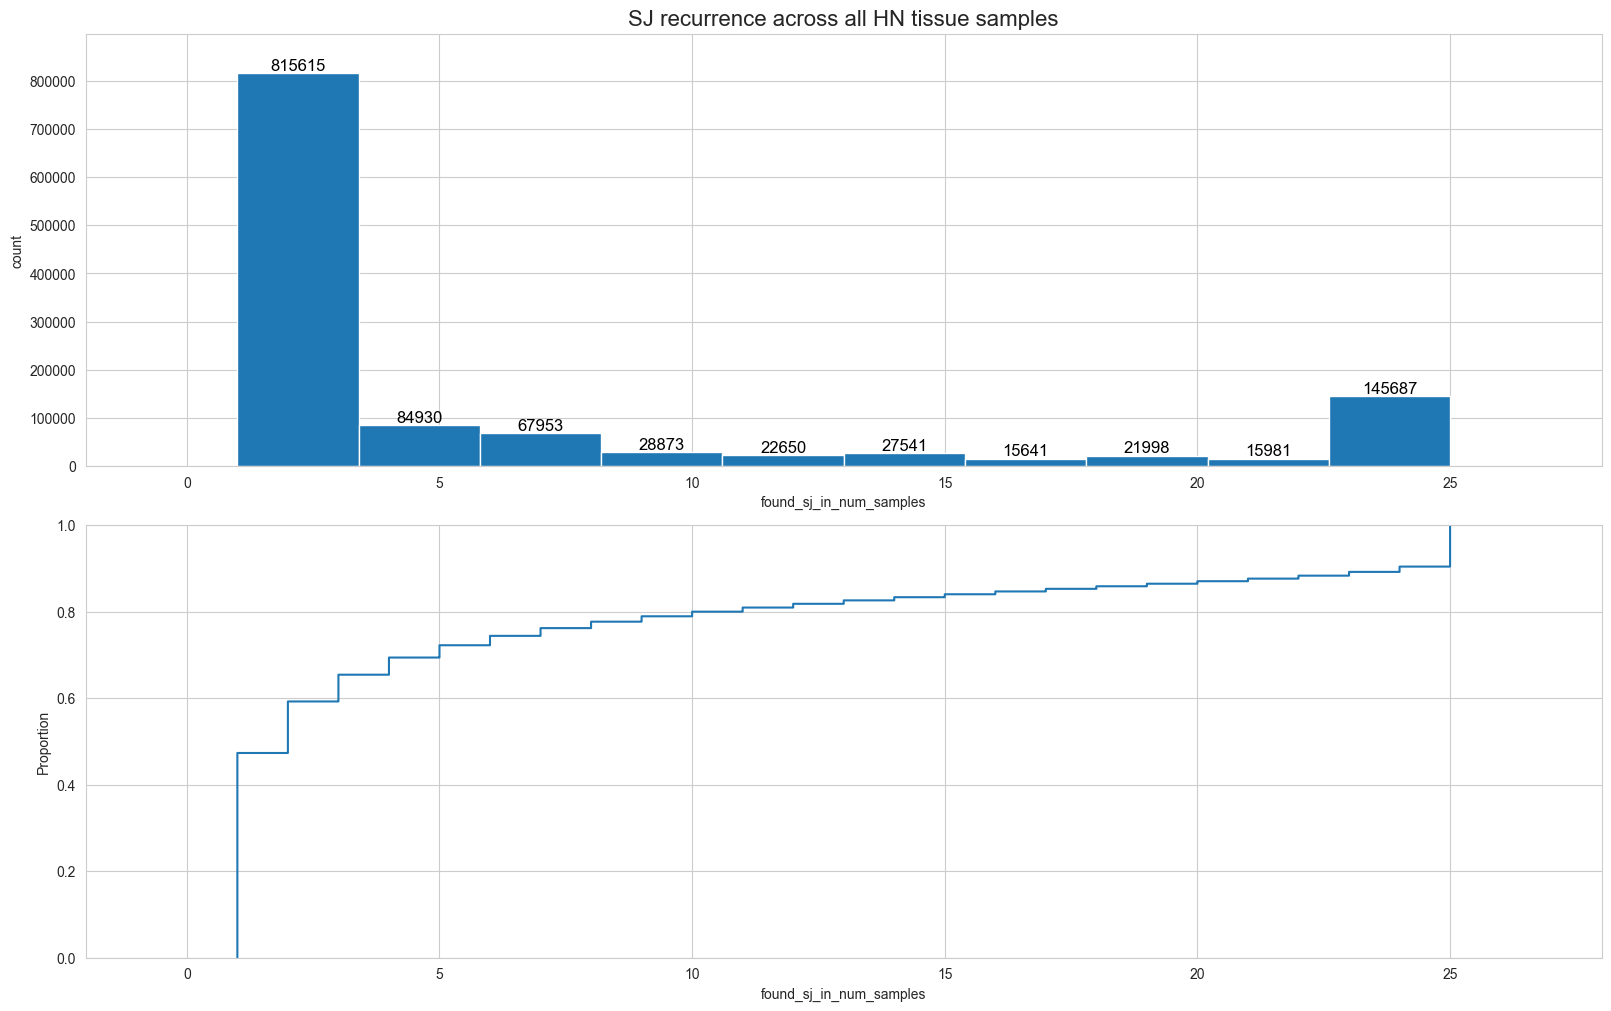

In [790]:
plot_recurrence_patterns(HN_tumour, n_bins = 10, title='HN tissue')

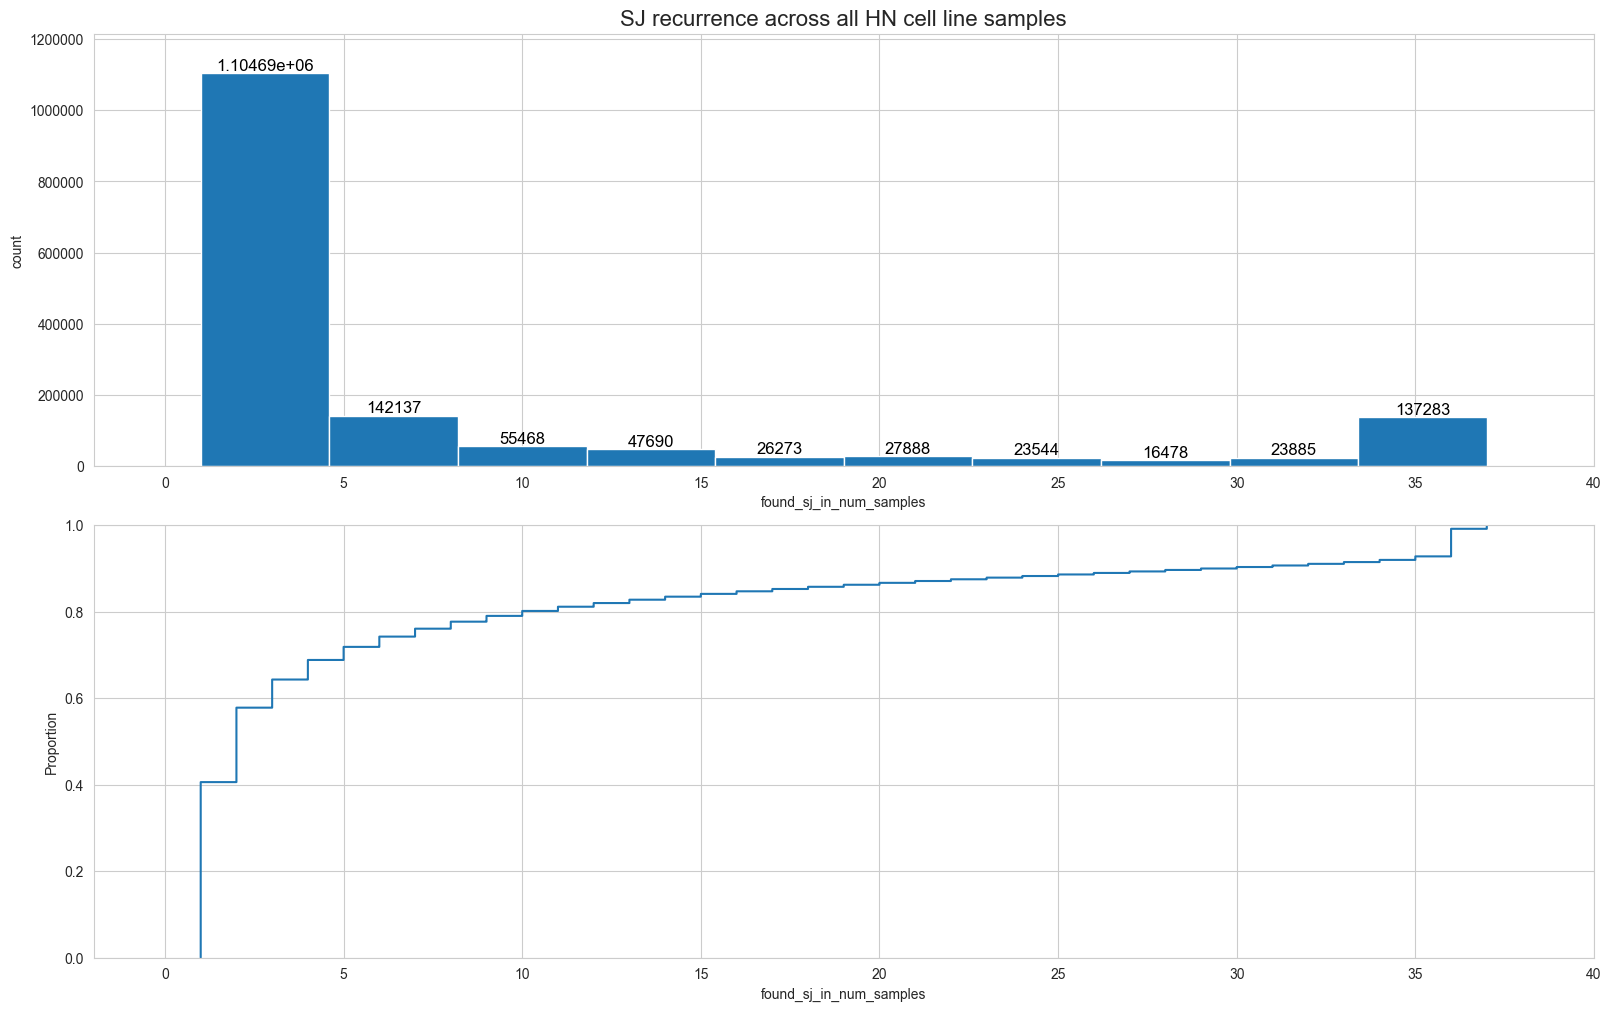

In [791]:
plot_recurrence_patterns(HN_cellline, n_bins = 10, title = 'HN cell line')

___
### 2. Number of unique_mapped and multimapped reads 
1. Initially thought of 2 separate cutoff values for cutting off low unique mapped and high multimapped reads
2. Found that in highly supported SJs, i.e. highly relevant reads with high unique mapped are accompanied with top percentile multimapped reads too.
3. Upon investigation with UCSC genome browser, found some of these regions belong to immune related functions and biologically relevant genes. 
4. In response to this; summed unique and multimapped reads to get total reads mapped to a given SJ as an indicator of confidence. 
5. Set an arbitrary cutoff of >5 total reads for a 'reliable' SJ: this removes approximately 50% of SJs as a large proportion of SJs are supported by <3 reads. This threshold can be considered as stringent.

In [823]:
cell_line_npc['total_mapped']  = cell_line_npc['unique_mapped'] + cell_line_npc['multimapped']

In [888]:
cell_line_npc[cell_line_npc['total_mapped']>=5].shape[0]

1231385

In [865]:
top20_um = cell_line_npc.unique_mapped.value_counts().sort_values(key = lambda x: x.keys(), ascending = False)[:20].keys()

In [866]:
cell_line_npc[cell_line_npc['unique_mapped'].isin(top20_um)]

contig  first_base  last_base  strand  intron_motif  annotated  \
872890    chr6    73517935   73518029       2             2          1   
873020    chr6    73518265   73518353       2             2          1   
873153    chr6    73518611   73518697       2             2          1   
873205    chr6    73518849   73518931       2             2          1   
873292    chr6    73519229   73519336       2             2          1   
873350    chr6    73519517   73519882       2             2          1   
1467772  chr11    61964892   61964986       2             2          1   
1467809  chr11    61965113   61965368       2             2          1   
1468000  chr11    61965516   61967311       2             2          1   
1561039  chr12     6534862    6536493       1             1          1   
1561117  chr12     6536594    6536683       1             1          1   
1561143  chr12     6536791    6536919       1             1          1   
1561197  chr12     6537011    6537100       1             1          1   
1561224  chr12     6537217    6537308       1             1          1   
1561284  chr12     6537391    6537583       1             1          1   
1561483  chr12     6537997    6538100       1             1          1   
1952854  chr16     1962271    1962496       2             2          1   
1952933  chr16     1962657    1962735       2             2          1   
1953005  chr16     1962910    1963148       2             2          1   
1953098  chr16     1964366    1964448       2             2          1   

         unique_mapped  multimapped  max_spliced_overhang  \
872890         4819879        56731                    75   
873020         4942580        36600                    75   
873153         4385353        26887                    75   
873205         4251104        24255                    75   
873292         6068235        75888                    75   
873350         5723561       263182                    75   
1467772        5482518        93033                    75   
1467809        5884271       145788                    75   
1468000        4960001        44217                    75   
1561039        3521934       105462                    75   
1561117        4660958       149482                    75   
1561143        4479952       146990                    75   
1561197        3563154        71809                    75   
1561224        4390042        42466                    75   
1561284        4546926        28628                    75   
1561483        4786568        48310                    75   
1952854        4723005       111060                    75   
1952933        4144053       150086                    75   
1953005        4013745       263124                    75   
1953098        3804195       327569                    75   

         found_sj_in_num_samples  total_mapped  
872890                        80       4876610  
873020                        80       4979180  
873153                        80       4412240  
873205                        80       4275359  
873292                        80       6144123  
873350                        80       5986743  
1467772                       80       5575551  
1467809                       80       6030059  
1468000                       80       5004218  
1561039                       80       3627396  
1561117                       80       4810440  
1561143                       80       4626942  
1561197                       80       3634963  
1561224                       80       4432508  
1561284                       80       4575554  
1561483                       80       4834878  
1952854                       80       4834065  
1952933                       80       4294139  
1953005                       80       4276869  
1953098                       80       4131764

In [807]:
n = 20
x_um = cell_line_npc.unique_mapped.value_counts().keys()[:n]
y_um = cell_line_npc.unique_mapped.value_counts().values[:n]

<Axes: >

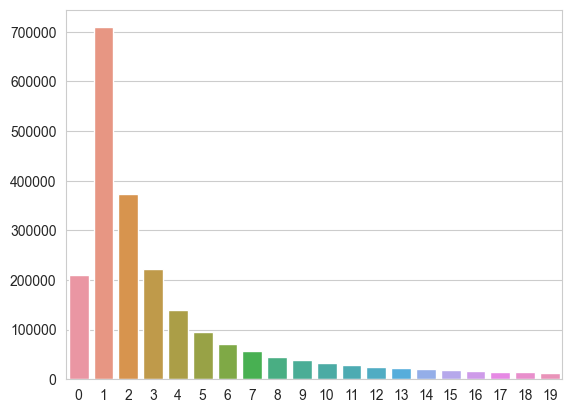

In [808]:
sns.barplot(x = x_um, y =  y_um)

<Axes: >

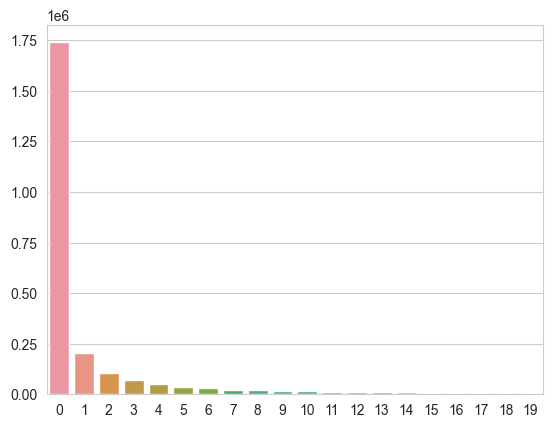

In [809]:
n = 20
x_mm = cell_line_npc.multimapped.value_counts().keys()[:n]
y_mm = cell_line_npc.multimapped.value_counts().values[:n]
sns.barplot(x = x_mm, y =  y_mm)

___
### 3. Max spliced overhang >= 30
1. Overhang is calculated as the minimum of the left or right ends of an SJ.
2. Therefore the maximum spliced overhang is the maximum or longest overhang found across the reads with the given SJ.
3. It follows that the maximum possible maxOverhang is readlength/2 
4. For example, a max overhang of 30 would mean that across all the reads that an SJ is detected it was found at a split of 120-30 or less, i.e. 130-20 or 140-10. 
5. Given that indicators of low quality: mean phred score decreases, adapter content increases, and read length truncations occur towards the end of the 150bp reads, setting a threshold of 30 could be considered as a stringent filtering level conferring confidence and reliability in the remaining reads.

<Axes: >

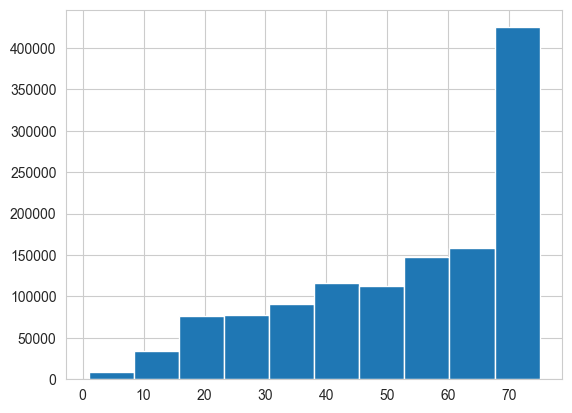

In [858]:
HN_tumour.max_spliced_overhang.hist()

In [889]:
HN_tumour[HN_tumour.max_spliced_overhang>=30].shape[0]

1062961

### 4. Generating filtered SJ out files (stringent)

Filtering criteria:
* Detected samples (>= 3 samples)
* Total reads (>= 5 reads)
* Max spliced overhang (>= 30 bps)
* Filter out junctions supported by multimappers only (unique_mapped==0)

1. NPC cell line
2. NPC tumour tissue (FFPE)
3. HN tumour
4. HN cell line

In [990]:
cell_line_npc[(cell_line_npc.found_sj_in_num_samples>=3) & 
              (cell_line_npc.total_mapped>=5) & 
             (cell_line_npc.max_spliced_overhang>=30) &
             (cell_line_npc.unique_mapped!=0)].shape[0]/cell_line_npc.shape[0]

0.3465710564973112

In [991]:
filtered_npc_cellline = cell_line_npc[(cell_line_npc.found_sj_in_num_samples>=3) & 
              (cell_line_npc.total_mapped>=5) & 
             (cell_line_npc.max_spliced_overhang>=30) &
             (cell_line_npc.unique_mapped!=0)]
filtered_npc_cellline.shape[0]

935449

In [992]:
rnaseq_npc['total_mapped'] = rnaseq_npc['unique_mapped'] + rnaseq_npc['multimapped']

In [993]:
rnaseq_npc[(rnaseq_npc.found_sj_in_num_samples>=3) & 
              (rnaseq_npc.total_mapped>=5) & 
             (rnaseq_npc.max_spliced_overhang>=30) &
             (rnaseq_npc.unique_mapped!=0)].shape[0]/rnaseq_npc.shape[0]

0.24717679073843457

In [994]:
filtered_npc_tumour = rnaseq_npc[(rnaseq_npc.found_sj_in_num_samples>=3) & 
              (rnaseq_npc.total_mapped>=5) & 
             (rnaseq_npc.max_spliced_overhang>=30) &
             (rnaseq_npc.unique_mapped!=0)]
filtered_npc_tumour.shape[0]

669880

In [995]:
HN_tumour['total_mapped'] = HN_tumour['unique_mapped'] + HN_tumour['multimapped']

In [996]:
HN_tumour[(HN_tumour.found_sj_in_num_samples>=3) & 
              (HN_tumour.total_mapped>=5) & 
             (HN_tumour.max_spliced_overhang>=30) &
             (HN_tumour.unique_mapped!=0)].shape[0]/HN_tumour.shape[0]

0.34596336904678837

In [997]:
filtered_HN_tumour = HN_tumour[(HN_tumour.found_sj_in_num_samples>=3) & 
              (HN_tumour.total_mapped>=5) & 
             (HN_tumour.max_spliced_overhang>=30) &
             (HN_tumour.unique_mapped!=0)]
filtered_HN_tumour.shape[0]

431371

In [998]:
HN_cellline['total_mapped'] = HN_cellline['unique_mapped'] + HN_cellline['multimapped']

In [999]:
HN_cellline[(HN_cellline.found_sj_in_num_samples>=3) & 
              (HN_cellline.total_mapped>=5) & 
             (HN_cellline.max_spliced_overhang>=30) &
             (HN_cellline.unique_mapped!=0)].shape[0]/HN_cellline.shape[0]

0.3444078650250571

In [1000]:
filtered_HN_cellline = HN_cellline[(HN_cellline.found_sj_in_num_samples>=3) & 
              (HN_cellline.total_mapped>=5) & 
             (HN_cellline.max_spliced_overhang>=30) &
             (HN_cellline.unique_mapped!=0)]
filtered_HN_cellline.shape[0]

552890

### 5. Downstream comparison of alignment metrics

Conditions to compare:
1. Raw unfiltered
2. Filtered
3. Portcullis on unfiltered
4. Portcullis + filtered

In [1001]:
filtered_HN_cellline[colnames_short].to_csv('filtered_sjs/filt_HN_celline.SJ.out.tab', sep = '\t', header=None, index=False)

In [1002]:
filtered_HN_tumour[colnames_short].to_csv('filtered_sjs/filt_HN_tumour.SJ.out.tab', sep = '\t', header=None, index=False)

In [1003]:
filtered_npc_cellline[colnames_short].to_csv('filtered_sjs/filt_npc_cellline.SJ.out.tab', sep = '\t', header=None, index=False)

In [1004]:
filtered_npc_tumour[colnames_short].to_csv('filtered_sjs/filt_npc_tumour.SJ.out.tab', sep = '\t', header=None, index=False)